# Input (welch)

## pacu

### Normalizing for each 1 min (welch)
- 20초 전체 input에 대해 정규화 적용. 그러면 welch에 적용하는 1초에는 baseline drift가 여전히 남아있음

In [59]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal
from scipy.signal import welch

### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수




input_path = 'dataset/preprocess3/input3-2/welch/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_2min/'
    ecg_path = '../../cranberry2/Preprocessing/vital_data/ECG_250Hz_pacu_2min/ECG,'
    df_preprocess_pacu = pickle.load(open('cache/preprocess3/input3/df_preprocess_pacu','rb'))
    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('caseid_test', 'rb'))
    caseid_train = pickle.load(open('caseid_train', 'rb'))
    caseid_val = pickle.load(open('caseid_val', 'rb'))
    

    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []
    x_val_pacu, y_val_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        

        # vital data - ECG (250Hz)
        ecg_samp = pickle.load(open(ecg_path+row['file_path'][:-3]+'vital', 'rb')).reset_index()[['ECG']]
        ecg_samp = ecg_samp.fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]
        ecg_per_NRS = np.full(30000,np.nan)
        ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
   

        
        # 한 NRS에 대해 23개의 input 확인
        for i in range(30,51):
            # input이 전처리 통과한 경우
            if row[str(i+1)]:
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000
                
                # input의 normalization
                pleth_inp = ppg_per_NRS[start_idx:end_idx]
                pleth_inp = pleth_inp - np.nanmean(pleth_inp)

                ecg_inp = ecg_per_NRS[start_idx:end_idx]
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)
                
                
                welch_ppg, welch_ecg = [], []
                # 1초맏 welch 적용
                for j in range(LEN_INPUT):
                    # ppg의 welch 적용 + 
                    welch_ppg = welch(pleth_inp[j*250:(j+1)*250], SRATE)[1]
                    welch_ecg = welch(ecg_inp[j*250:(j+1)*250],SRATE)[1]
                                                          
                    welch_ppg.append(welch_ppg)
                    welch_ecg.append(welch_ecg)
                
                
                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    x_test_pacu.append([welch_ppg, welch_ecg])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                elif row['caseids'] in caseid_val:
                    x_val_pacu.append([welch_ppg, welch_ecg])
                    y_val_pacu.append(int(float(row['NRS'])))
                    
                else:
                    x_train_pacu.append([welch_ppg, welch_ecg])
                    y_train_pacu.append(int(float(row['NRS'])))
                    
        print('completed')

    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, int)
    y_test_pacu = np.array(y_test_pacu, int)
    x_val_pacu = np.array(x_val_pacu, np.float32)
    y_val_pacu = np.array(y_val_pacu, int)

    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_pacu.npz', x_train_pacu)
    np.savez_compressed(input_path+'x_test_pacu.npz', x_test_pacu)
    np.savez_compressed(input_path+'x_val_pacu.npz', x_val_pacu)
    np.savez_compressed(input_path+'y_train_pacu.npz', y_train_pacu)
    np.savez_compressed(input_path+'y_test_pacu.npz', y_test_pacu)
    np.savez_compressed(input_path+'y_val_pacu.npz', y_val_pacu)
    print('done', flush=True)

    
    
    
print('size of training set(pacu):', len(x_train_pacu))
print('size of validation set(pacu):', len(x_val_pacu))
print('size of test set(pacu):', len(x_test_pacu))

loading data 1/7316 ...completed
loading data 2/7316 ...

/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))


completed
loading data 3/7316 ...completed
loading data 4/7316 ...completed
loading data 5/7316 ...completed
loading data 6/7316 ...completed
loading data 7/7316 ...completed
loading data 8/7316 ...completed
loading data 9/7316 ...completed
loading data 10/7316 ...completed
loading data 11/7316 ...completed
loading data 12/7316 ...completed
loading data 13/7316 ...completed
loading data 14/7316 ...completed
loading data 15/7316 ...completed
loading data 16/7316 ...completed
loading data 17/7316 ...completed
loading data 18/7316 ...completed
loading data 19/7316 ...completed
loading data 20/7316 ...completed
loading data 21/7316 ...completed
loading data 22/7316 ...completed
loading data 23/7316 ...completed
loading data 24/7316 ...completed
loading data 25/7316 ...completed
loading data 26/7316 ...completed
loading data 27/7316 ...completed
loading data 28/7316 ...completed
loading data 29/7316 ...completed
loading data 30/7316 ...completed
loading data 31/7316 ...completed
loading dat

loading data 241/7316 ...completed
loading data 242/7316 ...completed
loading data 243/7316 ...completed
loading data 244/7316 ...completed
loading data 245/7316 ...completed
loading data 246/7316 ...completed
loading data 247/7316 ...completed
loading data 248/7316 ...completed
loading data 249/7316 ...completed
loading data 250/7316 ...completed
loading data 251/7316 ...completed
loading data 252/7316 ...completed
loading data 253/7316 ...completed
loading data 254/7316 ...completed
loading data 255/7316 ...completed
loading data 256/7316 ...completed
loading data 257/7316 ...completed
loading data 258/7316 ...completed
loading data 259/7316 ...completed
loading data 260/7316 ...completed
loading data 261/7316 ...completed
loading data 262/7316 ...completed
loading data 263/7316 ...completed
loading data 264/7316 ...completed
loading data 265/7316 ...completed
loading data 266/7316 ...completed
loading data 267/7316 ...completed
loading data 268/7316 ...completed
loading data 269/731

loading data 476/7316 ...completed
loading data 477/7316 ...completed
loading data 478/7316 ...completed
loading data 479/7316 ...completed
loading data 480/7316 ...completed
loading data 481/7316 ...completed
loading data 482/7316 ...completed
loading data 483/7316 ...completed
loading data 484/7316 ...completed
loading data 485/7316 ...completed
loading data 486/7316 ...completed
loading data 487/7316 ...completed
loading data 488/7316 ...completed
loading data 489/7316 ...completed
loading data 490/7316 ...completed
loading data 491/7316 ...completed
loading data 492/7316 ...completed
loading data 493/7316 ...completed
loading data 494/7316 ...completed
loading data 495/7316 ...completed
loading data 496/7316 ...completed
loading data 497/7316 ...completed
loading data 498/7316 ...completed
loading data 499/7316 ...completed
loading data 500/7316 ...completed
loading data 501/7316 ...completed
loading data 502/7316 ...completed
loading data 503/7316 ...completed
loading data 504/731

loading data 711/7316 ...completed
loading data 712/7316 ...completed
loading data 713/7316 ...completed
loading data 714/7316 ...completed
loading data 715/7316 ...completed
loading data 716/7316 ...completed
loading data 717/7316 ...completed
loading data 718/7316 ...completed
loading data 719/7316 ...completed
loading data 720/7316 ...completed
loading data 721/7316 ...completed
loading data 722/7316 ...completed
loading data 723/7316 ...completed
loading data 724/7316 ...completed
loading data 725/7316 ...completed
loading data 726/7316 ...completed
loading data 727/7316 ...completed
loading data 728/7316 ...completed
loading data 729/7316 ...completed
loading data 730/7316 ...completed
loading data 731/7316 ...completed
loading data 732/7316 ...completed
loading data 733/7316 ...completed
loading data 734/7316 ...completed
loading data 735/7316 ...completed
loading data 736/7316 ...completed
loading data 737/7316 ...completed
loading data 738/7316 ...completed
loading data 739/731

loading data 1177/7316 ...completed
loading data 1178/7316 ...completed
loading data 1179/7316 ...completed
loading data 1180/7316 ...completed
loading data 1181/7316 ...completed
loading data 1182/7316 ...completed
loading data 1183/7316 ...completed
loading data 1184/7316 ...completed
loading data 1185/7316 ...completed
loading data 1186/7316 ...completed
loading data 1187/7316 ...completed
loading data 1188/7316 ...completed
loading data 1189/7316 ...completed
loading data 1190/7316 ...completed
loading data 1191/7316 ...completed
loading data 1192/7316 ...completed
loading data 1193/7316 ...completed
loading data 1194/7316 ...completed
loading data 1195/7316 ...completed
loading data 1196/7316 ...completed
loading data 1197/7316 ...completed
loading data 1198/7316 ...completed
loading data 1199/7316 ...completed
loading data 1200/7316 ...completed
loading data 1201/7316 ...completed
loading data 1202/7316 ...completed
loading data 1203/7316 ...completed
loading data 1204/7316 ...co

loading data 1406/7316 ...completed
loading data 1407/7316 ...completed
loading data 1408/7316 ...completed
loading data 1409/7316 ...completed
loading data 1410/7316 ...completed
loading data 1411/7316 ...completed
loading data 1412/7316 ...completed
loading data 1413/7316 ...completed
loading data 1414/7316 ...completed
loading data 1415/7316 ...completed
loading data 1416/7316 ...completed
loading data 1417/7316 ...completed
loading data 1418/7316 ...completed
loading data 1419/7316 ...completed
loading data 1420/7316 ...completed
loading data 1421/7316 ...completed
loading data 1422/7316 ...completed
loading data 1423/7316 ...completed
loading data 1424/7316 ...completed
loading data 1425/7316 ...completed
loading data 1426/7316 ...completed
loading data 1427/7316 ...completed
loading data 1428/7316 ...completed
loading data 1429/7316 ...completed
loading data 1430/7316 ...completed
loading data 1431/7316 ...completed
loading data 1432/7316 ...completed
loading data 1433/7316 ...co

loading data 1634/7316 ...completed
loading data 1635/7316 ...completed
loading data 1636/7316 ...completed
loading data 1637/7316 ...completed
loading data 1638/7316 ...completed
loading data 1639/7316 ...completed
loading data 1640/7316 ...completed
loading data 1641/7316 ...completed
loading data 1642/7316 ...completed
loading data 1643/7316 ...completed
loading data 1644/7316 ...completed
loading data 1645/7316 ...completed
loading data 1646/7316 ...completed
loading data 1647/7316 ...completed
loading data 1648/7316 ...completed
loading data 1649/7316 ...completed
loading data 1650/7316 ...completed
loading data 1651/7316 ...completed
loading data 1652/7316 ...completed
loading data 1653/7316 ...completed
loading data 1654/7316 ...completed
loading data 1655/7316 ...completed
loading data 1656/7316 ...completed
loading data 1657/7316 ...completed
loading data 1658/7316 ...completed
loading data 1659/7316 ...completed
loading data 1660/7316 ...completed
loading data 1661/7316 ...co

loading data 1866/7316 ...completed
loading data 1867/7316 ...completed
loading data 1868/7316 ...completed
loading data 1869/7316 ...completed
loading data 1870/7316 ...completed
loading data 1871/7316 ...completed
loading data 1872/7316 ...completed
loading data 1873/7316 ...completed
loading data 1874/7316 ...completed
loading data 1875/7316 ...completed
loading data 1876/7316 ...completed
loading data 1877/7316 ...completed
loading data 1878/7316 ...completed
loading data 1879/7316 ...completed
loading data 1880/7316 ...completed
loading data 1881/7316 ...completed
loading data 1882/7316 ...completed
loading data 1883/7316 ...completed
loading data 1884/7316 ...completed
loading data 1885/7316 ...completed
loading data 1886/7316 ...completed
loading data 1887/7316 ...completed
loading data 1888/7316 ...completed
loading data 1889/7316 ...completed
loading data 1890/7316 ...completed
loading data 1891/7316 ...completed
loading data 1892/7316 ...completed
loading data 1893/7316 ...co

loading data 2095/7316 ...completed
loading data 2096/7316 ...completed
loading data 2097/7316 ...completed
loading data 2098/7316 ...completed
loading data 2099/7316 ...completed
loading data 2100/7316 ...completed
loading data 2101/7316 ...completed
loading data 2102/7316 ...completed
loading data 2103/7316 ...completed
loading data 2104/7316 ...completed
loading data 2105/7316 ...completed
loading data 2106/7316 ...completed
loading data 2107/7316 ...completed
loading data 2108/7316 ...completed
loading data 2109/7316 ...completed
loading data 2110/7316 ...completed
loading data 2111/7316 ...completed
loading data 2112/7316 ...completed
loading data 2113/7316 ...completed
loading data 2114/7316 ...completed
loading data 2115/7316 ...completed
loading data 2116/7316 ...completed
loading data 2117/7316 ...completed
loading data 2118/7316 ...completed
loading data 2119/7316 ...completed
loading data 2120/7316 ...completed
loading data 2121/7316 ...completed
loading data 2122/7316 ...co

loading data 2323/7316 ...completed
loading data 2324/7316 ...completed
loading data 2325/7316 ...completed
loading data 2326/7316 ...completed
loading data 2327/7316 ...completed
loading data 2328/7316 ...completed
loading data 2329/7316 ...completed
loading data 2330/7316 ...completed
loading data 2331/7316 ...completed
loading data 2332/7316 ...completed
loading data 2333/7316 ...completed
loading data 2334/7316 ...completed
loading data 2335/7316 ...completed
loading data 2336/7316 ...completed
loading data 2337/7316 ...completed
loading data 2338/7316 ...completed
loading data 2339/7316 ...completed
loading data 2340/7316 ...completed
loading data 2341/7316 ...completed
loading data 2342/7316 ...completed
loading data 2343/7316 ...completed
loading data 2344/7316 ...completed
loading data 2345/7316 ...completed
loading data 2346/7316 ...completed
loading data 2347/7316 ...completed
loading data 2348/7316 ...completed
loading data 2349/7316 ...completed
loading data 2350/7316 ...co

loading data 2778/7316 ...completed
loading data 2779/7316 ...completed
loading data 2780/7316 ...completed
loading data 2781/7316 ...completed
loading data 2782/7316 ...completed
loading data 2783/7316 ...completed
loading data 2784/7316 ...completed
loading data 2785/7316 ...completed
loading data 2786/7316 ...completed
loading data 2787/7316 ...completed
loading data 2788/7316 ...completed
loading data 2789/7316 ...completed
loading data 2790/7316 ...completed
loading data 2791/7316 ...completed
loading data 2792/7316 ...completed
loading data 2793/7316 ...completed
loading data 2794/7316 ...completed
loading data 2795/7316 ...completed
loading data 2796/7316 ...completed
loading data 2797/7316 ...completed
loading data 2798/7316 ...completed
loading data 2799/7316 ...completed
loading data 2800/7316 ...completed
loading data 2801/7316 ...completed
loading data 2802/7316 ...completed
loading data 2803/7316 ...completed
loading data 2804/7316 ...completed
loading data 2805/7316 ...co

loading data 3007/7316 ...completed
loading data 3008/7316 ...completed
loading data 3009/7316 ...completed
loading data 3010/7316 ...completed
loading data 3011/7316 ...completed
loading data 3012/7316 ...completed
loading data 3013/7316 ...completed
loading data 3014/7316 ...completed
loading data 3015/7316 ...completed
loading data 3016/7316 ...completed
loading data 3017/7316 ...completed
loading data 3018/7316 ...completed
loading data 3019/7316 ...completed
loading data 3020/7316 ...completed
loading data 3021/7316 ...completed
loading data 3022/7316 ...completed
loading data 3023/7316 ...completed
loading data 3024/7316 ...completed
loading data 3025/7316 ...completed
loading data 3026/7316 ...completed
loading data 3027/7316 ...completed
loading data 3028/7316 ...completed
loading data 3029/7316 ...completed
loading data 3030/7316 ...completed
loading data 3031/7316 ...completed
loading data 3032/7316 ...completed
loading data 3033/7316 ...completed
loading data 3034/7316 ...co

loading data 3462/7316 ...completed
loading data 3463/7316 ...completed
loading data 3464/7316 ...completed
loading data 3465/7316 ...completed
loading data 3466/7316 ...completed
loading data 3467/7316 ...completed
loading data 3468/7316 ...completed
loading data 3469/7316 ...completed
loading data 3470/7316 ...completed
loading data 3471/7316 ...completed
loading data 3472/7316 ...completed
loading data 3473/7316 ...completed
loading data 3474/7316 ...completed
loading data 3475/7316 ...completed
loading data 3476/7316 ...completed
loading data 3477/7316 ...completed
loading data 3478/7316 ...completed
loading data 3479/7316 ...completed
loading data 3480/7316 ...completed
loading data 3481/7316 ...completed
loading data 3482/7316 ...completed
loading data 3483/7316 ...completed
loading data 3484/7316 ...completed
loading data 3485/7316 ...completed
loading data 3486/7316 ...completed
loading data 3487/7316 ...completed
loading data 3488/7316 ...completed
loading data 3489/7316 ...co

loading data 3691/7316 ...completed
loading data 3692/7316 ...completed
loading data 3693/7316 ...completed
loading data 3694/7316 ...completed
loading data 3695/7316 ...completed
loading data 3696/7316 ...completed
loading data 3697/7316 ...completed
loading data 3698/7316 ...completed
loading data 3699/7316 ...completed
loading data 3700/7316 ...completed
loading data 3701/7316 ...completed
loading data 3702/7316 ...completed
loading data 3703/7316 ...completed
loading data 3704/7316 ...completed
loading data 3705/7316 ...completed
loading data 3706/7316 ...completed
loading data 3707/7316 ...completed
loading data 3708/7316 ...completed
loading data 3709/7316 ...completed
loading data 3710/7316 ...completed
loading data 3711/7316 ...completed
loading data 3712/7316 ...completed
loading data 3713/7316 ...completed
loading data 3714/7316 ...completed
loading data 3715/7316 ...completed
loading data 3716/7316 ...completed
loading data 3717/7316 ...completed
loading data 3718/7316 ...co

loading data 4146/7316 ...completed
loading data 4147/7316 ...completed
loading data 4148/7316 ...completed
loading data 4149/7316 ...completed
loading data 4150/7316 ...completed
loading data 4151/7316 ...completed
loading data 4152/7316 ...completed
loading data 4153/7316 ...completed
loading data 4154/7316 ...completed
loading data 4155/7316 ...completed
loading data 4156/7316 ...completed
loading data 4157/7316 ...completed
loading data 4158/7316 ...completed
loading data 4159/7316 ...completed
loading data 4160/7316 ...completed
loading data 4161/7316 ...completed
loading data 4162/7316 ...completed
loading data 4163/7316 ...completed
loading data 4164/7316 ...completed
loading data 4165/7316 ...completed
loading data 4166/7316 ...completed
loading data 4167/7316 ...completed
loading data 4168/7316 ...completed
loading data 4169/7316 ...completed
loading data 4170/7316 ...completed
loading data 4171/7316 ...completed
loading data 4172/7316 ...completed
loading data 4173/7316 ...co

loading data 4375/7316 ...completed
loading data 4376/7316 ...completed
loading data 4377/7316 ...completed
loading data 4378/7316 ...completed
loading data 4379/7316 ...completed
loading data 4380/7316 ...completed
loading data 4381/7316 ...completed
loading data 4382/7316 ...completed
loading data 4383/7316 ...completed
loading data 4384/7316 ...completed
loading data 4385/7316 ...completed
loading data 4386/7316 ...completed
loading data 4387/7316 ...completed
loading data 4388/7316 ...completed
loading data 4389/7316 ...completed
loading data 4390/7316 ...completed
loading data 4391/7316 ...completed
loading data 4392/7316 ...completed
loading data 4393/7316 ...completed
loading data 4394/7316 ...completed
loading data 4395/7316 ...completed
loading data 4396/7316 ...completed
loading data 4397/7316 ...completed
loading data 4398/7316 ...completed
loading data 4399/7316 ...completed
loading data 4400/7316 ...completed
loading data 4401/7316 ...completed
loading data 4402/7316 ...co

loading data 4829/7316 ...completed
loading data 4830/7316 ...completed
loading data 4831/7316 ...completed
loading data 4832/7316 ...completed
loading data 4833/7316 ...completed
loading data 4834/7316 ...completed
loading data 4835/7316 ...completed
loading data 4836/7316 ...completed
loading data 4837/7316 ...completed
loading data 4838/7316 ...completed
loading data 4839/7316 ...completed
loading data 4840/7316 ...completed
loading data 4841/7316 ...completed
loading data 4842/7316 ...completed
loading data 4843/7316 ...completed
loading data 4844/7316 ...completed
loading data 4845/7316 ...completed
loading data 4846/7316 ...completed
loading data 4847/7316 ...completed
loading data 4848/7316 ...completed
loading data 4849/7316 ...completed
loading data 4850/7316 ...completed
loading data 4851/7316 ...completed
loading data 4852/7316 ...completed
loading data 4853/7316 ...completed
loading data 4854/7316 ...completed
loading data 4855/7316 ...completed
loading data 4856/7316 ...co

loading data 5283/7316 ...completed
loading data 5284/7316 ...completed
loading data 5285/7316 ...completed
loading data 5286/7316 ...completed
loading data 5287/7316 ...completed
loading data 5288/7316 ...completed
loading data 5289/7316 ...completed
loading data 5290/7316 ...completed
loading data 5291/7316 ...completed
loading data 5292/7316 ...completed
loading data 5293/7316 ...completed
loading data 5294/7316 ...completed
loading data 5295/7316 ...completed
loading data 5296/7316 ...completed
loading data 5297/7316 ...completed
loading data 5298/7316 ...completed
loading data 5299/7316 ...completed
loading data 5300/7316 ...completed
loading data 5301/7316 ...completed
loading data 5302/7316 ...completed
loading data 5303/7316 ...completed
loading data 5304/7316 ...completed
loading data 5305/7316 ...completed
loading data 5306/7316 ...completed
loading data 5307/7316 ...completed
loading data 5308/7316 ...completed
loading data 5309/7316 ...completed
loading data 5310/7316 ...co

loading data 5737/7316 ...completed
loading data 5738/7316 ...completed
loading data 5739/7316 ...completed
loading data 5740/7316 ...completed
loading data 5741/7316 ...completed
loading data 5742/7316 ...completed
loading data 5743/7316 ...completed
loading data 5744/7316 ...completed
loading data 5745/7316 ...completed
loading data 5746/7316 ...completed
loading data 5747/7316 ...completed
loading data 5748/7316 ...completed
loading data 5749/7316 ...completed
loading data 5750/7316 ...completed
loading data 5751/7316 ...completed
loading data 5752/7316 ...completed
loading data 5753/7316 ...completed
loading data 5754/7316 ...completed
loading data 5755/7316 ...completed
loading data 5756/7316 ...completed
loading data 5757/7316 ...completed
loading data 5758/7316 ...completed
loading data 5759/7316 ...completed
loading data 5760/7316 ...completed
loading data 5761/7316 ...completed
loading data 5762/7316 ...completed
loading data 5763/7316 ...completed
loading data 5764/7316 ...co

loading data 6192/7316 ...completed
loading data 6193/7316 ...completed
loading data 6194/7316 ...completed
loading data 6195/7316 ...completed
loading data 6196/7316 ...completed
loading data 6197/7316 ...completed
loading data 6198/7316 ...completed
loading data 6199/7316 ...completed
loading data 6200/7316 ...completed
loading data 6201/7316 ...completed
loading data 6202/7316 ...completed
loading data 6203/7316 ...completed
loading data 6204/7316 ...completed
loading data 6205/7316 ...completed
loading data 6206/7316 ...completed
loading data 6207/7316 ...completed
loading data 6208/7316 ...completed
loading data 6209/7316 ...completed
loading data 6210/7316 ...completed
loading data 6211/7316 ...completed
loading data 6212/7316 ...completed
loading data 6213/7316 ...completed
loading data 6214/7316 ...completed
loading data 6215/7316 ...completed
loading data 6216/7316 ...completed
loading data 6217/7316 ...completed
loading data 6218/7316 ...completed
loading data 6219/7316 ...co

loading data 6646/7316 ...completed
loading data 6647/7316 ...completed
loading data 6648/7316 ...completed
loading data 6649/7316 ...completed
loading data 6650/7316 ...completed
loading data 6651/7316 ...completed
loading data 6652/7316 ...completed
loading data 6653/7316 ...completed
loading data 6654/7316 ...completed
loading data 6655/7316 ...completed
loading data 6656/7316 ...completed
loading data 6657/7316 ...completed
loading data 6658/7316 ...completed
loading data 6659/7316 ...completed
loading data 6660/7316 ...completed
loading data 6661/7316 ...completed
loading data 6662/7316 ...completed
loading data 6663/7316 ...completed
loading data 6664/7316 ...completed
loading data 6665/7316 ...completed
loading data 6666/7316 ...completed
loading data 6667/7316 ...completed
loading data 6668/7316 ...completed
loading data 6669/7316 ...completed
loading data 6670/7316 ...completed
loading data 6671/7316 ...completed
loading data 6672/7316 ...completed
loading data 6673/7316 ...co

loading data 6874/7316 ...completed
loading data 6875/7316 ...completed
loading data 6876/7316 ...completed
loading data 6877/7316 ...completed
loading data 6878/7316 ...completed
loading data 6879/7316 ...completed
loading data 6880/7316 ...completed
loading data 6881/7316 ...completed
loading data 6882/7316 ...completed
loading data 6883/7316 ...completed
loading data 6884/7316 ...completed
loading data 6885/7316 ...completed
loading data 6886/7316 ...completed
loading data 6887/7316 ...completed
loading data 6888/7316 ...completed
loading data 6889/7316 ...completed
loading data 6890/7316 ...completed
loading data 6891/7316 ...completed
loading data 6892/7316 ...completed
loading data 6893/7316 ...completed
loading data 6894/7316 ...completed
loading data 6895/7316 ...completed
loading data 6896/7316 ...completed
loading data 6897/7316 ...completed
loading data 6898/7316 ...completed
loading data 6899/7316 ...completed
loading data 6900/7316 ...completed
loading data 6901/7316 ...co

loading data 7103/7316 ...completed
loading data 7104/7316 ...completed
loading data 7105/7316 ...completed
loading data 7106/7316 ...completed
loading data 7107/7316 ...completed
loading data 7108/7316 ...completed
loading data 7109/7316 ...completed
loading data 7110/7316 ...completed
loading data 7111/7316 ...completed
loading data 7112/7316 ...completed
loading data 7113/7316 ...completed
loading data 7114/7316 ...completed
loading data 7115/7316 ...completed
loading data 7116/7316 ...completed
loading data 7117/7316 ...completed
loading data 7118/7316 ...completed
loading data 7119/7316 ...completed
loading data 7120/7316 ...completed
loading data 7121/7316 ...completed
loading data 7122/7316 ...completed
loading data 7123/7316 ...completed
loading data 7124/7316 ...completed
loading data 7125/7316 ...completed
loading data 7126/7316 ...completed
loading data 7127/7316 ...completed
loading data 7128/7316 ...completed
loading data 7129/7316 ...completed
loading data 7130/7316 ...co

### Normalizing for each 1s (welch4)
- welch 적용하는 1초 vital에 대해 정규화 적용
- ppg는 평균 0으로 baseline drift
- ecg는 정규화
- welch = Hann filter + fft + 절반을 나눠 복수수 power 계산 + 원하는 크기만큼 구간을 나눠서 평균
- train, val, test mask는 cnn model에 들어가는 input에 해당되는 x 값의 index를 맞추기 위함

### window size 1024/250s *** (preprocess4/welch)

In [4]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal
from scipy.signal import windows
sys.path.append('../DL_model')


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수



input_path = 'dataset/preprocess4/welch/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_2min/'
    ecg_path = '../../cranberry2/Preprocessing/vital_data/ECG_250Hz_pacu_2min/ECG,'
    df_preprocess_pacu = pickle.load(open('cache/preprocess3/input3/df_preprocess_pacu_agender','rb'))

    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('caseid_test_new', 'rb'))
    caseid_train = pickle.load(open('caseid_train_new', 'rb'))
    caseid_val = pickle.load(open('caseid_val_new', 'rb'))
    
    non_case = []
    train_mask, val_mask, test_mask = [], [], []
    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []
    x_val_pacu, y_val_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        

        # vital data - ECG (250Hz)
        ecg_samp = pickle.load(open(ecg_path+row['file_path'][:-3]+'vital', 'rb')).reset_index()[['ECG']]
        ecg_samp = ecg_samp.fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]
        ecg_per_NRS = np.full(30000,np.nan)
        ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
   

        
        # 한 NRS에 대해 23개의 input 확인
        for i in range(30,51):
            # input이 전처리 통과한 경우
            if row[str(i+1)]:
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000
                
                
                # input의 normalization
                ppg_inp = ppg_per_NRS[start_idx:end_idx]
                ecg_inp = ecg_per_NRS[start_idx:end_idx]
                
                
                switch = False
                welch_ppg, welch_ecg = [], []
                
                # 1024/250 의 window size로 1초 간격으로 fft
                stride = 1 # 1초
                fft_window_size = 1024  # 약 4초
                n_window = int((LEN_INPUT-fft_window_size/SRATE)/stride) + 1
                for j in range(n_window):
                    
                    # welch 작업 - hann window를 씌워주고 fft 적용
                    ppg1 = ppg_inp[j*SRATE:j*SRATE + fft_window_size]
                    ecg1 = ecg_inp[j*SRATE:j*SRATE + fft_window_size]
                    if np.sum(np.isnan(ppg1))!=0 or np.sum(np.isnan(ecg1))!=0:
                        switch = True
                        continue
                        
                    #ppg1 = pd.DataFrame(ppg1).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.faltten()
                    ppg2 = ppg1 - np.mean(ppg1)
                    fft_p = np.fft.fft(ppg2 * windows.hann(fft_window_size))
                    fft_p = fft_p[:fft_window_size // 2]
                    fft_p = np.reshape(fft_p, (-1, 4)).sum(axis=-1)
                    fft_p *= fft_p.conj()

                    ecg2 = (ecg1 - np.mean(ecg1)) / np.std(ecg1)
                    fft_e = np.fft.fft(ecg2 * windows.hann(fft_window_size))
                    fft_e = fft_e[:fft_window_size // 2]
                    fft_e = np.reshape(fft_e, (-1, 4)).sum(axis=-1)
                    fft_e *= fft_e.conj()
           
                    welch_ppg.append(fft_p)
                    welch_ecg.append(fft_e)

                
                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    if switch:
                        test_mask.append(False)
                        continue
                    test_mask.append(True)                    
                    x_test_pacu.append([welch_ppg, welch_ecg])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                elif row['caseids'] in caseid_val:
                    if switch:
                        val_mask.append(False)
                        continue
                    val_mask.append(True)                      
                    x_val_pacu.append([welch_ppg, welch_ecg])
                    y_val_pacu.append(int(float(row['NRS'])))
                    
                elif row['caseids'] in caseid_train:
                    if switch:
                        train_mask.append(False)
                        continue
                    train_mask.append(True)                      
                    x_train_pacu.append([welch_ppg, welch_ecg])
                    y_train_pacu.append(int(float(row['NRS'])))
                    
                else:
                    non_case.append(row['caseids'])
                    
        print('completed')

    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, int)
    y_test_pacu = np.array(y_test_pacu, int)
    x_val_pacu = np.array(x_val_pacu, np.float32)
    y_val_pacu = np.array(y_val_pacu, int)

    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_pacu.npz', x_train_pacu)
    np.savez_compressed(input_path+'x_test_pacu.npz', x_test_pacu)
    np.savez_compressed(input_path+'x_val_pacu.npz', x_val_pacu)
    np.savez_compressed(input_path+'y_train_pacu.npz', y_train_pacu)
    np.savez_compressed(input_path+'y_test_pacu.npz', y_test_pacu)
    np.savez_compressed(input_path+'y_val_pacu.npz', y_val_pacu)
    print('done', flush=True)

   
    
    
print('size of training set(pacu):', len(x_train_pacu))
print('size of validation set(pacu):', len(x_val_pacu))
print('size of test set(pacu):', len(x_test_pacu))


import pickle


pickle.dump(test_mask, open(input_path+'test_mask_pacu','wb'))
pickle.dump(train_mask, open(input_path+'train_mask_pacu','wb'))
pickle.dump(val_mask, open(input_path+'val_mask_pacu','wb'))

loading data 1/7253 ...completed
loading data 2/7253 ...completed
loading data 3/7253 ...completed
loading data 4/7253 ...completed
loading data 5/7253 ...completed
loading data 6/7253 ...completed
loading data 7/7253 ...completed
loading data 8/7253 ...completed
loading data 9/7253 ...completed
loading data 10/7253 ...completed
loading data 11/7253 ...completed
loading data 12/7253 ...completed
loading data 13/7253 ...completed
loading data 14/7253 ...completed
loading data 15/7253 ...completed
loading data 16/7253 ...completed
loading data 17/7253 ...completed
loading data 18/7253 ...completed
loading data 19/7253 ...completed
loading data 20/7253 ...completed
loading data 21/7253 ...completed
loading data 22/7253 ...completed
loading data 23/7253 ...completed
loading data 24/7253 ...completed
loading data 25/7253 ...completed
loading data 26/7253 ...completed
loading data 27/7253 ...completed
loading data 28/7253 ...completed
loading data 29/7253 ...completed
loading data 30/7253 ..

loading data 472/7253 ...completed
loading data 473/7253 ...completed
loading data 474/7253 ...completed
loading data 475/7253 ...completed
loading data 476/7253 ...completed
loading data 477/7253 ...completed
loading data 478/7253 ...completed
loading data 479/7253 ...completed
loading data 480/7253 ...completed
loading data 481/7253 ...completed
loading data 482/7253 ...completed
loading data 483/7253 ...completed
loading data 484/7253 ...completed
loading data 485/7253 ...completed
loading data 486/7253 ...completed
loading data 487/7253 ...completed
loading data 488/7253 ...completed
loading data 489/7253 ...completed
loading data 490/7253 ...completed
loading data 491/7253 ...completed
loading data 492/7253 ...completed
loading data 493/7253 ...completed
loading data 494/7253 ...completed
loading data 495/7253 ...completed
loading data 496/7253 ...completed
loading data 497/7253 ...completed
loading data 498/7253 ...completed
loading data 499/7253 ...completed
loading data 500/725

loading data 941/7253 ...completed
loading data 942/7253 ...completed
loading data 943/7253 ...completed
loading data 944/7253 ...completed
loading data 945/7253 ...completed
loading data 946/7253 ...completed
loading data 947/7253 ...completed
loading data 948/7253 ...completed
loading data 949/7253 ...completed
loading data 950/7253 ...completed
loading data 951/7253 ...completed
loading data 952/7253 ...completed
loading data 953/7253 ...completed
loading data 954/7253 ...completed
loading data 955/7253 ...completed
loading data 956/7253 ...completed
loading data 957/7253 ...completed
loading data 958/7253 ...completed
loading data 959/7253 ...completed
loading data 960/7253 ...completed
loading data 961/7253 ...completed
loading data 962/7253 ...completed
loading data 963/7253 ...completed
loading data 964/7253 ...completed
loading data 965/7253 ...completed
loading data 966/7253 ...completed
loading data 967/7253 ...completed
loading data 968/7253 ...completed
loading data 969/725

loading data 1172/7253 ...completed
loading data 1173/7253 ...completed
loading data 1174/7253 ...completed
loading data 1175/7253 ...completed
loading data 1176/7253 ...completed
loading data 1177/7253 ...completed
loading data 1178/7253 ...completed
loading data 1179/7253 ...completed
loading data 1180/7253 ...completed
loading data 1181/7253 ...completed
loading data 1182/7253 ...completed
loading data 1183/7253 ...completed
loading data 1184/7253 ...completed
loading data 1185/7253 ...completed
loading data 1186/7253 ...completed
loading data 1187/7253 ...completed
loading data 1188/7253 ...completed
loading data 1189/7253 ...completed
loading data 1190/7253 ...completed
loading data 1191/7253 ...completed
loading data 1192/7253 ...completed
loading data 1193/7253 ...completed
loading data 1194/7253 ...completed
loading data 1195/7253 ...completed
loading data 1196/7253 ...completed
loading data 1197/7253 ...completed
loading data 1198/7253 ...completed
loading data 1199/7253 ...co

loading data 1626/7253 ...completed
loading data 1627/7253 ...completed
loading data 1628/7253 ...completed
loading data 1629/7253 ...completed
loading data 1630/7253 ...completed
loading data 1631/7253 ...completed
loading data 1632/7253 ...completed
loading data 1633/7253 ...completed
loading data 1634/7253 ...completed
loading data 1635/7253 ...completed
loading data 1636/7253 ...completed
loading data 1637/7253 ...completed
loading data 1638/7253 ...completed
loading data 1639/7253 ...completed
loading data 1640/7253 ...completed
loading data 1641/7253 ...completed
loading data 1642/7253 ...completed
loading data 1643/7253 ...completed
loading data 1644/7253 ...completed
loading data 1645/7253 ...completed
loading data 1646/7253 ...completed
loading data 1647/7253 ...completed
loading data 1648/7253 ...completed
loading data 1649/7253 ...completed
loading data 1650/7253 ...completed
loading data 1651/7253 ...completed
loading data 1652/7253 ...completed
loading data 1653/7253 ...co

loading data 1855/7253 ...completed
loading data 1856/7253 ...completed
loading data 1857/7253 ...completed
loading data 1858/7253 ...completed
loading data 1859/7253 ...completed
loading data 1860/7253 ...completed
loading data 1861/7253 ...completed
loading data 1862/7253 ...completed
loading data 1863/7253 ...completed
loading data 1864/7253 ...completed
loading data 1865/7253 ...completed
loading data 1866/7253 ...completed
loading data 1867/7253 ...completed
loading data 1868/7253 ...completed
loading data 1869/7253 ...completed
loading data 1870/7253 ...completed
loading data 1871/7253 ...completed
loading data 1872/7253 ...completed
loading data 1873/7253 ...completed
loading data 1874/7253 ...completed
loading data 1875/7253 ...completed
loading data 1876/7253 ...completed
loading data 1877/7253 ...completed
loading data 1878/7253 ...completed
loading data 1879/7253 ...completed
loading data 1880/7253 ...completed
loading data 1881/7253 ...completed
loading data 1882/7253 ...co

loading data 2084/7253 ...completed
loading data 2085/7253 ...completed
loading data 2086/7253 ...completed
loading data 2087/7253 ...completed
loading data 2088/7253 ...completed
loading data 2089/7253 ...completed
loading data 2090/7253 ...completed
loading data 2091/7253 ...completed
loading data 2092/7253 ...completed
loading data 2093/7253 ...completed
loading data 2094/7253 ...completed
loading data 2095/7253 ...completed
loading data 2096/7253 ...completed
loading data 2097/7253 ...completed
loading data 2098/7253 ...completed
loading data 2099/7253 ...completed
loading data 2100/7253 ...completed
loading data 2101/7253 ...completed
loading data 2102/7253 ...completed
loading data 2103/7253 ...completed
loading data 2104/7253 ...completed
loading data 2105/7253 ...completed
loading data 2106/7253 ...completed
loading data 2107/7253 ...completed
loading data 2108/7253 ...completed
loading data 2109/7253 ...completed
loading data 2110/7253 ...completed
loading data 2111/7253 ...co

loading data 2538/7253 ...completed
loading data 2539/7253 ...completed
loading data 2540/7253 ...completed
loading data 2541/7253 ...completed
loading data 2542/7253 ...completed
loading data 2543/7253 ...completed
loading data 2544/7253 ...completed
loading data 2545/7253 ...completed
loading data 2546/7253 ...completed
loading data 2547/7253 ...completed
loading data 2548/7253 ...completed
loading data 2549/7253 ...completed
loading data 2550/7253 ...completed
loading data 2551/7253 ...completed
loading data 2552/7253 ...completed
loading data 2553/7253 ...completed
loading data 2554/7253 ...completed
loading data 2555/7253 ...completed
loading data 2556/7253 ...completed
loading data 2557/7253 ...completed
loading data 2558/7253 ...completed
loading data 2559/7253 ...completed
loading data 2560/7253 ...completed
loading data 2561/7253 ...completed
loading data 2562/7253 ...completed
loading data 2563/7253 ...completed
loading data 2564/7253 ...completed
loading data 2565/7253 ...co

loading data 2766/7253 ...completed
loading data 2767/7253 ...completed
loading data 2768/7253 ...completed
loading data 2769/7253 ...completed
loading data 2770/7253 ...completed
loading data 2771/7253 ...completed
loading data 2772/7253 ...completed
loading data 2773/7253 ...completed
loading data 2774/7253 ...completed
loading data 2775/7253 ...completed
loading data 2776/7253 ...completed
loading data 2777/7253 ...completed
loading data 2778/7253 ...completed
loading data 2779/7253 ...completed
loading data 2780/7253 ...completed
loading data 2781/7253 ...completed
loading data 2782/7253 ...completed
loading data 2783/7253 ...completed
loading data 2784/7253 ...completed
loading data 2785/7253 ...completed
loading data 2786/7253 ...completed
loading data 2787/7253 ...completed
loading data 2788/7253 ...completed
loading data 2789/7253 ...completed
loading data 2790/7253 ...completed
loading data 2791/7253 ...completed
loading data 2792/7253 ...completed
loading data 2793/7253 ...co

loading data 3221/7253 ...completed
loading data 3222/7253 ...completed
loading data 3223/7253 ...completed
loading data 3224/7253 ...completed
loading data 3225/7253 ...completed
loading data 3226/7253 ...completed
loading data 3227/7253 ...completed
loading data 3228/7253 ...completed
loading data 3229/7253 ...completed
loading data 3230/7253 ...completed
loading data 3231/7253 ...completed
loading data 3232/7253 ...completed
loading data 3233/7253 ...completed
loading data 3234/7253 ...completed
loading data 3235/7253 ...completed
loading data 3236/7253 ...completed
loading data 3237/7253 ...completed
loading data 3238/7253 ...completed
loading data 3239/7253 ...completed
loading data 3240/7253 ...completed
loading data 3241/7253 ...completed
loading data 3242/7253 ...completed
loading data 3243/7253 ...completed
loading data 3244/7253 ...completed
loading data 3245/7253 ...completed
loading data 3246/7253 ...completed
loading data 3247/7253 ...completed
loading data 3248/7253 ...co

loading data 3449/7253 ...completed
loading data 3450/7253 ...completed
loading data 3451/7253 ...completed
loading data 3452/7253 ...completed
loading data 3453/7253 ...completed
loading data 3454/7253 ...completed
loading data 3455/7253 ...completed
loading data 3456/7253 ...completed
loading data 3457/7253 ...completed
loading data 3458/7253 ...completed
loading data 3459/7253 ...completed
loading data 3460/7253 ...completed
loading data 3461/7253 ...completed
loading data 3462/7253 ...completed
loading data 3463/7253 ...completed
loading data 3464/7253 ...completed
loading data 3465/7253 ...completed
loading data 3466/7253 ...completed
loading data 3467/7253 ...completed
loading data 3468/7253 ...completed
loading data 3469/7253 ...completed
loading data 3470/7253 ...completed
loading data 3471/7253 ...completed
loading data 3472/7253 ...completed
loading data 3473/7253 ...completed
loading data 3474/7253 ...completed
loading data 3475/7253 ...completed
loading data 3476/7253 ...co

loading data 3904/7253 ...completed
loading data 3905/7253 ...completed
loading data 3906/7253 ...completed
loading data 3907/7253 ...completed
loading data 3908/7253 ...completed
loading data 3909/7253 ...completed
loading data 3910/7253 ...completed
loading data 3911/7253 ...completed
loading data 3912/7253 ...completed
loading data 3913/7253 ...completed
loading data 3914/7253 ...completed
loading data 3915/7253 ...completed
loading data 3916/7253 ...completed
loading data 3917/7253 ...completed
loading data 3918/7253 ...completed
loading data 3919/7253 ...completed
loading data 3920/7253 ...completed
loading data 3921/7253 ...completed
loading data 3922/7253 ...completed
loading data 3923/7253 ...completed
loading data 3924/7253 ...completed
loading data 3925/7253 ...completed
loading data 3926/7253 ...completed
loading data 3927/7253 ...completed
loading data 3928/7253 ...completed
loading data 3929/7253 ...completed
loading data 3930/7253 ...completed
loading data 3931/7253 ...co

loading data 4358/7253 ...completed
loading data 4359/7253 ...completed
loading data 4360/7253 ...completed
loading data 4361/7253 ...completed
loading data 4362/7253 ...completed
loading data 4363/7253 ...completed
loading data 4364/7253 ...completed
loading data 4365/7253 ...completed
loading data 4366/7253 ...completed
loading data 4367/7253 ...completed
loading data 4368/7253 ...completed
loading data 4369/7253 ...completed
loading data 4370/7253 ...completed
loading data 4371/7253 ...completed
loading data 4372/7253 ...completed
loading data 4373/7253 ...completed
loading data 4374/7253 ...completed
loading data 4375/7253 ...completed
loading data 4376/7253 ...completed
loading data 4377/7253 ...completed
loading data 4378/7253 ...completed
loading data 4379/7253 ...completed
loading data 4380/7253 ...completed
loading data 4381/7253 ...completed
loading data 4382/7253 ...completed
loading data 4383/7253 ...completed
loading data 4384/7253 ...completed
loading data 4385/7253 ...co

loading data 4589/7253 ...completed
loading data 4590/7253 ...completed
loading data 4591/7253 ...completed
loading data 4592/7253 ...completed
loading data 4593/7253 ...completed
loading data 4594/7253 ...completed
loading data 4595/7253 ...completed
loading data 4596/7253 ...completed
loading data 4597/7253 ...completed
loading data 4598/7253 ...completed
loading data 4599/7253 ...completed
loading data 4600/7253 ...completed
loading data 4601/7253 ...completed
loading data 4602/7253 ...completed
loading data 4603/7253 ...completed
loading data 4604/7253 ...completed
loading data 4605/7253 ...completed
loading data 4606/7253 ...completed
loading data 4607/7253 ...completed
loading data 4608/7253 ...completed
loading data 4609/7253 ...completed
loading data 4610/7253 ...completed
loading data 4611/7253 ...completed
loading data 4612/7253 ...completed
loading data 4613/7253 ...completed
loading data 4614/7253 ...completed
loading data 4615/7253 ...completed
loading data 4616/7253 ...co

loading data 5044/7253 ...completed
loading data 5045/7253 ...completed
loading data 5046/7253 ...completed
loading data 5047/7253 ...completed
loading data 5048/7253 ...completed
loading data 5049/7253 ...completed
loading data 5050/7253 ...completed
loading data 5051/7253 ...completed
loading data 5052/7253 ...completed
loading data 5053/7253 ...completed
loading data 5054/7253 ...completed
loading data 5055/7253 ...completed
loading data 5056/7253 ...completed
loading data 5057/7253 ...completed
loading data 5058/7253 ...completed
loading data 5059/7253 ...completed
loading data 5060/7253 ...completed
loading data 5061/7253 ...completed
loading data 5062/7253 ...completed
loading data 5063/7253 ...completed
loading data 5064/7253 ...completed
loading data 5065/7253 ...completed
loading data 5066/7253 ...completed
loading data 5067/7253 ...completed
loading data 5068/7253 ...completed
loading data 5069/7253 ...completed
loading data 5070/7253 ...completed
loading data 5071/7253 ...co

loading data 5500/7253 ...completed
loading data 5501/7253 ...completed
loading data 5502/7253 ...completed
loading data 5503/7253 ...completed
loading data 5504/7253 ...completed
loading data 5505/7253 ...completed
loading data 5506/7253 ...completed
loading data 5507/7253 ...completed
loading data 5508/7253 ...completed
loading data 5509/7253 ...completed
loading data 5510/7253 ...completed
loading data 5511/7253 ...completed
loading data 5512/7253 ...completed
loading data 5513/7253 ...completed
loading data 5514/7253 ...completed
loading data 5515/7253 ...completed
loading data 5516/7253 ...completed
loading data 5517/7253 ...completed
loading data 5518/7253 ...completed
loading data 5519/7253 ...completed
loading data 5520/7253 ...completed
loading data 5521/7253 ...completed
loading data 5522/7253 ...completed
loading data 5523/7253 ...completed
loading data 5524/7253 ...completed
loading data 5525/7253 ...completed
loading data 5526/7253 ...completed
loading data 5527/7253 ...co

loading data 5729/7253 ...completed
loading data 5730/7253 ...completed
loading data 5731/7253 ...completed
loading data 5732/7253 ...completed
loading data 5733/7253 ...completed
loading data 5734/7253 ...completed
loading data 5735/7253 ...completed
loading data 5736/7253 ...completed
loading data 5737/7253 ...completed
loading data 5738/7253 ...completed
loading data 5739/7253 ...completed
loading data 5740/7253 ...completed
loading data 5741/7253 ...completed
loading data 5742/7253 ...completed
loading data 5743/7253 ...completed
loading data 5744/7253 ...completed
loading data 5745/7253 ...completed
loading data 5746/7253 ...completed
loading data 5747/7253 ...completed
loading data 5748/7253 ...completed
loading data 5749/7253 ...completed
loading data 5750/7253 ...completed
loading data 5751/7253 ...completed
loading data 5752/7253 ...completed
loading data 5753/7253 ...completed
loading data 5754/7253 ...completed
loading data 5755/7253 ...completed
loading data 5756/7253 ...co

loading data 5958/7253 ...completed
loading data 5959/7253 ...completed
loading data 5960/7253 ...completed
loading data 5961/7253 ...completed
loading data 5962/7253 ...completed
loading data 5963/7253 ...completed
loading data 5964/7253 ...completed
loading data 5965/7253 ...completed
loading data 5966/7253 ...completed
loading data 5967/7253 ...completed
loading data 5968/7253 ...completed
loading data 5969/7253 ...completed
loading data 5970/7253 ...completed
loading data 5971/7253 ...completed
loading data 5972/7253 ...completed
loading data 5973/7253 ...completed
loading data 5974/7253 ...completed
loading data 5975/7253 ...completed
loading data 5976/7253 ...completed
loading data 5977/7253 ...completed
loading data 5978/7253 ...completed
loading data 5979/7253 ...completed
loading data 5980/7253 ...completed
loading data 5981/7253 ...completed
loading data 5982/7253 ...completed
loading data 5983/7253 ...completed
loading data 5984/7253 ...completed
loading data 5985/7253 ...co

loading data 6187/7253 ...completed
loading data 6188/7253 ...completed
loading data 6189/7253 ...completed
loading data 6190/7253 ...completed
loading data 6191/7253 ...completed
loading data 6192/7253 ...completed
loading data 6193/7253 ...completed
loading data 6194/7253 ...completed
loading data 6195/7253 ...completed
loading data 6196/7253 ...completed
loading data 6197/7253 ...completed
loading data 6198/7253 ...completed
loading data 6199/7253 ...completed
loading data 6200/7253 ...completed
loading data 6201/7253 ...completed
loading data 6202/7253 ...completed
loading data 6203/7253 ...completed
loading data 6204/7253 ...completed
loading data 6205/7253 ...completed
loading data 6206/7253 ...completed
loading data 6207/7253 ...completed
loading data 6208/7253 ...completed
loading data 6209/7253 ...completed
loading data 6210/7253 ...completed
loading data 6211/7253 ...completed
loading data 6212/7253 ...completed
loading data 6213/7253 ...completed
loading data 6214/7253 ...co

loading data 6415/7253 ...completed
loading data 6416/7253 ...completed
loading data 6417/7253 ...completed
loading data 6418/7253 ...completed
loading data 6419/7253 ...completed
loading data 6420/7253 ...completed
loading data 6421/7253 ...completed
loading data 6422/7253 ...completed
loading data 6423/7253 ...completed
loading data 6424/7253 ...completed
loading data 6425/7253 ...completed
loading data 6426/7253 ...completed
loading data 6427/7253 ...completed
loading data 6428/7253 ...completed
loading data 6429/7253 ...completed
loading data 6430/7253 ...completed
loading data 6431/7253 ...completed
loading data 6432/7253 ...completed
loading data 6433/7253 ...completed
loading data 6434/7253 ...completed
loading data 6435/7253 ...completed
loading data 6436/7253 ...completed
loading data 6437/7253 ...completed
loading data 6438/7253 ...completed
loading data 6439/7253 ...completed
loading data 6440/7253 ...completed
loading data 6441/7253 ...completed
loading data 6442/7253 ...co

loading data 6869/7253 ...completed
loading data 6870/7253 ...completed
loading data 6871/7253 ...completed
loading data 6872/7253 ...completed
loading data 6873/7253 ...completed
loading data 6874/7253 ...completed
loading data 6875/7253 ...completed
loading data 6876/7253 ...completed
loading data 6877/7253 ...completed
loading data 6878/7253 ...completed
loading data 6879/7253 ...completed
loading data 6880/7253 ...completed
loading data 6881/7253 ...completed
loading data 6882/7253 ...completed
loading data 6883/7253 ...completed
loading data 6884/7253 ...completed
loading data 6885/7253 ...completed
loading data 6886/7253 ...completed
loading data 6887/7253 ...completed
loading data 6888/7253 ...completed
loading data 6889/7253 ...completed
loading data 6890/7253 ...completed
loading data 6891/7253 ...completed
loading data 6892/7253 ...completed
loading data 6893/7253 ...completed
loading data 6894/7253 ...completed
loading data 6895/7253 ...completed
loading data 6896/7253 ...co

loading data 7098/7253 ...completed
loading data 7099/7253 ...completed
loading data 7100/7253 ...completed
loading data 7101/7253 ...completed
loading data 7102/7253 ...completed
loading data 7103/7253 ...completed
loading data 7104/7253 ...completed
loading data 7105/7253 ...completed
loading data 7106/7253 ...completed
loading data 7107/7253 ...completed
loading data 7108/7253 ...completed
loading data 7109/7253 ...completed
loading data 7110/7253 ...completed
loading data 7111/7253 ...completed
loading data 7112/7253 ...completed
loading data 7113/7253 ...completed
loading data 7114/7253 ...completed
loading data 7115/7253 ...completed
loading data 7116/7253 ...completed
loading data 7117/7253 ...completed
loading data 7118/7253 ...completed
loading data 7119/7253 ...completed
loading data 7120/7253 ...completed
loading data 7121/7253 ...completed
loading data 7122/7253 ...completed
loading data 7123/7253 ...completed
loading data 7124/7253 ...completed
loading data 7125/7253 ...co

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:148: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:149: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:152: ComplexWarning: Casting complex values to real discards the imaginary part


saving...done
size of training set(pacu): 63246
size of validation set(pacu): 6721
size of test set(pacu): 7494


In [1]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal
from scipy.signal import windows
sys.path.append('../DL_model')


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수



input_path = 'dataset/preprocess4/welch/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])


if True:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_2min/'
    ecg_path = '../../cranberry2/Preprocessing/vital_data/ECG_250Hz_pacu_2min/ECG,'
    df_preprocess_pacu = pickle.load(open('cache/preprocess3/input3/df_preprocess_pacu_agender','rb'))

    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('caseid_test_new', 'rb'))
    caseid_train = pickle.load(open('caseid_train_new', 'rb'))
    caseid_val = pickle.load(open('caseid_val_new', 'rb'))
    
    non_case = []
    train_mask, val_mask, test_mask = [], [], []
    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []
    x_val_pacu, y_val_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        

        # vital data - ECG (250Hz)
        ecg_samp = pickle.load(open(ecg_path+row['file_path'][:-3]+'vital', 'rb')).reset_index()[['ECG']]
        ecg_samp = ecg_samp.fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]
        ecg_per_NRS = np.full(30000,np.nan)
        ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
   

        
        # 한 NRS에 대해 23개의 input 확인
        for i in range(30,51):
            # input이 전처리 통과한 경우
            if row[str(i+1)]:
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000
                
                
                # input의 normalization
                ppg_inp = ppg_per_NRS[start_idx:end_idx]
                ecg_inp = ecg_per_NRS[start_idx:end_idx]
                
                
                switch = False
                welch_ppg, welch_ecg = [], []
                
                # 1024/250 의 window size로 1초 간격으로 fft
                stride = 1 # 1초
                fft_window_size = 1024  # 약 4초
                n_window = int((LEN_INPUT-fft_window_size/SRATE)/stride) + 1
                for j in range(n_window):
                    
                    # welch 작업 - hann window를 씌워주고 fft 적용
                    ppg1 = ppg_inp[j*SRATE:j*SRATE + fft_window_size]
                    ecg1 = ecg_inp[j*SRATE:j*SRATE + fft_window_size]
                    if np.sum(np.isnan(ppg1))!=0 or np.sum(np.isnan(ecg1))!=0:
                        switch = True
                        continue
                        
                    #ppg1 = pd.DataFrame(ppg1).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.faltten()
                    ppg2 = ppg1 - np.mean(ppg1)
                    fft_p = np.fft.fft(ppg2 * windows.hann(fft_window_size))
                    fft_p = fft_p[:fft_window_size // 2]
                    fft_p = np.reshape(fft_p, (-1, 4)).sum(axis=-1)
                    fft_p *= fft_p.conj()

                    ecg2 = (ecg1 - np.mean(ecg1)) / np.std(ecg1)
                    fft_e = np.fft.fft(ecg2 * windows.hann(fft_window_size))
                    fft_e = fft_e[:fft_window_size // 2]
                    fft_e = np.reshape(fft_e, (-1, 4)).sum(axis=-1)
                    fft_e *= fft_e.conj()
                    
                    print(abc)
           
                    welch_ppg.append(fft_p)
                    welch_ecg.append(fft_e)

                
                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    if switch:
                        test_mask.append(False)
                        continue
                    test_mask.append(True)                    
                    x_test_pacu.append([welch_ppg, welch_ecg])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                elif row['caseids'] in caseid_val:
                    if switch:
                        val_mask.append(False)
                        continue
                    val_mask.append(True)                      
                    x_val_pacu.append([welch_ppg, welch_ecg])
                    y_val_pacu.append(int(float(row['NRS'])))
                    
                elif row['caseids'] in caseid_train:
                    if switch:
                        train_mask.append(False)
                        continue
                    train_mask.append(True)                      
                    x_train_pacu.append([welch_ppg, welch_ecg])
                    y_train_pacu.append(int(float(row['NRS'])))
                    
                else:
                    non_case.append(row['caseids'])
                    
        print('completed')


loading data 1/7253 ...

NameError: name 'abc' is not defined

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


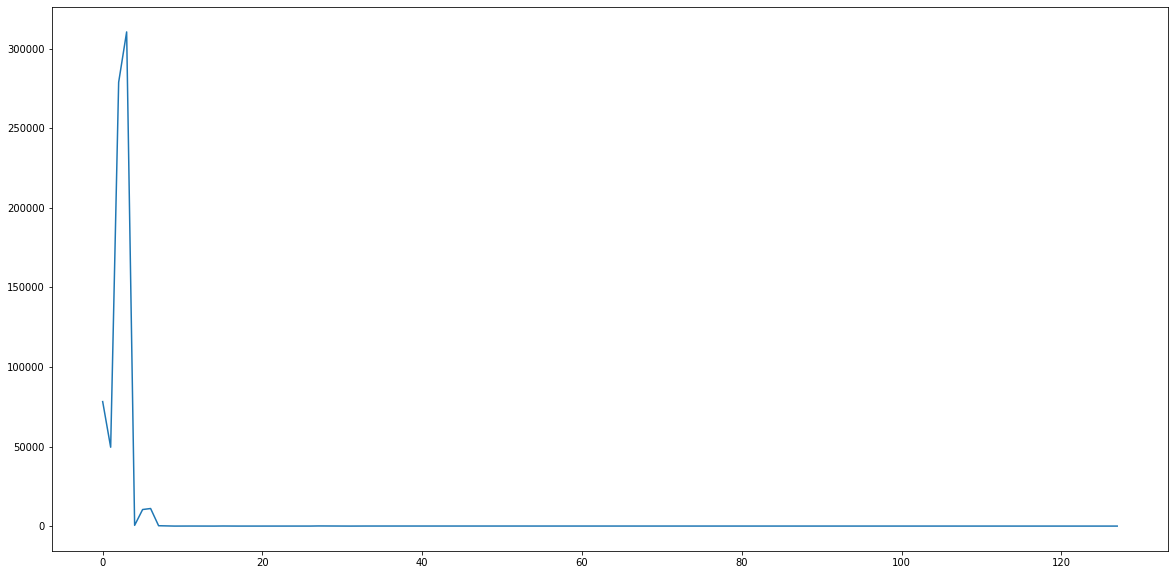

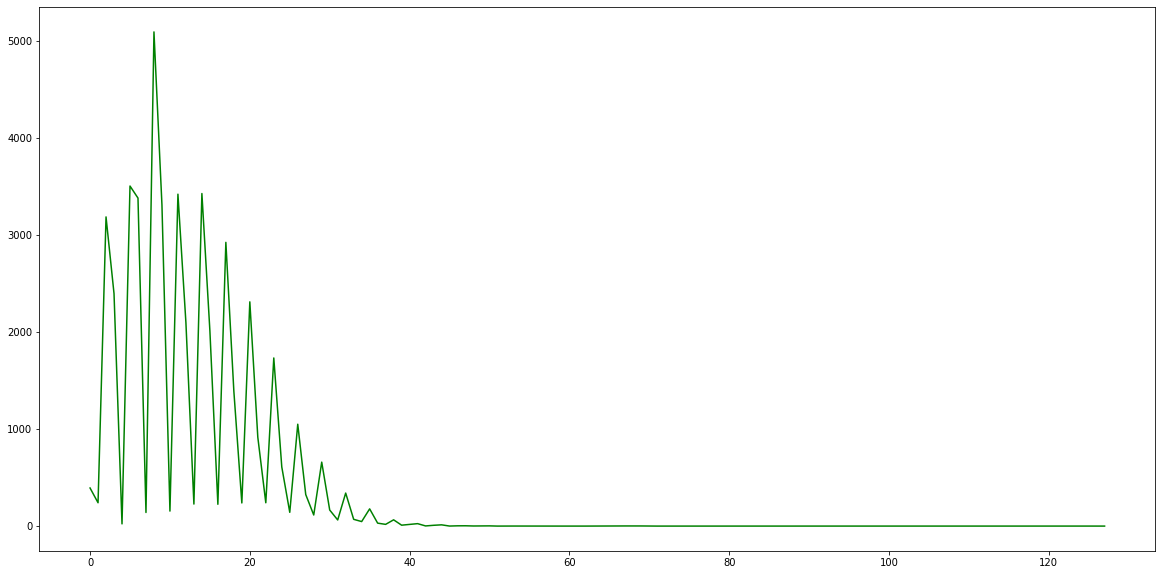

In [5]:
import matplotlib.pyplot as plt


plt.figure(figsize=(20,10), label = 'PPG frequency domain(250Hz)')
plt.plot(fft_p)
plt.xlabel('')

plt.figure(figsize=(20,10))
plt.plot(fft_e, 'g')

#### verifying PPG 250 Hz vs PPG 100Hz

In [18]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal
from scipy.signal import windows
sys.path.append('../DL_model')


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수

    
vital_path = '../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_2min/'
ecg_path = '../../cranberry2/Preprocessing/vital_data/ECG_250Hz_pacu_2min/ECG,'
df_preprocess_pacu = pickle.load(open('cache/preprocess3/input3/df_preprocess_pacu_agender','rb'))
cnt = 0
for _, row in df_preprocess_pacu.iterrows():
    cnt += 1
    print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')

    # vital data - PPG (resampling 100 Hz to 250 Hz)
    df_vital = pickle.load(open(vital_path+row['file_path'], 'rb')).reset_index()
    pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
    pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
    ppg_per_NRS = np.full(30000, np.nan)
    ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
    
    pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[:12000]
    ppg_per_NRS1 = np.full(12000, np.nan)
    ppg_per_NRS1[0:len(pleth_samp)] = pleth_samp    


    # vital data - ECG (250Hz)
    ecg_samp = pickle.load(open(ecg_path+row['file_path'][:-3]+'vital', 'rb')).reset_index()[['ECG']]
    ecg_samp = ecg_samp.fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]
    ecg_per_NRS = np.full(30000,np.nan)
    ecg_per_NRS[0:len(ecg_samp)] = ecg_samp



    # 한 NRS에 대해 23개의 input 확인
    for i in range(30,51):
        SRATE=250
        # input이 전처리 통과한 경우
        if row[str(i+1)]:
            start_idx = i*OVERLAP*SRATE # 500i
            end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000


            # input의 normalization
            ppg_inp = ppg_per_NRS[start_idx:end_idx]
            ecg_inp = ecg_per_NRS[start_idx:end_idx]


            switch = False
            welch_ppg, welch_ecg = [], []
            welch_ppg1 = []

            # 1024/250 의 window size로 1초 간격으로 fft
            SRATE=250
            stride = 1 # 1초
            fft_window_size = 1024  # 약 4초
            n_window = int((LEN_INPUT-fft_window_size/SRATE)/stride) + 1
            for j in range(n_window):

                # welch 작업 - hann window를 씌워주고 fft 적용
                ppg1 = ppg_inp[j*SRATE:j*SRATE + fft_window_size]
                ecg1 = ecg_inp[j*SRATE:j*SRATE + fft_window_size]
                if np.sum(np.isnan(ppg1))!=0 or np.sum(np.isnan(ecg1))!=0:
                    switch = True
                    continue

                #ppg1 = pd.DataFrame(ppg1).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.faltten()
                ppg2 = ppg1 - np.mean(ppg1)
                fft_p = np.fft.fft(ppg2 * windows.hann(fft_window_size))
                fft_p = fft_p[:fft_window_size // 2]
                fft_p = np.reshape(fft_p, (-1, 4)).sum(axis=-1)
                fft_p *= fft_p.conj()

                ecg2 = (ecg1 - np.mean(ecg1)) / np.std(ecg1)
                fft_e = np.fft.fft(ecg2 * windows.hann(fft_window_size))
                fft_e = fft_e[:fft_window_size // 2]
                fft_e = np.reshape(fft_e, (-1, 4)).sum(axis=-1)
                fft_e *= fft_e.conj()

                welch_ppg.append(fft_p)
                welch_ecg.append(fft_e)
                
                
        SRATE=100        
        if row[str(i+1)]:
            start_idx = i*OVERLAP*SRATE # 500i
            end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000
            
            ppg_inp2= ppg_per_NRS1[start_idx:end_idx]
            
            switch = False
            welch_ppg1 = []
            
            # 1024/250 의 window size로 1초 간격으로 fft
            stride = 1 # 1초
            fft_window_size = 512  # 약 4초
            n_window = int((LEN_INPUT-fft_window_size/SRATE)/stride) + 1                                
            for j in range(n_window):

                # welch 작업 - hann window를 씌워주고 fft 적용
                ppg1 = ppg_inp2[j*SRATE:j*SRATE + fft_window_size]
                if np.sum(np.isnan(ppg1))!=0:
                    switch = True
                    continue

                #ppg1 = pd.DataFrame(ppg1).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.faltten()
                ppg2 = ppg1 - np.mean(ppg1)
                fft_p = np.fft.fft(ppg2 * windows.hann(fft_window_size))
                fft_p = fft_p[:fft_window_size // 2]
                fft_p = np.reshape(fft_p, (-1, 2)).sum(axis=-1)
                fft_p *= fft_p.conj()



                welch_ppg1.append(fft_p)
                
                
            print(abc)

loading data 1/7253 ...

NameError: name 'abc' is not defined

In [17]:
welch_ppg = np.array(welch_ppg)
welch_ppg1 = np.array(welch_ppg1)
welch_ppg.shape, welch_ppg1.shape

((16, 128), (15, 64))

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


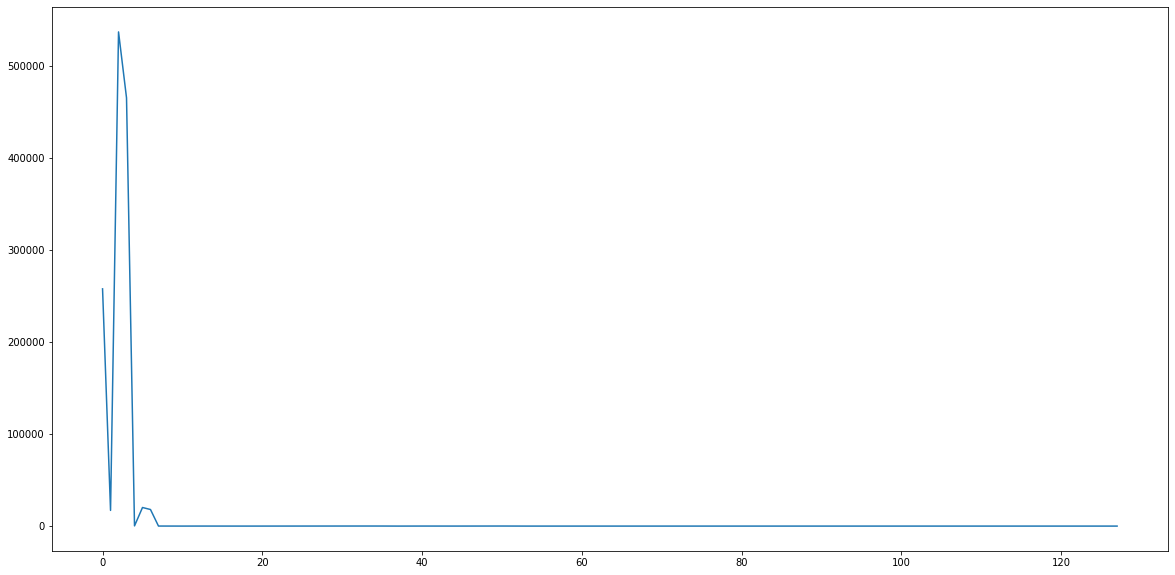

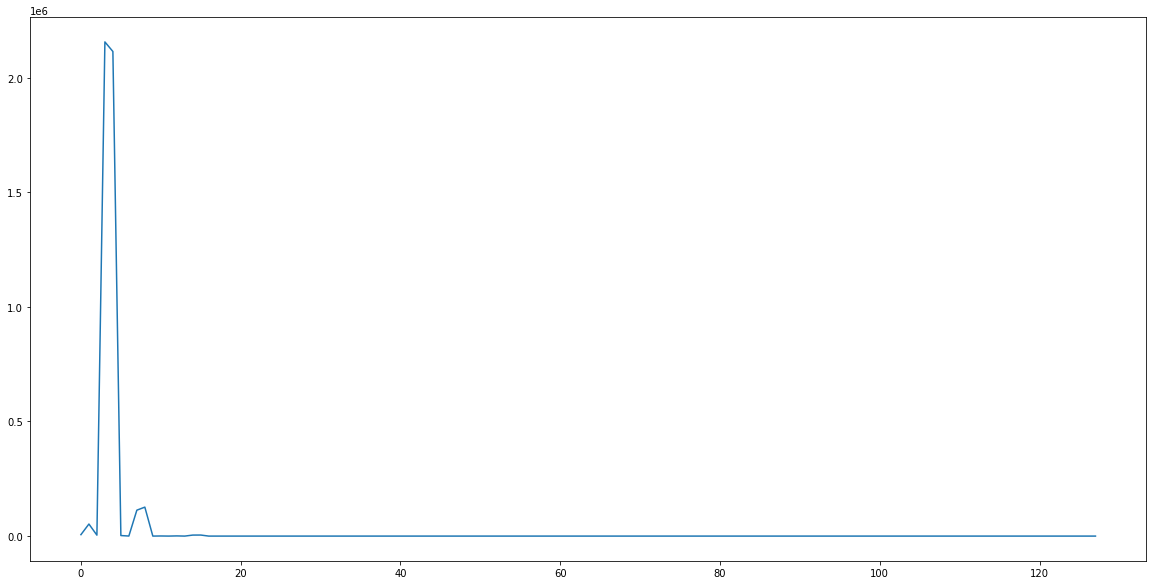

In [26]:
import matplotlib.pyplot as plt

idx=12
plt.figure(figsize=(20,10))
plt.plot(welch_ppg[idx])

plt.figure(figsize=(20,10))
plt.plot(welch_ppg1[idx])

### welch for PPG 100Hz
- preprocess4/welch/PPG_100Hz/ : PPG 100Hz, window size 512/100s, stride 1s

In [2]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal
from scipy.signal import windows
sys.path.append('../DL_model')


### input 설정
SRATE = 100 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수



input_path = 'dataset/preprocess4/welch/PPG_100Hz/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_2min/'
    ecg_path = '../../cranberry2/Preprocessing/vital_data/ECG_250Hz_pacu_2min/ECG,'
    df_preprocess_pacu = pickle.load(open('cache/preprocess3/input3/df_preprocess_pacu_agender','rb'))

    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('caseid_test_new', 'rb'))
    caseid_train = pickle.load(open('caseid_train_new', 'rb'))
    caseid_val = pickle.load(open('caseid_val_new', 'rb'))
    
    non_case = []
    train_mask, val_mask, test_mask = [], [], []
    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []
    x_val_pacu, y_val_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[:12000]
        ppg_per_NRS = np.full(12000, np.nan)
        ppg_per_NRS[0:len(pleth_samp)] = pleth_samp
        
        

        
        # 한 NRS에 대해 23개의 input 확인
        for i in range(30,51):
            # input이 전처리 통과한 경우
            if row[str(i+1)]:
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000
                
                
                # input의 normalization
                ppg_inp = ppg_per_NRS[start_idx:end_idx]
                
                
                switch = False
                welch_ppg, welch_ecg = [], []
                
                # 1024/250 의 window size로 1초 간격으로 fft
                stride = 1 # 1초
                fft_window_size = 512  # 약 4초
                n_window = int((LEN_INPUT-fft_window_size/SRATE)/stride) + 1
                for j in range(n_window):
                    
                    # welch 작업 - hann window를 씌워주고 fft 적용
                    ppg1 = ppg_inp[j*SRATE:j*SRATE + fft_window_size]
                    if np.sum(np.isnan(ppg1))!=0:
                        switch = True
                        continue
                        
                    #ppg1 = pd.DataFrame(ppg1).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.faltten()
                    ppg2 = ppg1 - np.mean(ppg1)
                    fft_p = np.fft.fft(ppg2 * windows.hann(fft_window_size))
                    fft_p = fft_p[:fft_window_size // 2]
                    fft_p = np.reshape(fft_p, (-1, 2)).sum(axis=-1)
                    fft_p *= fft_p.conj()

           
                    welch_ppg.append(fft_p)

                
                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    if switch:
                        test_mask.append(False)
                        continue
                    test_mask.append(True)                    
                    x_test_pacu.append(welch_ppg)
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                elif row['caseids'] in caseid_val:
                    if switch:
                        val_mask.append(False)
                        continue
                    val_mask.append(True)                      
                    x_val_pacu.append(welch_ppg)
                    y_val_pacu.append(int(float(row['NRS'])))
                    
                elif row['caseids'] in caseid_train:
                    if switch:
                        train_mask.append(False)
                        continue
                    train_mask.append(True)                      
                    x_train_pacu.append(welch_ppg)
                    y_train_pacu.append(int(float(row['NRS'])))
                    
                else:
                    non_case.append(row['caseids'])
                    
        print('completed')

    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, int)
    y_test_pacu = np.array(y_test_pacu, int)
    x_val_pacu = np.array(x_val_pacu, np.float32)
    y_val_pacu = np.array(y_val_pacu, int)

    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_pacu.npz', x_train_pacu)
    np.savez_compressed(input_path+'x_test_pacu.npz', x_test_pacu)
    np.savez_compressed(input_path+'x_val_pacu.npz', x_val_pacu)
    np.savez_compressed(input_path+'y_train_pacu.npz', y_train_pacu)
    np.savez_compressed(input_path+'y_test_pacu.npz', y_test_pacu)
    np.savez_compressed(input_path+'y_val_pacu.npz', y_val_pacu)
    print('done', flush=True)

   
    
    
print('size of training set(pacu):', len(x_train_pacu))
print('size of validation set(pacu):', len(x_val_pacu))
print('size of test set(pacu):', len(x_test_pacu))


import pickle


pickle.dump(test_mask, open(input_path+'test_mask_pacu','wb'))
pickle.dump(train_mask, open(input_path+'train_mask_pacu','wb'))
pickle.dump(val_mask, open(input_path+'val_mask_pacu','wb'))

loading data 1/7253 ...completed
loading data 2/7253 ...completed
loading data 3/7253 ...completed
loading data 4/7253 ...completed
loading data 5/7253 ...completed
loading data 6/7253 ...completed
loading data 7/7253 ...completed
loading data 8/7253 ...completed
loading data 9/7253 ...completed
loading data 10/7253 ...completed
loading data 11/7253 ...completed
loading data 12/7253 ...completed
loading data 13/7253 ...completed
loading data 14/7253 ...completed
loading data 15/7253 ...completed
loading data 16/7253 ...completed
loading data 17/7253 ...completed
loading data 18/7253 ...completed
loading data 19/7253 ...completed
loading data 20/7253 ...completed
loading data 21/7253 ...completed
loading data 22/7253 ...completed
loading data 23/7253 ...completed
loading data 24/7253 ...completed
loading data 25/7253 ...completed
loading data 26/7253 ...completed
loading data 27/7253 ...completed
loading data 28/7253 ...completed
loading data 29/7253 ...completed
loading data 30/7253 ..

loading data 472/7253 ...completed
loading data 473/7253 ...completed
loading data 474/7253 ...completed
loading data 475/7253 ...completed
loading data 476/7253 ...completed
loading data 477/7253 ...completed
loading data 478/7253 ...completed
loading data 479/7253 ...completed
loading data 480/7253 ...completed
loading data 481/7253 ...completed
loading data 482/7253 ...completed
loading data 483/7253 ...completed
loading data 484/7253 ...completed
loading data 485/7253 ...completed
loading data 486/7253 ...completed
loading data 487/7253 ...completed
loading data 488/7253 ...completed
loading data 489/7253 ...completed
loading data 490/7253 ...completed
loading data 491/7253 ...completed
loading data 492/7253 ...completed
loading data 493/7253 ...completed
loading data 494/7253 ...completed
loading data 495/7253 ...completed
loading data 496/7253 ...completed
loading data 497/7253 ...completed
loading data 498/7253 ...completed
loading data 499/7253 ...completed
loading data 500/725

loading data 710/7253 ...completed
loading data 711/7253 ...completed
loading data 712/7253 ...completed
loading data 713/7253 ...completed
loading data 714/7253 ...completed
loading data 715/7253 ...completed
loading data 716/7253 ...completed
loading data 717/7253 ...completed
loading data 718/7253 ...completed
loading data 719/7253 ...completed
loading data 720/7253 ...completed
loading data 721/7253 ...completed
loading data 722/7253 ...completed
loading data 723/7253 ...completed
loading data 724/7253 ...completed
loading data 725/7253 ...completed
loading data 726/7253 ...completed
loading data 727/7253 ...completed
loading data 728/7253 ...completed
loading data 729/7253 ...completed
loading data 730/7253 ...completed
loading data 731/7253 ...completed
loading data 732/7253 ...completed
loading data 733/7253 ...completed
loading data 734/7253 ...completed
loading data 735/7253 ...completed
loading data 736/7253 ...completed
loading data 737/7253 ...completed
loading data 738/725

loading data 1177/7253 ...completed
loading data 1178/7253 ...completed
loading data 1179/7253 ...completed
loading data 1180/7253 ...completed
loading data 1181/7253 ...completed
loading data 1182/7253 ...completed
loading data 1183/7253 ...completed
loading data 1184/7253 ...completed
loading data 1185/7253 ...completed
loading data 1186/7253 ...completed
loading data 1187/7253 ...completed
loading data 1188/7253 ...completed
loading data 1189/7253 ...completed
loading data 1190/7253 ...completed
loading data 1191/7253 ...completed
loading data 1192/7253 ...completed
loading data 1193/7253 ...completed
loading data 1194/7253 ...completed
loading data 1195/7253 ...completed
loading data 1196/7253 ...completed
loading data 1197/7253 ...completed
loading data 1198/7253 ...completed
loading data 1199/7253 ...completed
loading data 1200/7253 ...completed
loading data 1201/7253 ...completed
loading data 1202/7253 ...completed
loading data 1203/7253 ...completed
loading data 1204/7253 ...co

loading data 1410/7253 ...completed
loading data 1411/7253 ...completed
loading data 1412/7253 ...completed
loading data 1413/7253 ...completed
loading data 1414/7253 ...completed
loading data 1415/7253 ...completed
loading data 1416/7253 ...completed
loading data 1417/7253 ...completed
loading data 1418/7253 ...completed
loading data 1419/7253 ...completed
loading data 1420/7253 ...completed
loading data 1421/7253 ...completed
loading data 1422/7253 ...completed
loading data 1423/7253 ...completed
loading data 1424/7253 ...completed
loading data 1425/7253 ...completed
loading data 1426/7253 ...completed
loading data 1427/7253 ...completed
loading data 1428/7253 ...completed
loading data 1429/7253 ...completed
loading data 1430/7253 ...completed
loading data 1431/7253 ...completed
loading data 1432/7253 ...completed
loading data 1433/7253 ...completed
loading data 1434/7253 ...completed
loading data 1435/7253 ...completed
loading data 1436/7253 ...completed
loading data 1437/7253 ...co

loading data 1640/7253 ...completed
loading data 1641/7253 ...completed
loading data 1642/7253 ...completed
loading data 1643/7253 ...completed
loading data 1644/7253 ...completed
loading data 1645/7253 ...completed
loading data 1646/7253 ...completed
loading data 1647/7253 ...completed
loading data 1648/7253 ...completed
loading data 1649/7253 ...completed
loading data 1650/7253 ...completed
loading data 1651/7253 ...completed
loading data 1652/7253 ...completed
loading data 1653/7253 ...completed
loading data 1654/7253 ...completed
loading data 1655/7253 ...completed
loading data 1656/7253 ...completed
loading data 1657/7253 ...completed
loading data 1658/7253 ...completed
loading data 1659/7253 ...completed
loading data 1660/7253 ...completed
loading data 1661/7253 ...completed
loading data 1662/7253 ...completed
loading data 1663/7253 ...completed
loading data 1664/7253 ...completed
loading data 1665/7253 ...completed
loading data 1666/7253 ...completed
loading data 1667/7253 ...co

loading data 1872/7253 ...completed
loading data 1873/7253 ...completed
loading data 1874/7253 ...completed
loading data 1875/7253 ...completed
loading data 1876/7253 ...completed
loading data 1877/7253 ...completed
loading data 1878/7253 ...completed
loading data 1879/7253 ...completed
loading data 1880/7253 ...completed
loading data 1881/7253 ...completed
loading data 1882/7253 ...completed
loading data 1883/7253 ...completed
loading data 1884/7253 ...completed
loading data 1885/7253 ...completed
loading data 1886/7253 ...completed
loading data 1887/7253 ...completed
loading data 1888/7253 ...completed
loading data 1889/7253 ...completed
loading data 1890/7253 ...completed
loading data 1891/7253 ...completed
loading data 1892/7253 ...completed
loading data 1893/7253 ...completed
loading data 1894/7253 ...completed
loading data 1895/7253 ...completed
loading data 1896/7253 ...completed
loading data 1897/7253 ...completed
loading data 1898/7253 ...completed
loading data 1899/7253 ...co

loading data 2102/7253 ...completed
loading data 2103/7253 ...completed
loading data 2104/7253 ...completed
loading data 2105/7253 ...completed
loading data 2106/7253 ...completed
loading data 2107/7253 ...completed
loading data 2108/7253 ...completed
loading data 2109/7253 ...completed
loading data 2110/7253 ...completed
loading data 2111/7253 ...completed
loading data 2112/7253 ...completed
loading data 2113/7253 ...completed
loading data 2114/7253 ...completed
loading data 2115/7253 ...completed
loading data 2116/7253 ...completed
loading data 2117/7253 ...completed
loading data 2118/7253 ...completed
loading data 2119/7253 ...completed
loading data 2120/7253 ...completed
loading data 2121/7253 ...completed
loading data 2122/7253 ...completed
loading data 2123/7253 ...completed
loading data 2124/7253 ...completed
loading data 2125/7253 ...completed
loading data 2126/7253 ...completed
loading data 2127/7253 ...completed
loading data 2128/7253 ...completed
loading data 2129/7253 ...co

loading data 2560/7253 ...completed
loading data 2561/7253 ...completed
loading data 2562/7253 ...completed
loading data 2563/7253 ...completed
loading data 2564/7253 ...completed
loading data 2565/7253 ...completed
loading data 2566/7253 ...completed
loading data 2567/7253 ...completed
loading data 2568/7253 ...completed
loading data 2569/7253 ...completed
loading data 2570/7253 ...completed
loading data 2571/7253 ...completed
loading data 2572/7253 ...completed
loading data 2573/7253 ...completed
loading data 2574/7253 ...completed
loading data 2575/7253 ...completed
loading data 2576/7253 ...completed
loading data 2577/7253 ...completed
loading data 2578/7253 ...completed
loading data 2579/7253 ...completed
loading data 2580/7253 ...completed
loading data 2581/7253 ...completed
loading data 2582/7253 ...completed
loading data 2583/7253 ...completed
loading data 2584/7253 ...completed
loading data 2585/7253 ...completed
loading data 2586/7253 ...completed
loading data 2587/7253 ...co

loading data 2790/7253 ...completed
loading data 2791/7253 ...completed
loading data 2792/7253 ...completed
loading data 2793/7253 ...completed
loading data 2794/7253 ...completed
loading data 2795/7253 ...completed
loading data 2796/7253 ...completed
loading data 2797/7253 ...completed
loading data 2798/7253 ...completed
loading data 2799/7253 ...completed
loading data 2800/7253 ...completed
loading data 2801/7253 ...completed
loading data 2802/7253 ...completed
loading data 2803/7253 ...completed
loading data 2804/7253 ...completed
loading data 2805/7253 ...completed
loading data 2806/7253 ...completed
loading data 2807/7253 ...completed
loading data 2808/7253 ...completed
loading data 2809/7253 ...completed
loading data 2810/7253 ...completed
loading data 2811/7253 ...completed
loading data 2812/7253 ...completed
loading data 2813/7253 ...completed
loading data 2814/7253 ...completed
loading data 2815/7253 ...completed
loading data 2816/7253 ...completed
loading data 2817/7253 ...co

loading data 3021/7253 ...completed
loading data 3022/7253 ...completed
loading data 3023/7253 ...completed
loading data 3024/7253 ...completed
loading data 3025/7253 ...completed
loading data 3026/7253 ...completed
loading data 3027/7253 ...completed
loading data 3028/7253 ...completed
loading data 3029/7253 ...completed
loading data 3030/7253 ...completed
loading data 3031/7253 ...completed
loading data 3032/7253 ...completed
loading data 3033/7253 ...completed
loading data 3034/7253 ...completed
loading data 3035/7253 ...completed
loading data 3036/7253 ...completed
loading data 3037/7253 ...completed
loading data 3038/7253 ...completed
loading data 3039/7253 ...completed
loading data 3040/7253 ...completed
loading data 3041/7253 ...completed
loading data 3042/7253 ...completed
loading data 3043/7253 ...completed
loading data 3044/7253 ...completed
loading data 3045/7253 ...completed
loading data 3046/7253 ...completed
loading data 3047/7253 ...completed
loading data 3048/7253 ...co

loading data 3254/7253 ...completed
loading data 3255/7253 ...completed
loading data 3256/7253 ...completed
loading data 3257/7253 ...completed
loading data 3258/7253 ...completed
loading data 3259/7253 ...completed
loading data 3260/7253 ...completed
loading data 3261/7253 ...completed
loading data 3262/7253 ...completed
loading data 3263/7253 ...completed
loading data 3264/7253 ...completed
loading data 3265/7253 ...completed
loading data 3266/7253 ...completed
loading data 3267/7253 ...completed
loading data 3268/7253 ...completed
loading data 3269/7253 ...completed
loading data 3270/7253 ...completed
loading data 3271/7253 ...completed
loading data 3272/7253 ...completed
loading data 3273/7253 ...completed
loading data 3274/7253 ...completed
loading data 3275/7253 ...completed
loading data 3276/7253 ...completed
loading data 3277/7253 ...completed
loading data 3278/7253 ...completed
loading data 3279/7253 ...completed
loading data 3280/7253 ...completed
loading data 3281/7253 ...co

loading data 3710/7253 ...completed
loading data 3711/7253 ...completed
loading data 3712/7253 ...completed
loading data 3713/7253 ...completed
loading data 3714/7253 ...completed
loading data 3715/7253 ...completed
loading data 3716/7253 ...completed
loading data 3717/7253 ...completed
loading data 3718/7253 ...completed
loading data 3719/7253 ...completed
loading data 3720/7253 ...completed
loading data 3721/7253 ...completed
loading data 3722/7253 ...completed
loading data 3723/7253 ...completed
loading data 3724/7253 ...completed
loading data 3725/7253 ...completed
loading data 3726/7253 ...completed
loading data 3727/7253 ...completed
loading data 3728/7253 ...completed
loading data 3729/7253 ...completed
loading data 3730/7253 ...completed
loading data 3731/7253 ...completed
loading data 3732/7253 ...completed
loading data 3733/7253 ...completed
loading data 3734/7253 ...completed
loading data 3735/7253 ...completed
loading data 3736/7253 ...completed
loading data 3737/7253 ...co

loading data 3939/7253 ...completed
loading data 3940/7253 ...completed
loading data 3941/7253 ...completed
loading data 3942/7253 ...completed
loading data 3943/7253 ...completed
loading data 3944/7253 ...completed
loading data 3945/7253 ...completed
loading data 3946/7253 ...completed
loading data 3947/7253 ...completed
loading data 3948/7253 ...completed
loading data 3949/7253 ...completed
loading data 3950/7253 ...completed
loading data 3951/7253 ...completed
loading data 3952/7253 ...completed
loading data 3953/7253 ...completed
loading data 3954/7253 ...completed
loading data 3955/7253 ...completed
loading data 3956/7253 ...completed
loading data 3957/7253 ...completed
loading data 3958/7253 ...completed
loading data 3959/7253 ...completed
loading data 3960/7253 ...completed
loading data 3961/7253 ...completed
loading data 3962/7253 ...completed
loading data 3963/7253 ...completed
loading data 3964/7253 ...completed
loading data 3965/7253 ...completed
loading data 3966/7253 ...co

loading data 4170/7253 ...completed
loading data 4171/7253 ...completed
loading data 4172/7253 ...completed
loading data 4173/7253 ...completed
loading data 4174/7253 ...completed
loading data 4175/7253 ...completed
loading data 4176/7253 ...completed
loading data 4177/7253 ...completed
loading data 4178/7253 ...completed
loading data 4179/7253 ...completed
loading data 4180/7253 ...completed
loading data 4181/7253 ...completed
loading data 4182/7253 ...completed
loading data 4183/7253 ...completed
loading data 4184/7253 ...completed
loading data 4185/7253 ...completed
loading data 4186/7253 ...completed
loading data 4187/7253 ...completed
loading data 4188/7253 ...completed
loading data 4189/7253 ...completed
loading data 4190/7253 ...completed
loading data 4191/7253 ...completed
loading data 4192/7253 ...completed
loading data 4193/7253 ...completed
loading data 4194/7253 ...completed
loading data 4195/7253 ...completed
loading data 4196/7253 ...completed
loading data 4197/7253 ...co

loading data 4399/7253 ...completed
loading data 4400/7253 ...completed
loading data 4401/7253 ...completed
loading data 4402/7253 ...completed
loading data 4403/7253 ...completed
loading data 4404/7253 ...completed
loading data 4405/7253 ...completed
loading data 4406/7253 ...completed
loading data 4407/7253 ...completed
loading data 4408/7253 ...completed
loading data 4409/7253 ...completed
loading data 4410/7253 ...completed
loading data 4411/7253 ...completed
loading data 4412/7253 ...completed
loading data 4413/7253 ...completed
loading data 4414/7253 ...completed
loading data 4415/7253 ...completed
loading data 4416/7253 ...completed
loading data 4417/7253 ...completed
loading data 4418/7253 ...completed
loading data 4419/7253 ...completed
loading data 4420/7253 ...completed
loading data 4421/7253 ...completed
loading data 4422/7253 ...completed
loading data 4423/7253 ...completed
loading data 4424/7253 ...completed
loading data 4425/7253 ...completed
loading data 4426/7253 ...co

loading data 4631/7253 ...completed
loading data 4632/7253 ...completed
loading data 4633/7253 ...completed
loading data 4634/7253 ...completed
loading data 4635/7253 ...completed
loading data 4636/7253 ...completed
loading data 4637/7253 ...completed
loading data 4638/7253 ...completed
loading data 4639/7253 ...completed
loading data 4640/7253 ...completed
loading data 4641/7253 ...completed
loading data 4642/7253 ...completed
loading data 4643/7253 ...completed
loading data 4644/7253 ...completed
loading data 4645/7253 ...completed
loading data 4646/7253 ...completed
loading data 4647/7253 ...completed
loading data 4648/7253 ...completed
loading data 4649/7253 ...completed
loading data 4650/7253 ...completed
loading data 4651/7253 ...completed
loading data 4652/7253 ...completed
loading data 4653/7253 ...completed
loading data 4654/7253 ...completed
loading data 4655/7253 ...completed
loading data 4656/7253 ...completed
loading data 4657/7253 ...completed
loading data 4658/7253 ...co

loading data 4861/7253 ...completed
loading data 4862/7253 ...completed
loading data 4863/7253 ...completed
loading data 4864/7253 ...completed
loading data 4865/7253 ...completed
loading data 4866/7253 ...completed
loading data 4867/7253 ...completed
loading data 4868/7253 ...completed
loading data 4869/7253 ...completed
loading data 4870/7253 ...completed
loading data 4871/7253 ...completed
loading data 4872/7253 ...completed
loading data 4873/7253 ...completed
loading data 4874/7253 ...completed
loading data 4875/7253 ...completed
loading data 4876/7253 ...completed
loading data 4877/7253 ...completed
loading data 4878/7253 ...completed
loading data 4879/7253 ...completed
loading data 4880/7253 ...completed
loading data 4881/7253 ...completed
loading data 4882/7253 ...completed
loading data 4883/7253 ...completed
loading data 4884/7253 ...completed
loading data 4885/7253 ...completed
loading data 4886/7253 ...completed
loading data 4887/7253 ...completed
loading data 4888/7253 ...co

loading data 5318/7253 ...completed
loading data 5319/7253 ...completed
loading data 5320/7253 ...completed
loading data 5321/7253 ...completed
loading data 5322/7253 ...completed
loading data 5323/7253 ...completed
loading data 5324/7253 ...completed
loading data 5325/7253 ...completed
loading data 5326/7253 ...completed
loading data 5327/7253 ...completed
loading data 5328/7253 ...completed
loading data 5329/7253 ...completed
loading data 5330/7253 ...completed
loading data 5331/7253 ...completed
loading data 5332/7253 ...completed
loading data 5333/7253 ...completed
loading data 5334/7253 ...completed
loading data 5335/7253 ...completed
loading data 5336/7253 ...completed
loading data 5337/7253 ...completed
loading data 5338/7253 ...completed
loading data 5339/7253 ...completed
loading data 5340/7253 ...completed
loading data 5341/7253 ...completed
loading data 5342/7253 ...completed
loading data 5343/7253 ...completed
loading data 5344/7253 ...completed
loading data 5345/7253 ...co

loading data 5548/7253 ...completed
loading data 5549/7253 ...completed
loading data 5550/7253 ...completed
loading data 5551/7253 ...completed
loading data 5552/7253 ...completed
loading data 5553/7253 ...completed
loading data 5554/7253 ...completed
loading data 5555/7253 ...completed
loading data 5556/7253 ...completed
loading data 5557/7253 ...completed
loading data 5558/7253 ...completed
loading data 5559/7253 ...completed
loading data 5560/7253 ...completed
loading data 5561/7253 ...completed
loading data 5562/7253 ...completed
loading data 5563/7253 ...completed
loading data 5564/7253 ...completed
loading data 5565/7253 ...completed
loading data 5566/7253 ...completed
loading data 5567/7253 ...completed
loading data 5568/7253 ...completed
loading data 5569/7253 ...completed
loading data 5570/7253 ...completed
loading data 5571/7253 ...completed
loading data 5572/7253 ...completed
loading data 5573/7253 ...completed
loading data 5574/7253 ...completed
loading data 5575/7253 ...co

loading data 5777/7253 ...completed
loading data 5778/7253 ...completed
loading data 5779/7253 ...completed
loading data 5780/7253 ...completed
loading data 5781/7253 ...completed
loading data 5782/7253 ...completed
loading data 5783/7253 ...completed
loading data 5784/7253 ...completed
loading data 5785/7253 ...completed
loading data 5786/7253 ...completed
loading data 5787/7253 ...completed
loading data 5788/7253 ...completed
loading data 5789/7253 ...completed
loading data 5790/7253 ...completed
loading data 5791/7253 ...completed
loading data 5792/7253 ...completed
loading data 5793/7253 ...completed
loading data 5794/7253 ...completed
loading data 5795/7253 ...completed
loading data 5796/7253 ...completed
loading data 5797/7253 ...completed
loading data 5798/7253 ...completed
loading data 5799/7253 ...completed
loading data 5800/7253 ...completed
loading data 5801/7253 ...completed
loading data 5802/7253 ...completed
loading data 5803/7253 ...completed
loading data 5804/7253 ...co

loading data 6014/7253 ...completed
loading data 6015/7253 ...completed
loading data 6016/7253 ...completed
loading data 6017/7253 ...completed
loading data 6018/7253 ...completed
loading data 6019/7253 ...completed
loading data 6020/7253 ...completed
loading data 6021/7253 ...completed
loading data 6022/7253 ...completed
loading data 6023/7253 ...completed
loading data 6024/7253 ...completed
loading data 6025/7253 ...completed
loading data 6026/7253 ...completed
loading data 6027/7253 ...completed
loading data 6028/7253 ...completed
loading data 6029/7253 ...completed
loading data 6030/7253 ...completed
loading data 6031/7253 ...completed
loading data 6032/7253 ...completed
loading data 6033/7253 ...completed
loading data 6034/7253 ...completed
loading data 6035/7253 ...completed
loading data 6036/7253 ...completed
loading data 6037/7253 ...completed
loading data 6038/7253 ...completed
loading data 6039/7253 ...completed
loading data 6040/7253 ...completed
loading data 6041/7253 ...co

loading data 6243/7253 ...completed
loading data 6244/7253 ...completed
loading data 6245/7253 ...completed
loading data 6246/7253 ...completed
loading data 6247/7253 ...completed
loading data 6248/7253 ...completed
loading data 6249/7253 ...completed
loading data 6250/7253 ...completed
loading data 6251/7253 ...completed
loading data 6252/7253 ...completed
loading data 6253/7253 ...completed
loading data 6254/7253 ...completed
loading data 6255/7253 ...completed
loading data 6256/7253 ...completed
loading data 6257/7253 ...completed
loading data 6258/7253 ...completed
loading data 6259/7253 ...completed
loading data 6260/7253 ...completed
loading data 6261/7253 ...completed
loading data 6262/7253 ...completed
loading data 6263/7253 ...completed
loading data 6264/7253 ...completed
loading data 6265/7253 ...completed
loading data 6266/7253 ...completed
loading data 6267/7253 ...completed
loading data 6268/7253 ...completed
loading data 6269/7253 ...completed
loading data 6270/7253 ...co

loading data 6473/7253 ...completed
loading data 6474/7253 ...completed
loading data 6475/7253 ...completed
loading data 6476/7253 ...completed
loading data 6477/7253 ...completed
loading data 6478/7253 ...completed
loading data 6479/7253 ...completed
loading data 6480/7253 ...completed
loading data 6481/7253 ...completed
loading data 6482/7253 ...completed
loading data 6483/7253 ...completed
loading data 6484/7253 ...completed
loading data 6485/7253 ...completed
loading data 6486/7253 ...completed
loading data 6487/7253 ...completed
loading data 6488/7253 ...completed
loading data 6489/7253 ...completed
loading data 6490/7253 ...completed
loading data 6491/7253 ...completed
loading data 6492/7253 ...completed
loading data 6493/7253 ...completed
loading data 6494/7253 ...completed
loading data 6495/7253 ...completed
loading data 6496/7253 ...completed
loading data 6497/7253 ...completed
loading data 6498/7253 ...completed
loading data 6499/7253 ...completed
loading data 6500/7253 ...co

loading data 6702/7253 ...completed
loading data 6703/7253 ...completed
loading data 6704/7253 ...completed
loading data 6705/7253 ...completed
loading data 6706/7253 ...completed
loading data 6707/7253 ...completed
loading data 6708/7253 ...completed
loading data 6709/7253 ...completed
loading data 6710/7253 ...completed
loading data 6711/7253 ...completed
loading data 6712/7253 ...completed
loading data 6713/7253 ...completed
loading data 6714/7253 ...completed
loading data 6715/7253 ...completed
loading data 6716/7253 ...completed
loading data 6717/7253 ...completed
loading data 6718/7253 ...completed
loading data 6719/7253 ...completed
loading data 6720/7253 ...completed
loading data 6721/7253 ...completed
loading data 6722/7253 ...completed
loading data 6723/7253 ...completed
loading data 6724/7253 ...completed
loading data 6725/7253 ...completed
loading data 6726/7253 ...completed
loading data 6727/7253 ...completed
loading data 6728/7253 ...completed
loading data 6729/7253 ...co

loading data 6932/7253 ...completed
loading data 6933/7253 ...completed
loading data 6934/7253 ...completed
loading data 6935/7253 ...completed
loading data 6936/7253 ...completed
loading data 6937/7253 ...completed
loading data 6938/7253 ...completed
loading data 6939/7253 ...completed
loading data 6940/7253 ...completed
loading data 6941/7253 ...completed
loading data 6942/7253 ...completed
loading data 6943/7253 ...completed
loading data 6944/7253 ...completed
loading data 6945/7253 ...completed
loading data 6946/7253 ...completed
loading data 6947/7253 ...completed
loading data 6948/7253 ...completed
loading data 6949/7253 ...completed
loading data 6950/7253 ...completed
loading data 6951/7253 ...completed
loading data 6952/7253 ...completed
loading data 6953/7253 ...completed
loading data 6954/7253 ...completed
loading data 6955/7253 ...completed
loading data 6956/7253 ...completed
loading data 6957/7253 ...completed
loading data 6958/7253 ...completed
loading data 6959/7253 ...co

loading data 7160/7253 ...completed
loading data 7161/7253 ...completed
loading data 7162/7253 ...completed
loading data 7163/7253 ...completed
loading data 7164/7253 ...completed
loading data 7165/7253 ...completed
loading data 7166/7253 ...completed
loading data 7167/7253 ...completed
loading data 7168/7253 ...completed
loading data 7169/7253 ...completed
loading data 7170/7253 ...completed
loading data 7171/7253 ...completed
loading data 7172/7253 ...completed
loading data 7173/7253 ...completed
loading data 7174/7253 ...completed
loading data 7175/7253 ...completed
loading data 7176/7253 ...completed
loading data 7177/7253 ...completed
loading data 7178/7253 ...completed
loading data 7179/7253 ...completed
loading data 7180/7253 ...completed
loading data 7181/7253 ...completed
loading data 7182/7253 ...completed
loading data 7183/7253 ...completed
loading data 7184/7253 ...completed
loading data 7185/7253 ...completed
loading data 7186/7253 ...completed
loading data 7187/7253 ...co

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:133: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:134: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: ComplexWarning: Casting complex values to real discards the imaginary part


saving...done
size of training set(pacu): 63235
size of validation set(pacu): 6720
size of test set(pacu): 7491


###  window size 512/250s (preprocess4/welch2)
- preprocess4/welch2: ECG 250Hz PPG 250Hz, window size 512/250s, stride 1s -> (16, 128)
- preprocess4/welch3: ECG 250Hz PPG 250Hz, window size 512/250s, stride 0.1s -> 

In [2]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal
from scipy.signal import windows
sys.path.append('../DL_model')


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수



input_path = 'dataset/preprocess4/welch3/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_2min/'
    ecg_path = '../../cranberry2/Preprocessing/vital_data/ECG_250Hz_pacu_2min/ECG,'
    df_preprocess_pacu = pickle.load(open('cache/preprocess3/input3/df_preprocess_pacu_agender','rb'))

    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('caseid_test_new', 'rb'))
    caseid_train = pickle.load(open('caseid_train_new', 'rb'))
    caseid_val = pickle.load(open('caseid_val_new', 'rb'))
    
    non_case = []
    train_mask, val_mask, test_mask = [], [], []
    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []
    x_val_pacu, y_val_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        ppg_per_NRS = pd.DataFrame(ppg_per_NRS).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        

        # vital data - ECG (250Hz)
        ecg_samp = pickle.load(open(ecg_path+row['file_path'][:-3]+'vital', 'rb')).reset_index()[['ECG']]
        ecg_samp = ecg_samp.fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]
        ecg_per_NRS = np.full(30000,np.nan)
        ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
        ecg_per_NRS = pd.DataFrame(ecg_per_NRS).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()

        
        # 한 NRS에 대해 23개의 input 확인
        for i in range(30,51):
            # input이 전처리 통과한 경우
            if row[str(i+1)]:
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000
                
                
                # input의 normalization
                ppg_inp = ppg_per_NRS[start_idx:end_idx]
                ecg_inp = ecg_per_NRS[start_idx:end_idx]
                
                
                switch = False
                welch_ppg, welch_ecg = [], []
                
                # 1024/250 의 window size로 1초 간격으로 fft
                stride = 0.1 # 1초
                fft_window_size = 512  # 약 512/250 = 2초
                n_window = int((LEN_INPUT-fft_window_size/SRATE)/stride) + 1
                for j in range(n_window):
                    
                    # welch 작업 - hann window를 씌워주고 fft 적용
                    ppg1 = ppg_inp[int(j*SRATE*stride):int(j*SRATE*stride) + fft_window_size]
                    ecg1 = ecg_inp[int(j*SRATE*stride):int(j*SRATE*stride) + fft_window_size]
                    if np.sum(np.isnan(ppg1))!=0 or np.sum(np.isnan(ecg1))!=0:
                        switch = True
                        continue
                        
                    #ppg1 = pd.DataFrame(ppg1).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.faltten()
                    ppg2 = ppg1 - np.mean(ppg1)
                    fft_p = np.fft.fft(ppg2 * windows.hann(fft_window_size))
                    fft_p = fft_p[:fft_window_size // 2]
                    fft_p = np.reshape(fft_p, (-1, 2)).sum(axis=-1)
                    fft_p *= fft_p.conj()

                    ecg2 = (ecg1 - np.mean(ecg1)) / np.std(ecg1)
                    fft_e = np.fft.fft(ecg2 * windows.hann(fft_window_size))
                    fft_e = fft_e[:fft_window_size // 2]
                    fft_e = np.reshape(fft_e, (-1, 2)).sum(axis=-1)
                    fft_e *= fft_e.conj()
           
                    welch_ppg.append(fft_p)
                    welch_ecg.append(fft_e)

                
                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    if switch:
                        test_mask.append(False)
                        continue
                    test_mask.append(True)                    
                    x_test_pacu.append([welch_ppg, welch_ecg])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                elif row['caseids'] in caseid_val:
                    if switch:
                        val_mask.append(False)
                        continue
                    val_mask.append(True)                      
                    x_val_pacu.append([welch_ppg, welch_ecg])
                    y_val_pacu.append(int(float(row['NRS'])))
                    
                elif row['caseids'] in caseid_train:
                    if switch:
                        train_mask.append(False)
                        continue
                    train_mask.append(True)                      
                    x_train_pacu.append([welch_ppg, welch_ecg])
                    y_train_pacu.append(int(float(row['NRS'])))
                    
                else:
                    non_case.append(row['caseids'])
                    
        print('completed')

    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, int)
    y_test_pacu = np.array(y_test_pacu, int)
    x_val_pacu = np.array(x_val_pacu, np.float32)
    y_val_pacu = np.array(y_val_pacu, int)

    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_pacu.npz', x_train_pacu)
    np.savez_compressed(input_path+'x_test_pacu.npz', x_test_pacu)
    np.savez_compressed(input_path+'x_val_pacu.npz', x_val_pacu)
    np.savez_compressed(input_path+'y_train_pacu.npz', y_train_pacu)
    np.savez_compressed(input_path+'y_test_pacu.npz', y_test_pacu)
    np.savez_compressed(input_path+'y_val_pacu.npz', y_val_pacu)
    print('done', flush=True)

   
    
    
print('size of training set(pacu):', len(x_train_pacu.shape))
print('size of validation set(pacu):', len(x_val_pacu.shape))
print('size of test set(pacu):', len(x_test_pacu.shape))


import pickle


#pickle.dump(test_mask, open(input_path+'test_mask_pacu','wb'))
#pickle.dump(train_mask, open(input_path+'train_mask_pacu','wb'))
#pickle.dump(val_mask, open(input_path+'val_mask_pacu','wb'))

loading data 1/7253 ...completed
loading data 2/7253 ...completed
loading data 3/7253 ...completed
loading data 4/7253 ...completed
loading data 5/7253 ...completed
loading data 6/7253 ...completed
loading data 7/7253 ...completed
loading data 8/7253 ...completed
loading data 9/7253 ...completed
loading data 10/7253 ...completed
loading data 11/7253 ...completed
loading data 12/7253 ...completed
loading data 13/7253 ...completed
loading data 14/7253 ...completed
loading data 15/7253 ...completed
loading data 16/7253 ...completed
loading data 17/7253 ...completed
loading data 18/7253 ...completed
loading data 19/7253 ...completed
loading data 20/7253 ...completed
loading data 21/7253 ...completed
loading data 22/7253 ...completed
loading data 23/7253 ...completed
loading data 24/7253 ...completed
loading data 25/7253 ...completed
loading data 26/7253 ...completed
loading data 27/7253 ...completed
loading data 28/7253 ...completed
loading data 29/7253 ...completed
loading data 30/7253 ..

loading data 472/7253 ...completed
loading data 473/7253 ...completed
loading data 474/7253 ...completed
loading data 475/7253 ...completed
loading data 476/7253 ...completed
loading data 477/7253 ...completed
loading data 478/7253 ...completed
loading data 479/7253 ...completed
loading data 480/7253 ...completed
loading data 481/7253 ...completed
loading data 482/7253 ...completed
loading data 483/7253 ...completed
loading data 484/7253 ...completed
loading data 485/7253 ...completed
loading data 486/7253 ...completed
loading data 487/7253 ...completed
loading data 488/7253 ...completed
loading data 489/7253 ...completed
loading data 490/7253 ...completed
loading data 491/7253 ...completed
loading data 492/7253 ...completed
loading data 493/7253 ...completed
loading data 494/7253 ...completed
loading data 495/7253 ...completed
loading data 496/7253 ...completed
loading data 497/7253 ...completed
loading data 498/7253 ...completed
loading data 499/7253 ...completed
loading data 500/725

loading data 940/7253 ...completed
loading data 941/7253 ...completed
loading data 942/7253 ...completed
loading data 943/7253 ...completed
loading data 944/7253 ...completed
loading data 945/7253 ...completed
loading data 946/7253 ...completed
loading data 947/7253 ...completed
loading data 948/7253 ...completed
loading data 949/7253 ...completed
loading data 950/7253 ...completed
loading data 951/7253 ...completed
loading data 952/7253 ...completed
loading data 953/7253 ...completed
loading data 954/7253 ...completed
loading data 955/7253 ...completed
loading data 956/7253 ...completed
loading data 957/7253 ...completed
loading data 958/7253 ...completed
loading data 959/7253 ...completed
loading data 960/7253 ...completed
loading data 961/7253 ...completed
loading data 962/7253 ...completed
loading data 963/7253 ...completed
loading data 964/7253 ...completed
loading data 965/7253 ...completed
loading data 966/7253 ...completed
loading data 967/7253 ...completed
loading data 968/725

loading data 1172/7253 ...completed
loading data 1173/7253 ...completed
loading data 1174/7253 ...completed
loading data 1175/7253 ...completed
loading data 1176/7253 ...completed
loading data 1177/7253 ...completed
loading data 1178/7253 ...completed
loading data 1179/7253 ...completed
loading data 1180/7253 ...completed
loading data 1181/7253 ...completed
loading data 1182/7253 ...completed
loading data 1183/7253 ...completed
loading data 1184/7253 ...completed
loading data 1185/7253 ...completed
loading data 1186/7253 ...completed
loading data 1187/7253 ...completed
loading data 1188/7253 ...completed
loading data 1189/7253 ...completed
loading data 1190/7253 ...completed
loading data 1191/7253 ...completed
loading data 1192/7253 ...completed
loading data 1193/7253 ...completed
loading data 1194/7253 ...completed
loading data 1195/7253 ...completed
loading data 1196/7253 ...completed
loading data 1197/7253 ...completed
loading data 1198/7253 ...completed
loading data 1199/7253 ...co

loading data 1626/7253 ...completed
loading data 1627/7253 ...completed
loading data 1628/7253 ...completed
loading data 1629/7253 ...completed
loading data 1630/7253 ...completed
loading data 1631/7253 ...completed
loading data 1632/7253 ...completed
loading data 1633/7253 ...completed
loading data 1634/7253 ...completed
loading data 1635/7253 ...completed
loading data 1636/7253 ...completed
loading data 1637/7253 ...completed
loading data 1638/7253 ...completed
loading data 1639/7253 ...completed
loading data 1640/7253 ...completed
loading data 1641/7253 ...completed
loading data 1642/7253 ...completed
loading data 1643/7253 ...completed
loading data 1644/7253 ...completed
loading data 1645/7253 ...completed
loading data 1646/7253 ...completed
loading data 1647/7253 ...completed
loading data 1648/7253 ...completed
loading data 1649/7253 ...completed
loading data 1650/7253 ...completed
loading data 1651/7253 ...completed
loading data 1652/7253 ...completed
loading data 1653/7253 ...co

loading data 1855/7253 ...completed
loading data 1856/7253 ...completed
loading data 1857/7253 ...completed
loading data 1858/7253 ...completed
loading data 1859/7253 ...completed
loading data 1860/7253 ...completed
loading data 1861/7253 ...completed
loading data 1862/7253 ...completed
loading data 1863/7253 ...completed
loading data 1864/7253 ...completed
loading data 1865/7253 ...completed
loading data 1866/7253 ...completed
loading data 1867/7253 ...completed
loading data 1868/7253 ...completed
loading data 1869/7253 ...completed
loading data 1870/7253 ...completed
loading data 1871/7253 ...completed
loading data 1872/7253 ...completed
loading data 1873/7253 ...completed
loading data 1874/7253 ...completed
loading data 1875/7253 ...completed
loading data 1876/7253 ...completed
loading data 1877/7253 ...completed
loading data 1878/7253 ...completed
loading data 1879/7253 ...completed
loading data 1880/7253 ...completed
loading data 1881/7253 ...completed
loading data 1882/7253 ...co

loading data 2309/7253 ...completed
loading data 2310/7253 ...completed
loading data 2311/7253 ...completed
loading data 2312/7253 ...completed
loading data 2313/7253 ...completed
loading data 2314/7253 ...completed
loading data 2315/7253 ...completed
loading data 2316/7253 ...completed
loading data 2317/7253 ...completed
loading data 2318/7253 ...completed
loading data 2319/7253 ...completed
loading data 2320/7253 ...completed
loading data 2321/7253 ...completed
loading data 2322/7253 ...completed
loading data 2323/7253 ...completed
loading data 2324/7253 ...completed
loading data 2325/7253 ...completed
loading data 2326/7253 ...completed
loading data 2327/7253 ...completed
loading data 2328/7253 ...completed
loading data 2329/7253 ...completed
loading data 2330/7253 ...completed
loading data 2331/7253 ...completed
loading data 2332/7253 ...completed
loading data 2333/7253 ...completed
loading data 2334/7253 ...completed
loading data 2335/7253 ...completed
loading data 2336/7253 ...co

loading data 2537/7253 ...completed
loading data 2538/7253 ...completed
loading data 2539/7253 ...completed
loading data 2540/7253 ...completed
loading data 2541/7253 ...completed
loading data 2542/7253 ...completed
loading data 2543/7253 ...completed
loading data 2544/7253 ...completed
loading data 2545/7253 ...completed
loading data 2546/7253 ...completed
loading data 2547/7253 ...completed
loading data 2548/7253 ...completed
loading data 2549/7253 ...completed
loading data 2550/7253 ...completed
loading data 2551/7253 ...completed
loading data 2552/7253 ...completed
loading data 2553/7253 ...completed
loading data 2554/7253 ...completed
loading data 2555/7253 ...completed
loading data 2556/7253 ...completed
loading data 2557/7253 ...completed
loading data 2558/7253 ...completed
loading data 2559/7253 ...completed
loading data 2560/7253 ...completed
loading data 2561/7253 ...completed
loading data 2562/7253 ...completed
loading data 2563/7253 ...completed
loading data 2564/7253 ...co

loading data 2991/7253 ...completed
loading data 2992/7253 ...completed
loading data 2993/7253 ...completed
loading data 2994/7253 ...completed
loading data 2995/7253 ...completed
loading data 2996/7253 ...completed
loading data 2997/7253 ...completed
loading data 2998/7253 ...completed
loading data 2999/7253 ...completed
loading data 3000/7253 ...completed
loading data 3001/7253 ...completed
loading data 3002/7253 ...completed
loading data 3003/7253 ...completed
loading data 3004/7253 ...completed
loading data 3005/7253 ...completed
loading data 3006/7253 ...completed
loading data 3007/7253 ...completed
loading data 3008/7253 ...completed
loading data 3009/7253 ...completed
loading data 3010/7253 ...completed
loading data 3011/7253 ...completed
loading data 3012/7253 ...completed
loading data 3013/7253 ...completed
loading data 3014/7253 ...completed
loading data 3015/7253 ...completed
loading data 3016/7253 ...completed
loading data 3017/7253 ...completed
loading data 3018/7253 ...co

loading data 3219/7253 ...completed
loading data 3220/7253 ...completed
loading data 3221/7253 ...completed
loading data 3222/7253 ...completed
loading data 3223/7253 ...completed
loading data 3224/7253 ...completed
loading data 3225/7253 ...completed
loading data 3226/7253 ...completed
loading data 3227/7253 ...completed
loading data 3228/7253 ...completed
loading data 3229/7253 ...completed
loading data 3230/7253 ...completed
loading data 3231/7253 ...completed
loading data 3232/7253 ...completed
loading data 3233/7253 ...completed
loading data 3234/7253 ...completed
loading data 3235/7253 ...completed
loading data 3236/7253 ...completed
loading data 3237/7253 ...completed
loading data 3238/7253 ...completed
loading data 3239/7253 ...completed
loading data 3240/7253 ...completed
loading data 3241/7253 ...completed
loading data 3242/7253 ...completed
loading data 3243/7253 ...completed
loading data 3244/7253 ...completed
loading data 3245/7253 ...completed
loading data 3246/7253 ...co

loading data 3673/7253 ...completed
loading data 3674/7253 ...completed
loading data 3675/7253 ...completed
loading data 3676/7253 ...completed
loading data 3677/7253 ...completed
loading data 3678/7253 ...completed
loading data 3679/7253 ...completed
loading data 3680/7253 ...completed
loading data 3681/7253 ...completed
loading data 3682/7253 ...completed
loading data 3683/7253 ...completed
loading data 3684/7253 ...completed
loading data 3685/7253 ...completed
loading data 3686/7253 ...completed
loading data 3687/7253 ...completed
loading data 3688/7253 ...completed
loading data 3689/7253 ...completed
loading data 3690/7253 ...completed
loading data 3691/7253 ...completed
loading data 3692/7253 ...completed
loading data 3693/7253 ...completed
loading data 3694/7253 ...completed
loading data 3695/7253 ...completed
loading data 3696/7253 ...completed
loading data 3697/7253 ...completed
loading data 3698/7253 ...completed
loading data 3699/7253 ...completed
loading data 3700/7253 ...co

loading data 3901/7253 ...completed
loading data 3902/7253 ...completed
loading data 3903/7253 ...completed
loading data 3904/7253 ...completed
loading data 3905/7253 ...completed
loading data 3906/7253 ...completed
loading data 3907/7253 ...completed
loading data 3908/7253 ...completed
loading data 3909/7253 ...completed
loading data 3910/7253 ...completed
loading data 3911/7253 ...completed
loading data 3912/7253 ...completed
loading data 3913/7253 ...completed
loading data 3914/7253 ...completed
loading data 3915/7253 ...completed
loading data 3916/7253 ...completed
loading data 3917/7253 ...completed
loading data 3918/7253 ...completed
loading data 3919/7253 ...completed
loading data 3920/7253 ...completed
loading data 3921/7253 ...completed
loading data 3922/7253 ...completed
loading data 3923/7253 ...completed
loading data 3924/7253 ...completed
loading data 3925/7253 ...completed
loading data 3926/7253 ...completed
loading data 3927/7253 ...completed
loading data 3928/7253 ...co

loading data 4129/7253 ...completed
loading data 4130/7253 ...completed
loading data 4131/7253 ...completed
loading data 4132/7253 ...completed
loading data 4133/7253 ...completed
loading data 4134/7253 ...completed
loading data 4135/7253 ...completed
loading data 4136/7253 ...completed
loading data 4137/7253 ...completed
loading data 4138/7253 ...completed
loading data 4139/7253 ...completed
loading data 4140/7253 ...completed
loading data 4141/7253 ...completed
loading data 4142/7253 ...completed
loading data 4143/7253 ...completed
loading data 4144/7253 ...completed
loading data 4145/7253 ...completed
loading data 4146/7253 ...completed
loading data 4147/7253 ...completed
loading data 4148/7253 ...completed
loading data 4149/7253 ...completed
loading data 4150/7253 ...completed
loading data 4151/7253 ...completed
loading data 4152/7253 ...completed
loading data 4153/7253 ...completed
loading data 4154/7253 ...completed
loading data 4155/7253 ...completed
loading data 4156/7253 ...co

loading data 4583/7253 ...completed
loading data 4584/7253 ...completed
loading data 4585/7253 ...completed
loading data 4586/7253 ...completed
loading data 4587/7253 ...completed
loading data 4588/7253 ...completed
loading data 4589/7253 ...completed
loading data 4590/7253 ...completed
loading data 4591/7253 ...completed
loading data 4592/7253 ...completed
loading data 4593/7253 ...completed
loading data 4594/7253 ...completed
loading data 4595/7253 ...completed
loading data 4596/7253 ...completed
loading data 4597/7253 ...completed
loading data 4598/7253 ...completed
loading data 4599/7253 ...completed
loading data 4600/7253 ...completed
loading data 4601/7253 ...completed
loading data 4602/7253 ...completed
loading data 4603/7253 ...completed
loading data 4604/7253 ...completed
loading data 4605/7253 ...completed
loading data 4606/7253 ...completed
loading data 4607/7253 ...completed
loading data 4608/7253 ...completed
loading data 4609/7253 ...completed
loading data 4610/7253 ...co

loading data 4811/7253 ...completed
loading data 4812/7253 ...completed
loading data 4813/7253 ...completed
loading data 4814/7253 ...completed
loading data 4815/7253 ...completed
loading data 4816/7253 ...completed
loading data 4817/7253 ...completed
loading data 4818/7253 ...completed
loading data 4819/7253 ...completed
loading data 4820/7253 ...completed
loading data 4821/7253 ...completed
loading data 4822/7253 ...completed
loading data 4823/7253 ...completed
loading data 4824/7253 ...completed
loading data 4825/7253 ...completed
loading data 4826/7253 ...completed
loading data 4827/7253 ...completed
loading data 4828/7253 ...completed
loading data 4829/7253 ...completed
loading data 4830/7253 ...completed
loading data 4831/7253 ...completed
loading data 4832/7253 ...completed
loading data 4833/7253 ...completed
loading data 4834/7253 ...completed
loading data 4835/7253 ...completed
loading data 4836/7253 ...completed
loading data 4837/7253 ...completed
loading data 4838/7253 ...co

loading data 5039/7253 ...completed
loading data 5040/7253 ...completed
loading data 5041/7253 ...completed
loading data 5042/7253 ...completed
loading data 5043/7253 ...completed
loading data 5044/7253 ...completed
loading data 5045/7253 ...completed
loading data 5046/7253 ...completed
loading data 5047/7253 ...completed
loading data 5048/7253 ...completed
loading data 5049/7253 ...completed
loading data 5050/7253 ...completed
loading data 5051/7253 ...completed
loading data 5052/7253 ...completed
loading data 5053/7253 ...completed
loading data 5054/7253 ...completed
loading data 5055/7253 ...completed
loading data 5056/7253 ...completed
loading data 5057/7253 ...completed
loading data 5058/7253 ...completed
loading data 5059/7253 ...completed
loading data 5060/7253 ...completed
loading data 5061/7253 ...completed
loading data 5062/7253 ...completed
loading data 5063/7253 ...completed
loading data 5064/7253 ...completed
loading data 5065/7253 ...completed
loading data 5066/7253 ...co

loading data 5496/7253 ...completed
loading data 5497/7253 ...completed
loading data 5498/7253 ...completed
loading data 5499/7253 ...completed
loading data 5500/7253 ...completed
loading data 5501/7253 ...completed
loading data 5502/7253 ...completed
loading data 5503/7253 ...completed
loading data 5504/7253 ...completed
loading data 5505/7253 ...completed
loading data 5506/7253 ...completed
loading data 5507/7253 ...completed
loading data 5508/7253 ...completed
loading data 5509/7253 ...completed
loading data 5510/7253 ...completed
loading data 5511/7253 ...completed
loading data 5512/7253 ...completed
loading data 5513/7253 ...completed
loading data 5514/7253 ...completed
loading data 5515/7253 ...completed
loading data 5516/7253 ...completed
loading data 5517/7253 ...completed
loading data 5518/7253 ...completed
loading data 5519/7253 ...completed
loading data 5520/7253 ...completed
loading data 5521/7253 ...completed
loading data 5522/7253 ...completed
loading data 5523/7253 ...co

loading data 5950/7253 ...completed
loading data 5951/7253 ...completed
loading data 5952/7253 ...completed
loading data 5953/7253 ...completed
loading data 5954/7253 ...completed
loading data 5955/7253 ...completed
loading data 5956/7253 ...completed
loading data 5957/7253 ...completed
loading data 5958/7253 ...completed
loading data 5959/7253 ...completed
loading data 5960/7253 ...completed
loading data 5961/7253 ...completed
loading data 5962/7253 ...completed
loading data 5963/7253 ...completed
loading data 5964/7253 ...completed
loading data 5965/7253 ...completed
loading data 5966/7253 ...completed
loading data 5967/7253 ...completed
loading data 5968/7253 ...completed
loading data 5969/7253 ...completed
loading data 5970/7253 ...completed
loading data 5971/7253 ...completed
loading data 5972/7253 ...completed
loading data 5973/7253 ...completed
loading data 5974/7253 ...completed
loading data 5975/7253 ...completed
loading data 5976/7253 ...completed
loading data 5977/7253 ...co

loading data 6179/7253 ...completed
loading data 6180/7253 ...completed
loading data 6181/7253 ...completed
loading data 6182/7253 ...completed
loading data 6183/7253 ...completed
loading data 6184/7253 ...completed
loading data 6185/7253 ...completed
loading data 6186/7253 ...completed
loading data 6187/7253 ...completed
loading data 6188/7253 ...completed
loading data 6189/7253 ...completed
loading data 6190/7253 ...completed
loading data 6191/7253 ...completed
loading data 6192/7253 ...completed
loading data 6193/7253 ...completed
loading data 6194/7253 ...completed
loading data 6195/7253 ...completed
loading data 6196/7253 ...completed
loading data 6197/7253 ...completed
loading data 6198/7253 ...completed
loading data 6199/7253 ...completed
loading data 6200/7253 ...completed
loading data 6201/7253 ...completed
loading data 6202/7253 ...completed
loading data 6203/7253 ...completed
loading data 6204/7253 ...completed
loading data 6205/7253 ...completed
loading data 6206/7253 ...co

loading data 6633/7253 ...completed
loading data 6634/7253 ...completed
loading data 6635/7253 ...completed
loading data 6636/7253 ...completed
loading data 6637/7253 ...completed
loading data 6638/7253 ...completed
loading data 6639/7253 ...completed
loading data 6640/7253 ...completed
loading data 6641/7253 ...completed
loading data 6642/7253 ...completed
loading data 6643/7253 ...completed
loading data 6644/7253 ...completed
loading data 6645/7253 ...completed
loading data 6646/7253 ...completed
loading data 6647/7253 ...completed
loading data 6648/7253 ...completed
loading data 6649/7253 ...completed
loading data 6650/7253 ...completed
loading data 6651/7253 ...completed
loading data 6652/7253 ...completed
loading data 6653/7253 ...completed
loading data 6654/7253 ...completed
loading data 6655/7253 ...completed
loading data 6656/7253 ...completed
loading data 6657/7253 ...completed
loading data 6658/7253 ...completed
loading data 6659/7253 ...completed
loading data 6660/7253 ...co

loading data 7088/7253 ...completed
loading data 7089/7253 ...completed
loading data 7090/7253 ...completed
loading data 7091/7253 ...completed
loading data 7092/7253 ...completed
loading data 7093/7253 ...completed
loading data 7094/7253 ...completed
loading data 7095/7253 ...completed
loading data 7096/7253 ...completed
loading data 7097/7253 ...completed
loading data 7098/7253 ...completed
loading data 7099/7253 ...completed
loading data 7100/7253 ...completed
loading data 7101/7253 ...completed
loading data 7102/7253 ...completed
loading data 7103/7253 ...completed
loading data 7104/7253 ...completed
loading data 7105/7253 ...completed
loading data 7106/7253 ...completed
loading data 7107/7253 ...completed
loading data 7108/7253 ...completed
loading data 7109/7253 ...completed
loading data 7110/7253 ...completed
loading data 7111/7253 ...completed
loading data 7112/7253 ...completed
loading data 7113/7253 ...completed
loading data 7114/7253 ...completed
loading data 7115/7253 ...co

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:149: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:150: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:153: ComplexWarning: Casting complex values to real discards the imaginary part


saving...done
size of training set(pacu): 4
size of validation set(pacu): 4
size of test set(pacu): 4


### Nan 있는 부분의 mask 만들기
- 1D-CNN 모델과 ensemble하기 위해 input을 맞춰야 함.
- welch에선 20초 input에서 전처리 결측치 기준인 10%(2초이하)와 다르게, 20초를 1초씩 20개로 잘라 모두 input이 있어야 하기에 1초 전부 nan인 데이터가 있으면 쓸 수 없음 => welch input 조건에 맞춰서 ensemble할 생각

In [3]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal
from scipy.signal import welch

### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수




input_path = 'dataset/preprocess3/input3-2/welch2/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])


if True:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_2min/'
    ecg_path = '../../cranberry2/Preprocessing/vital_data/ECG_250Hz_pacu_2min/ECG,'
    df_preprocess_pacu = pickle.load(open('cache/preprocess3/input3/df_preprocess_pacu','rb'))
    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('caseid_test', 'rb'))
    caseid_train = pickle.load(open('caseid_train', 'rb'))
    caseid_val = pickle.load(open('caseid_val', 'rb'))
    

    train_mask, val_mask, test_mask = [], [], []
    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []
    x_val_pacu, y_val_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        

        # vital data - ECG (250Hz)
        ecg_samp = pickle.load(open(ecg_path+row['file_path'][:-3]+'vital', 'rb')).reset_index()[['ECG']]
        ecg_samp = ecg_samp.fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]
        ecg_per_NRS = np.full(30000,np.nan)
        ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
   

        
        # 한 NRS에 대해 23개의 input 확인
        for i in range(30,51):
            # input이 전처리 통과한 경우
            if row[str(i+1)]:
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000
                
                # input의 normalization
                ppg_inp = ppg_per_NRS[start_idx:end_idx]
                #pleth_inp = pleth_inp - np.nanmean(pleth_inp)

                ecg_inp = ecg_per_NRS[start_idx:end_idx]
                #ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)
                
                
                switch = False
                welch_ppg, welch_ecg = [], []
                # 1초맏 welch 적용
                for j in range(LEN_INPUT):
                    # ppg의 welch 적용 + 
                    ppg1 = ppg_inp[j*250:(j+1)*250]
                    ppg2 = ppg1 - np.nanmean(ppg1)
                    
                    ecg1 = ecg_inp[j*250:(j+1)*250]
                    ecg2 = (ecg1 - np.nanmean(ecg1)) / np.nanstd(ecg1)
                    
                    welch_p = welch(ppg2, SRATE)[1]
                    welch_e = welch(ecg2,SRATE)[1]
                    
                    
                    # input에 결측치가 있어 welch가 적용 안된 경우
                    if np.sum(np.isnan(welch_p)) !=0 or np.sum(np.isnan(welch_e)) !=0:
                        switch = True
                        
                                                          
                    welch_ppg.append(welch_p)
                    welch_ecg.append(welch_e)
                
                
                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    if switch:
                        test_mask.append(False)
                        continue
                    test_mask.append(True)
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                elif row['caseids'] in caseid_val:
                    if switch:
                        val_mask.append(False)
                        continue
                    val_mask.append(True)
                    y_val_pacu.append(int(float(row['NRS'])))
                    
                else:
                    if switch:
                        train_mask.append(False)
                        continue
                    train_mask.append(True)                    
                    y_train_pacu.append(int(float(row['NRS'])))
                    
        print('completed')



loading data 1/7316 ...completed
loading data 2/7316 ...completed
loading data 3/7316 ...completed
loading data 4/7316 ...completed
loading data 5/7316 ...completed
loading data 6/7316 ...completed
loading data 7/7316 ...completed
loading data 8/7316 ...completed
loading data 9/7316 ...completed
loading data 10/7316 ...completed
loading data 11/7316 ...completed
loading data 12/7316 ...completed
loading data 13/7316 ...completed
loading data 14/7316 ...completed
loading data 15/7316 ...completed
loading data 16/7316 ...completed
loading data 17/7316 ...completed
loading data 18/7316 ...completed
loading data 19/7316 ...completed
loading data 20/7316 ...completed
loading data 21/7316 ...completed
loading data 22/7316 ...completed
loading data 23/7316 ...completed
loading data 24/7316 ...completed
loading data 25/7316 ...completed
loading data 26/7316 ...completed
loading data 27/7316 ...completed
loading data 28/7316 ...completed
loading data 29/7316 ...completed
loading data 30/7316 ..

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


completed
loading data 73/7316 ...completed
loading data 74/7316 ...completed
loading data 75/7316 ...completed
loading data 76/7316 ...completed
loading data 77/7316 ...completed
loading data 78/7316 ...completed
loading data 79/7316 ...completed
loading data 80/7316 ...completed
loading data 81/7316 ...completed
loading data 82/7316 ...completed
loading data 83/7316 ...completed
loading data 84/7316 ...completed
loading data 85/7316 ...completed
loading data 86/7316 ...completed
loading data 87/7316 ...completed
loading data 88/7316 ...completed
loading data 89/7316 ...completed
loading data 90/7316 ...completed
loading data 91/7316 ...completed
loading data 92/7316 ...completed
loading data 93/7316 ...completed
loading data 94/7316 ...completed
loading data 95/7316 ...completed
loading data 96/7316 ...completed
loading data 97/7316 ...completed
loading data 98/7316 ...completed
loading data 99/7316 ...completed
loading data 100/7316 ...completed
loading data 101/7316 ...completed
lo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide


completed
loading data 122/7316 ...completed
loading data 123/7316 ...completed
loading data 124/7316 ...completed
loading data 125/7316 ...completed
loading data 126/7316 ...completed
loading data 127/7316 ...completed
loading data 128/7316 ...completed
loading data 129/7316 ...completed
loading data 130/7316 ...completed
loading data 131/7316 ...completed
loading data 132/7316 ...completed
loading data 133/7316 ...completed
loading data 134/7316 ...completed
loading data 135/7316 ...completed
loading data 136/7316 ...completed
loading data 137/7316 ...completed
loading data 138/7316 ...completed
loading data 139/7316 ...completed
loading data 140/7316 ...completed
loading data 141/7316 ...completed
loading data 142/7316 ...completed
loading data 143/7316 ...completed
loading data 144/7316 ...completed
loading data 145/7316 ...completed
loading data 146/7316 ...completed
loading data 147/7316 ...completed
loading data 148/7316 ...completed
loading data 149/7316 ...completed
loading da

loading data 356/7316 ...completed
loading data 357/7316 ...completed
loading data 358/7316 ...completed
loading data 359/7316 ...completed
loading data 360/7316 ...completed
loading data 361/7316 ...completed
loading data 362/7316 ...completed
loading data 363/7316 ...completed
loading data 364/7316 ...completed
loading data 365/7316 ...completed
loading data 366/7316 ...completed
loading data 367/7316 ...completed
loading data 368/7316 ...completed
loading data 369/7316 ...completed
loading data 370/7316 ...completed
loading data 371/7316 ...completed
loading data 372/7316 ...completed
loading data 373/7316 ...completed
loading data 374/7316 ...completed
loading data 375/7316 ...completed
loading data 376/7316 ...completed
loading data 377/7316 ...completed
loading data 378/7316 ...completed
loading data 379/7316 ...completed
loading data 380/7316 ...completed
loading data 381/7316 ...completed
loading data 382/7316 ...completed
loading data 383/7316 ...completed
loading data 384/731

loading data 824/7316 ...completed
loading data 825/7316 ...completed
loading data 826/7316 ...completed
loading data 827/7316 ...completed
loading data 828/7316 ...completed
loading data 829/7316 ...completed
loading data 830/7316 ...completed
loading data 831/7316 ...completed
loading data 832/7316 ...completed
loading data 833/7316 ...completed
loading data 834/7316 ...completed
loading data 835/7316 ...completed
loading data 836/7316 ...completed
loading data 837/7316 ...completed
loading data 838/7316 ...completed
loading data 839/7316 ...completed
loading data 840/7316 ...completed
loading data 841/7316 ...completed
loading data 842/7316 ...completed
loading data 843/7316 ...completed
loading data 844/7316 ...completed
loading data 845/7316 ...completed
loading data 846/7316 ...completed
loading data 847/7316 ...completed
loading data 848/7316 ...completed
loading data 849/7316 ...completed
loading data 850/7316 ...completed
loading data 851/7316 ...completed
loading data 852/731

loading data 1057/7316 ...completed
loading data 1058/7316 ...completed
loading data 1059/7316 ...completed
loading data 1060/7316 ...completed
loading data 1061/7316 ...completed
loading data 1062/7316 ...completed
loading data 1063/7316 ...completed
loading data 1064/7316 ...completed
loading data 1065/7316 ...completed
loading data 1066/7316 ...completed
loading data 1067/7316 ...completed
loading data 1068/7316 ...completed
loading data 1069/7316 ...completed
loading data 1070/7316 ...completed
loading data 1071/7316 ...completed
loading data 1072/7316 ...completed
loading data 1073/7316 ...completed
loading data 1074/7316 ...completed
loading data 1075/7316 ...completed
loading data 1076/7316 ...completed
loading data 1077/7316 ...completed
loading data 1078/7316 ...completed
loading data 1079/7316 ...completed
loading data 1080/7316 ...completed
loading data 1081/7316 ...completed
loading data 1082/7316 ...completed
loading data 1083/7316 ...completed
loading data 1084/7316 ...co

loading data 1511/7316 ...completed
loading data 1512/7316 ...completed
loading data 1513/7316 ...completed
loading data 1514/7316 ...completed
loading data 1515/7316 ...completed
loading data 1516/7316 ...completed
loading data 1517/7316 ...completed
loading data 1518/7316 ...completed
loading data 1519/7316 ...completed
loading data 1520/7316 ...completed
loading data 1521/7316 ...completed
loading data 1522/7316 ...completed
loading data 1523/7316 ...completed
loading data 1524/7316 ...completed
loading data 1525/7316 ...completed
loading data 1526/7316 ...completed
loading data 1527/7316 ...completed
loading data 1528/7316 ...completed
loading data 1529/7316 ...completed
loading data 1530/7316 ...completed
loading data 1531/7316 ...completed
loading data 1532/7316 ...completed
loading data 1533/7316 ...completed
loading data 1534/7316 ...completed
loading data 1535/7316 ...completed
loading data 1536/7316 ...completed
loading data 1537/7316 ...completed
loading data 1538/7316 ...co

loading data 1965/7316 ...completed
loading data 1966/7316 ...completed
loading data 1967/7316 ...completed
loading data 1968/7316 ...completed
loading data 1969/7316 ...completed
loading data 1970/7316 ...completed
loading data 1971/7316 ...completed
loading data 1972/7316 ...completed
loading data 1973/7316 ...completed
loading data 1974/7316 ...completed
loading data 1975/7316 ...completed
loading data 1976/7316 ...completed
loading data 1977/7316 ...completed
loading data 1978/7316 ...completed
loading data 1979/7316 ...completed
loading data 1980/7316 ...completed
loading data 1981/7316 ...completed
loading data 1982/7316 ...completed
loading data 1983/7316 ...completed
loading data 1984/7316 ...completed
loading data 1985/7316 ...completed
loading data 1986/7316 ...completed
loading data 1987/7316 ...completed
loading data 1988/7316 ...completed
loading data 1989/7316 ...completed
loading data 1990/7316 ...completed
loading data 1991/7316 ...completed
loading data 1992/7316 ...co

loading data 2194/7316 ...completed
loading data 2195/7316 ...completed
loading data 2196/7316 ...completed
loading data 2197/7316 ...completed
loading data 2198/7316 ...completed
loading data 2199/7316 ...completed
loading data 2200/7316 ...completed
loading data 2201/7316 ...completed
loading data 2202/7316 ...completed
loading data 2203/7316 ...completed
loading data 2204/7316 ...completed
loading data 2205/7316 ...completed
loading data 2206/7316 ...completed
loading data 2207/7316 ...completed
loading data 2208/7316 ...completed
loading data 2209/7316 ...completed
loading data 2210/7316 ...completed
loading data 2211/7316 ...completed
loading data 2212/7316 ...completed
loading data 2213/7316 ...completed
loading data 2214/7316 ...completed
loading data 2215/7316 ...completed
loading data 2216/7316 ...completed
loading data 2217/7316 ...completed
loading data 2218/7316 ...completed
loading data 2219/7316 ...completed
loading data 2220/7316 ...completed
loading data 2221/7316 ...co

loading data 2648/7316 ...completed
loading data 2649/7316 ...completed
loading data 2650/7316 ...completed
loading data 2651/7316 ...completed
loading data 2652/7316 ...completed
loading data 2653/7316 ...completed
loading data 2654/7316 ...completed
loading data 2655/7316 ...completed
loading data 2656/7316 ...completed
loading data 2657/7316 ...completed
loading data 2658/7316 ...completed
loading data 2659/7316 ...completed
loading data 2660/7316 ...completed
loading data 2661/7316 ...completed
loading data 2662/7316 ...completed
loading data 2663/7316 ...completed
loading data 2664/7316 ...completed
loading data 2665/7316 ...completed
loading data 2666/7316 ...completed
loading data 2667/7316 ...completed
loading data 2668/7316 ...completed
loading data 2669/7316 ...completed
loading data 2670/7316 ...completed
loading data 2671/7316 ...completed
loading data 2672/7316 ...completed
loading data 2673/7316 ...completed
loading data 2674/7316 ...completed
loading data 2675/7316 ...co

loading data 3102/7316 ...completed
loading data 3103/7316 ...completed
loading data 3104/7316 ...completed
loading data 3105/7316 ...completed
loading data 3106/7316 ...completed
loading data 3107/7316 ...completed
loading data 3108/7316 ...completed
loading data 3109/7316 ...completed
loading data 3110/7316 ...completed
loading data 3111/7316 ...completed
loading data 3112/7316 ...completed
loading data 3113/7316 ...completed
loading data 3114/7316 ...completed
loading data 3115/7316 ...completed
loading data 3116/7316 ...completed
loading data 3117/7316 ...completed
loading data 3118/7316 ...completed
loading data 3119/7316 ...completed
loading data 3120/7316 ...completed
loading data 3121/7316 ...completed
loading data 3122/7316 ...completed
loading data 3123/7316 ...completed
loading data 3124/7316 ...completed
loading data 3125/7316 ...completed
loading data 3126/7316 ...completed
loading data 3127/7316 ...completed
loading data 3128/7316 ...completed
loading data 3129/7316 ...co

loading data 3556/7316 ...completed
loading data 3557/7316 ...completed
loading data 3558/7316 ...completed
loading data 3559/7316 ...completed
loading data 3560/7316 ...completed
loading data 3561/7316 ...completed
loading data 3562/7316 ...completed
loading data 3563/7316 ...completed
loading data 3564/7316 ...completed
loading data 3565/7316 ...completed
loading data 3566/7316 ...completed
loading data 3567/7316 ...completed
loading data 3568/7316 ...completed
loading data 3569/7316 ...completed
loading data 3570/7316 ...completed
loading data 3571/7316 ...completed
loading data 3572/7316 ...completed
loading data 3573/7316 ...completed
loading data 3574/7316 ...completed
loading data 3575/7316 ...completed
loading data 3576/7316 ...completed
loading data 3577/7316 ...completed
loading data 3578/7316 ...completed
loading data 3579/7316 ...completed
loading data 3580/7316 ...completed
loading data 3581/7316 ...completed
loading data 3582/7316 ...completed
loading data 3583/7316 ...co

loading data 4011/7316 ...completed
loading data 4012/7316 ...completed
loading data 4013/7316 ...completed
loading data 4014/7316 ...completed
loading data 4015/7316 ...completed
loading data 4016/7316 ...completed
loading data 4017/7316 ...completed
loading data 4018/7316 ...completed
loading data 4019/7316 ...completed
loading data 4020/7316 ...completed
loading data 4021/7316 ...completed
loading data 4022/7316 ...completed
loading data 4023/7316 ...completed
loading data 4024/7316 ...completed
loading data 4025/7316 ...completed
loading data 4026/7316 ...completed
loading data 4027/7316 ...completed
loading data 4028/7316 ...completed
loading data 4029/7316 ...completed
loading data 4030/7316 ...completed
loading data 4031/7316 ...completed
loading data 4032/7316 ...completed
loading data 4033/7316 ...completed
loading data 4034/7316 ...completed
loading data 4035/7316 ...completed
loading data 4036/7316 ...completed
loading data 4037/7316 ...completed
loading data 4038/7316 ...co

loading data 4467/7316 ...completed
loading data 4468/7316 ...completed
loading data 4469/7316 ...completed
loading data 4470/7316 ...completed
loading data 4471/7316 ...completed
loading data 4472/7316 ...completed
loading data 4473/7316 ...completed
loading data 4474/7316 ...completed
loading data 4475/7316 ...completed
loading data 4476/7316 ...completed
loading data 4477/7316 ...completed
loading data 4478/7316 ...completed
loading data 4479/7316 ...completed
loading data 4480/7316 ...completed
loading data 4481/7316 ...completed
loading data 4482/7316 ...completed
loading data 4483/7316 ...completed
loading data 4484/7316 ...completed
loading data 4485/7316 ...completed
loading data 4486/7316 ...completed
loading data 4487/7316 ...completed
loading data 4488/7316 ...completed
loading data 4489/7316 ...completed
loading data 4490/7316 ...completed
loading data 4491/7316 ...completed
loading data 4492/7316 ...completed
loading data 4493/7316 ...completed
loading data 4494/7316 ...co

loading data 4695/7316 ...completed
loading data 4696/7316 ...completed
loading data 4697/7316 ...completed
loading data 4698/7316 ...completed
loading data 4699/7316 ...completed
loading data 4700/7316 ...completed
loading data 4701/7316 ...completed
loading data 4702/7316 ...completed
loading data 4703/7316 ...completed
loading data 4704/7316 ...completed
loading data 4705/7316 ...completed
loading data 4706/7316 ...completed
loading data 4707/7316 ...completed
loading data 4708/7316 ...completed
loading data 4709/7316 ...completed
loading data 4710/7316 ...completed
loading data 4711/7316 ...completed
loading data 4712/7316 ...completed
loading data 4713/7316 ...completed
loading data 4714/7316 ...completed
loading data 4715/7316 ...completed
loading data 4716/7316 ...completed
loading data 4717/7316 ...completed
loading data 4718/7316 ...completed
loading data 4719/7316 ...completed
loading data 4720/7316 ...completed
loading data 4721/7316 ...completed
loading data 4722/7316 ...co

loading data 5152/7316 ...completed
loading data 5153/7316 ...completed
loading data 5154/7316 ...completed
loading data 5155/7316 ...completed
loading data 5156/7316 ...completed
loading data 5157/7316 ...completed
loading data 5158/7316 ...completed
loading data 5159/7316 ...completed
loading data 5160/7316 ...completed
loading data 5161/7316 ...completed
loading data 5162/7316 ...completed
loading data 5163/7316 ...completed
loading data 5164/7316 ...completed
loading data 5165/7316 ...completed
loading data 5166/7316 ...completed
loading data 5167/7316 ...completed
loading data 5168/7316 ...completed
loading data 5169/7316 ...completed
loading data 5170/7316 ...completed
loading data 5171/7316 ...completed
loading data 5172/7316 ...completed
loading data 5173/7316 ...completed
loading data 5174/7316 ...completed
loading data 5175/7316 ...completed
loading data 5176/7316 ...completed
loading data 5177/7316 ...completed
loading data 5178/7316 ...completed
loading data 5179/7316 ...co

loading data 5381/7316 ...completed
loading data 5382/7316 ...completed
loading data 5383/7316 ...completed
loading data 5384/7316 ...completed
loading data 5385/7316 ...completed
loading data 5386/7316 ...completed
loading data 5387/7316 ...completed
loading data 5388/7316 ...completed
loading data 5389/7316 ...completed
loading data 5390/7316 ...completed
loading data 5391/7316 ...completed
loading data 5392/7316 ...completed
loading data 5393/7316 ...completed
loading data 5394/7316 ...completed
loading data 5395/7316 ...completed
loading data 5396/7316 ...completed
loading data 5397/7316 ...completed
loading data 5398/7316 ...completed
loading data 5399/7316 ...completed
loading data 5400/7316 ...completed
loading data 5401/7316 ...completed
loading data 5402/7316 ...completed
loading data 5403/7316 ...completed
loading data 5404/7316 ...completed
loading data 5405/7316 ...completed
loading data 5406/7316 ...completed
loading data 5407/7316 ...completed
loading data 5408/7316 ...co

loading data 5609/7316 ...completed
loading data 5610/7316 ...completed
loading data 5611/7316 ...completed
loading data 5612/7316 ...completed
loading data 5613/7316 ...completed
loading data 5614/7316 ...completed
loading data 5615/7316 ...completed
loading data 5616/7316 ...completed
loading data 5617/7316 ...completed
loading data 5618/7316 ...completed
loading data 5619/7316 ...completed
loading data 5620/7316 ...completed
loading data 5621/7316 ...completed
loading data 5622/7316 ...completed
loading data 5623/7316 ...completed
loading data 5624/7316 ...completed
loading data 5625/7316 ...completed
loading data 5626/7316 ...completed
loading data 5627/7316 ...completed
loading data 5628/7316 ...completed
loading data 5629/7316 ...completed
loading data 5630/7316 ...completed
loading data 5631/7316 ...completed
loading data 5632/7316 ...completed
loading data 5633/7316 ...completed
loading data 5634/7316 ...completed
loading data 5635/7316 ...completed
loading data 5636/7316 ...co

loading data 6064/7316 ...completed
loading data 6065/7316 ...completed
loading data 6066/7316 ...completed
loading data 6067/7316 ...completed
loading data 6068/7316 ...completed
loading data 6069/7316 ...completed
loading data 6070/7316 ...completed
loading data 6071/7316 ...completed
loading data 6072/7316 ...completed
loading data 6073/7316 ...completed
loading data 6074/7316 ...completed
loading data 6075/7316 ...completed
loading data 6076/7316 ...completed
loading data 6077/7316 ...completed
loading data 6078/7316 ...completed
loading data 6079/7316 ...completed
loading data 6080/7316 ...completed
loading data 6081/7316 ...completed
loading data 6082/7316 ...completed
loading data 6083/7316 ...completed
loading data 6084/7316 ...completed
loading data 6085/7316 ...completed
loading data 6086/7316 ...completed
loading data 6087/7316 ...completed
loading data 6088/7316 ...completed
loading data 6089/7316 ...completed
loading data 6090/7316 ...completed
loading data 6091/7316 ...co

loading data 6519/7316 ...completed
loading data 6520/7316 ...completed
loading data 6521/7316 ...completed
loading data 6522/7316 ...completed
loading data 6523/7316 ...completed
loading data 6524/7316 ...completed
loading data 6525/7316 ...completed
loading data 6526/7316 ...completed
loading data 6527/7316 ...completed
loading data 6528/7316 ...completed
loading data 6529/7316 ...completed
loading data 6530/7316 ...completed
loading data 6531/7316 ...completed
loading data 6532/7316 ...completed
loading data 6533/7316 ...completed
loading data 6534/7316 ...completed
loading data 6535/7316 ...completed
loading data 6536/7316 ...completed
loading data 6537/7316 ...completed
loading data 6538/7316 ...completed
loading data 6539/7316 ...completed
loading data 6540/7316 ...completed
loading data 6541/7316 ...completed
loading data 6542/7316 ...completed
loading data 6543/7316 ...completed
loading data 6544/7316 ...completed
loading data 6545/7316 ...completed
loading data 6546/7316 ...co

loading data 6747/7316 ...completed
loading data 6748/7316 ...completed
loading data 6749/7316 ...completed
loading data 6750/7316 ...completed
loading data 6751/7316 ...completed
loading data 6752/7316 ...completed
loading data 6753/7316 ...completed
loading data 6754/7316 ...completed
loading data 6755/7316 ...completed
loading data 6756/7316 ...completed
loading data 6757/7316 ...completed
loading data 6758/7316 ...completed
loading data 6759/7316 ...completed
loading data 6760/7316 ...completed
loading data 6761/7316 ...completed
loading data 6762/7316 ...completed
loading data 6763/7316 ...completed
loading data 6764/7316 ...completed
loading data 6765/7316 ...completed
loading data 6766/7316 ...completed
loading data 6767/7316 ...completed
loading data 6768/7316 ...completed
loading data 6769/7316 ...completed
loading data 6770/7316 ...completed
loading data 6771/7316 ...completed
loading data 6772/7316 ...completed
loading data 6773/7316 ...completed
loading data 6774/7316 ...co

loading data 6975/7316 ...completed
loading data 6976/7316 ...completed
loading data 6977/7316 ...completed
loading data 6978/7316 ...completed
loading data 6979/7316 ...completed
loading data 6980/7316 ...completed
loading data 6981/7316 ...completed
loading data 6982/7316 ...completed
loading data 6983/7316 ...completed
loading data 6984/7316 ...completed
loading data 6985/7316 ...completed
loading data 6986/7316 ...completed
loading data 6987/7316 ...completed
loading data 6988/7316 ...completed
loading data 6989/7316 ...completed
loading data 6990/7316 ...completed
loading data 6991/7316 ...completed
loading data 6992/7316 ...completed
loading data 6993/7316 ...completed
loading data 6994/7316 ...completed
loading data 6995/7316 ...completed
loading data 6996/7316 ...completed
loading data 6997/7316 ...completed
loading data 6998/7316 ...completed
loading data 6999/7316 ...completed
loading data 7000/7316 ...completed
loading data 7001/7316 ...completed
loading data 7002/7316 ...co

loading data 7205/7316 ...completed
loading data 7206/7316 ...completed
loading data 7207/7316 ...completed
loading data 7208/7316 ...completed
loading data 7209/7316 ...completed
loading data 7210/7316 ...completed
loading data 7211/7316 ...completed
loading data 7212/7316 ...completed
loading data 7213/7316 ...completed
loading data 7214/7316 ...completed
loading data 7215/7316 ...completed
loading data 7216/7316 ...completed
loading data 7217/7316 ...completed
loading data 7218/7316 ...completed
loading data 7219/7316 ...completed
loading data 7220/7316 ...completed
loading data 7221/7316 ...completed
loading data 7222/7316 ...completed
loading data 7223/7316 ...completed
loading data 7224/7316 ...completed
loading data 7225/7316 ...completed
loading data 7226/7316 ...completed
loading data 7227/7316 ...completed
loading data 7228/7316 ...completed
loading data 7229/7316 ...completed
loading data 7230/7316 ...completed
loading data 7231/7316 ...completed
loading data 7232/7316 ...co

#### 원래 input과 welch input의 수 비교

In [4]:
print('test {} -> {}'.format(len(test_mask), np.sum(test_mask)))
print('train {} -> {}'.format(len(train_mask), np.sum(train_mask)))
print('val {} -> {}'.format(len(val_mask), np.sum(val_mask)))

test 7617 -> 7604
train 63700 -> 63659
val 7057 -> 7052


In [5]:
import pickle

pickle.dump(test_mask, open('welch_test_mask_pacu','wb'))
pickle.dump(train_mask, open('welch_train_mask_pacu','wb'))
pickle.dump(val_mask, open('welch_val_mask_pacu','wb'))

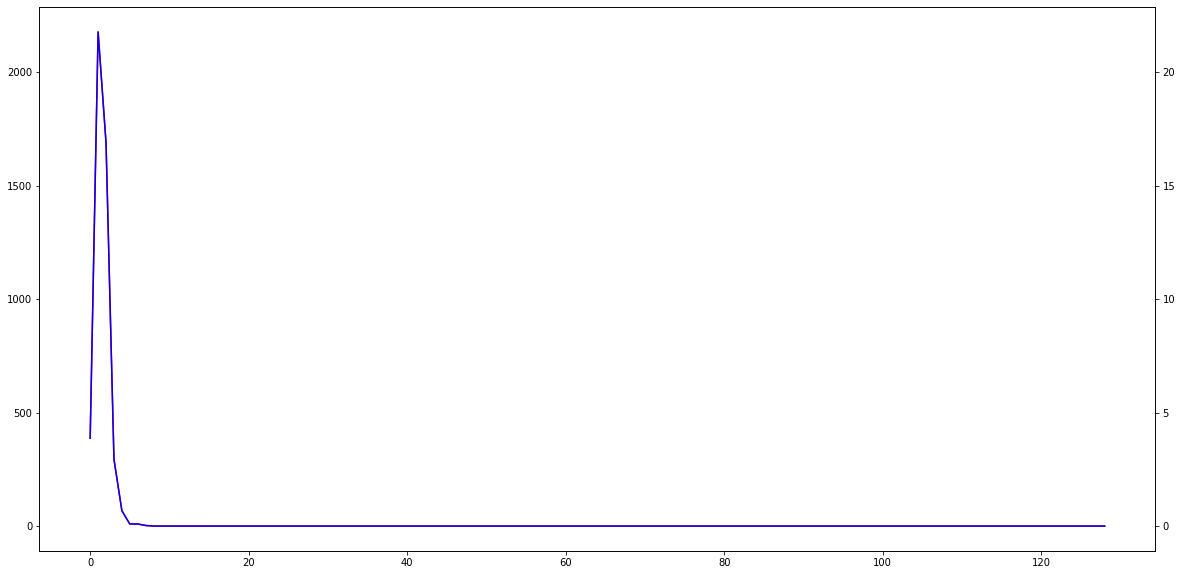

In [52]:
wel1 = welch(pleth_inp, 10)
wel2 = welch(pleth_inp, 250)
wel3 = welch(pleth_inp, 1000)

fig, ax = plt.subplots(figsize=(20,10))
ax2 = ax.twinx()

ax.plot(wel1[1], 'r')
ax2.plot(wel3[1], 'b')

## preop

In [61]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수

non_preop_list = []


input_path = 'dataset/preprocess3/input3-2/welch/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])


if True:
    false_row_list_preop = []
    
    preop_ecg_path = "../../cranberry2/Preprocessing/vital_data/ECG_250Hz_preop_2min/"
    vital_path = '../../cranberry2/Preprocessing/preop_vital/preop'
    df_preprocess_preop = pickle.load(open('cache/preprocess3/input3/df_preprocess_preop','rb'))
    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('caseid_test', 'rb'))
    caseid_train = pickle.load(open('caseid_train', 'rb'))
    caseid_val = pickle.load(open('caseid_val', 'rb'))
    

    x_train_preop, y_train_preop = [], []
    x_test_preop, y_test_preop = [], []
    x_val_preop,y_val_preop = [], []

    cnt = 0
    for _, row in df_preprocess_preop.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_preop)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        
        # vital data - ECG (250Hz)       
        try:
            ecg_samp = pickle.load(open(preop_ecg_path+row['file_path'].split(',')[2], 'rb'))
            
        except:
            non_preop_list.append(row['file_path'])
            print('no preop data')
            continue
        else:
            ecg_samp = pd.DataFrame(ecg_samp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]       
            ecg_per_NRS = np.full(30000,np.nan)
            ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
            
            # 한 NRS에 대해 23개의 input 확인
            for i in range(30,51):
                # input이 전처리 통과한 경우
                if row[str(i+1)]:
                    start_idx = i*OVERLAP*SRATE # 500i
                    end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000


                    # input의 normalization
                    pleth_inp = ppg_per_NRS[start_idx:end_idx]
                    pleth_inp = pleth_inp - np.nanmean(pleth_inp)

                    ecg_inp = ecg_per_NRS[start_idx:end_idx]
                    ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)


                    welch_ppg, welch_ecg = [], []
                    # 1초맏 welch 적용
                    for j in range(LEN_INPUT):
                        welch_ppg.append(welch(pleth_inp[j*250:(j+1)*250],SRATE)[1])
                        welch_ecg.append(welch(ecg_inp[j*250:(j+1)*250],SRATE)[1])


                    # 해당 caseid가 test set에 속하는 경우
                    if row['caseids'] in caseid_test:
                        x_test_preop.append([welch_ppg, welch_ecg])
                        y_test_preop.append(int(float(row['NRS'])))

                    # 해당 caseid가 train set에 해당하는 경우
                    elif row['caseids'] in caseid_val:
                        x_val_preop.append([welch_ppg, welch_ecg])
                        y_val_preop.append(int(float(row['NRS'])))

                    else:
                        x_train_preop.append([welch_ppg, welch_ecg])
                        y_train_preop.append(int(float(row['NRS'])))

            print('completed')


    x_train_preop = np.array(x_train_preop, np.float32)
    x_test_preop = np.array(x_test_preop, np.float32)
    x_val_preop = np.array(x_val_preop, np.float32)
    y_train_preop = np.array(y_train_preop, int)
    y_test_preop = np.array(y_test_preop, int)
    y_val_preop = np.array(y_val_preop, int)

    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_preop.npz', x_train_preop)
    np.savez_compressed(input_path+'x_test_preop.npz', x_test_preop)
    np.savez_compressed(input_path+'x_val_preop.npz', x_val_preop)
    np.savez_compressed(input_path+'y_train_preop.npz', y_train_preop)
    np.savez_compressed(input_path+'y_test_preop.npz', y_test_preop)
    np.savez_compressed(input_path+'y_val_preop.npz', y_val_preop)
    print('done', flush=True)

    
    
    
print('size of training set(preop):', len(x_train_preop))
print('size of validation set(preop):', len(x_val_preop))
print('size of test set(preop):', len(x_test_preop))

loading data 1/3879 ...completed
loading data 2/3879 ...completed
loading data 3/3879 ...completed
loading data 4/3879 ...completed
loading data 5/3879 ...completed
loading data 6/3879 ...completed
loading data 7/3879 ...completed
loading data 8/3879 ...completed
loading data 9/3879 ...completed
loading data 10/3879 ...completed
loading data 11/3879 ...completed
loading data 12/3879 ...completed
loading data 13/3879 ...completed
loading data 14/3879 ...completed
loading data 15/3879 ...completed
loading data 16/3879 ...completed
loading data 17/3879 ...completed
loading data 18/3879 ...completed
loading data 19/3879 ...completed
loading data 20/3879 ...completed
loading data 21/3879 ...completed
loading data 22/3879 ...completed
loading data 23/3879 ...completed
loading data 24/3879 ...completed
loading data 25/3879 ...completed
loading data 26/3879 ...completed
loading data 27/3879 ...completed
loading data 28/3879 ...completed
loading data 29/3879 ...completed
loading data 30/3879 ..

loading data 240/3879 ...completed
loading data 241/3879 ...completed
loading data 242/3879 ...completed
loading data 243/3879 ...completed
loading data 244/3879 ...completed
loading data 245/3879 ...completed
loading data 246/3879 ...completed
loading data 247/3879 ...completed
loading data 248/3879 ...completed
loading data 249/3879 ...completed
loading data 250/3879 ...completed
loading data 251/3879 ...completed
loading data 252/3879 ...completed
loading data 253/3879 ...completed
loading data 254/3879 ...completed
loading data 255/3879 ...completed
loading data 256/3879 ...completed
loading data 257/3879 ...completed
loading data 258/3879 ...completed
loading data 259/3879 ...completed
loading data 260/3879 ...completed
loading data 261/3879 ...completed
loading data 262/3879 ...completed
loading data 263/3879 ...completed
loading data 264/3879 ...completed
loading data 265/3879 ...completed
loading data 266/3879 ...completed
loading data 267/3879 ...completed
loading data 268/387

loading data 477/3879 ...completed
loading data 478/3879 ...completed
loading data 479/3879 ...completed
loading data 480/3879 ...completed
loading data 481/3879 ...completed
loading data 482/3879 ...completed
loading data 483/3879 ...completed
loading data 484/3879 ...completed
loading data 485/3879 ...completed
loading data 486/3879 ...completed
loading data 487/3879 ...completed
loading data 488/3879 ...completed
loading data 489/3879 ...completed
loading data 490/3879 ...completed
loading data 491/3879 ...completed
loading data 492/3879 ...completed
loading data 493/3879 ...completed
loading data 494/3879 ...completed
loading data 495/3879 ...completed
loading data 496/3879 ...completed
loading data 497/3879 ...completed
loading data 498/3879 ...completed
loading data 499/3879 ...completed
loading data 500/3879 ...completed
loading data 501/3879 ...completed
loading data 502/3879 ...completed
loading data 503/3879 ...completed
loading data 504/3879 ...completed
loading data 505/387

loading data 718/3879 ...completed
loading data 719/3879 ...completed
loading data 720/3879 ...completed
loading data 721/3879 ...completed
loading data 722/3879 ...completed
loading data 723/3879 ...completed
loading data 724/3879 ...completed
loading data 725/3879 ...completed
loading data 726/3879 ...completed
loading data 727/3879 ...completed
loading data 728/3879 ...completed
loading data 729/3879 ...completed
loading data 730/3879 ...completed
loading data 731/3879 ...completed
loading data 732/3879 ...completed
loading data 733/3879 ...completed
loading data 734/3879 ...completed
loading data 735/3879 ...completed
loading data 736/3879 ...completed
loading data 737/3879 ...completed
loading data 738/3879 ...completed
loading data 739/3879 ...completed
loading data 740/3879 ...completed
loading data 741/3879 ...completed
loading data 742/3879 ...completed
loading data 743/3879 ...completed
loading data 744/3879 ...completed
loading data 745/3879 ...completed
loading data 746/387

loading data 954/3879 ...completed
loading data 955/3879 ...completed
loading data 956/3879 ...completed
loading data 957/3879 ...completed
loading data 958/3879 ...completed
loading data 959/3879 ...completed
loading data 960/3879 ...completed
loading data 961/3879 ...completed
loading data 962/3879 ...completed
loading data 963/3879 ...completed
loading data 964/3879 ...completed
loading data 965/3879 ...completed
loading data 966/3879 ...completed
loading data 967/3879 ...completed
loading data 968/3879 ...completed
loading data 969/3879 ...completed
loading data 970/3879 ...completed
loading data 971/3879 ...completed
loading data 972/3879 ...completed
loading data 973/3879 ...completed
loading data 974/3879 ...completed
loading data 975/3879 ...completed
loading data 976/3879 ...completed
loading data 977/3879 ...completed
loading data 978/3879 ...completed
loading data 979/3879 ...completed
loading data 980/3879 ...completed
loading data 981/3879 ...completed
loading data 982/387

loading data 1184/3879 ...completed
loading data 1185/3879 ...completed
loading data 1186/3879 ...completed
loading data 1187/3879 ...completed
loading data 1188/3879 ...completed
loading data 1189/3879 ...completed
loading data 1190/3879 ...completed
loading data 1191/3879 ...completed
loading data 1192/3879 ...completed
loading data 1193/3879 ...completed
loading data 1194/3879 ...completed
loading data 1195/3879 ...completed
loading data 1196/3879 ...completed
loading data 1197/3879 ...completed
loading data 1198/3879 ...completed
loading data 1199/3879 ...completed
loading data 1200/3879 ...completed
loading data 1201/3879 ...completed
loading data 1202/3879 ...completed
loading data 1203/3879 ...completed
loading data 1204/3879 ...completed
loading data 1205/3879 ...completed
loading data 1206/3879 ...completed
loading data 1207/3879 ...completed
loading data 1208/3879 ...completed
loading data 1209/3879 ...completed
loading data 1210/3879 ...completed
loading data 1211/3879 ...co

loading data 1640/3879 ...completed
loading data 1641/3879 ...completed
loading data 1642/3879 ...completed
loading data 1643/3879 ...completed
loading data 1644/3879 ...completed
loading data 1645/3879 ...completed
loading data 1646/3879 ...completed
loading data 1647/3879 ...completed
loading data 1648/3879 ...completed
loading data 1649/3879 ...completed
loading data 1650/3879 ...completed
loading data 1651/3879 ...completed
loading data 1652/3879 ...completed
loading data 1653/3879 ...completed
loading data 1654/3879 ...completed
loading data 1655/3879 ...completed
loading data 1656/3879 ...completed
loading data 1657/3879 ...completed
loading data 1658/3879 ...completed
loading data 1659/3879 ...completed
loading data 1660/3879 ...completed
loading data 1661/3879 ...completed
loading data 1662/3879 ...completed
loading data 1663/3879 ...completed
loading data 1664/3879 ...completed
loading data 1665/3879 ...completed
loading data 1666/3879 ...completed
loading data 1667/3879 ...co

loading data 1868/3879 ...completed
loading data 1869/3879 ...completed
loading data 1870/3879 ...completed
loading data 1871/3879 ...completed
loading data 1872/3879 ...completed
loading data 1873/3879 ...completed
loading data 1874/3879 ...completed
loading data 1875/3879 ...completed
loading data 1876/3879 ...completed
loading data 1877/3879 ...completed
loading data 1878/3879 ...completed
loading data 1879/3879 ...completed
loading data 1880/3879 ...completed
loading data 1881/3879 ...completed
loading data 1882/3879 ...completed
loading data 1883/3879 ...completed
loading data 1884/3879 ...completed
loading data 1885/3879 ...completed
loading data 1886/3879 ...completed
loading data 1887/3879 ...completed
loading data 1888/3879 ...completed
loading data 1889/3879 ...completed
loading data 1890/3879 ...completed
loading data 1891/3879 ...completed
loading data 1892/3879 ...completed
loading data 1893/3879 ...completed
loading data 1894/3879 ...completed
loading data 1895/3879 ...co

loading data 2104/3879 ...completed
loading data 2105/3879 ...completed
loading data 2106/3879 ...completed
loading data 2107/3879 ...completed
loading data 2108/3879 ...completed
loading data 2109/3879 ...completed
loading data 2110/3879 ...completed
loading data 2111/3879 ...completed
loading data 2112/3879 ...completed
loading data 2113/3879 ...completed
loading data 2114/3879 ...completed
loading data 2115/3879 ...completed
loading data 2116/3879 ...completed
loading data 2117/3879 ...completed
loading data 2118/3879 ...completed
loading data 2119/3879 ...completed
loading data 2120/3879 ...completed
loading data 2121/3879 ...completed
loading data 2122/3879 ...completed
loading data 2123/3879 ...completed
loading data 2124/3879 ...completed
loading data 2125/3879 ...completed
loading data 2126/3879 ...completed
loading data 2127/3879 ...completed
loading data 2128/3879 ...completed
loading data 2129/3879 ...completed
loading data 2130/3879 ...completed
loading data 2131/3879 ...co

loading data 2558/3879 ...completed
loading data 2559/3879 ...completed
loading data 2560/3879 ...completed
loading data 2561/3879 ...completed
loading data 2562/3879 ...completed
loading data 2563/3879 ...completed
loading data 2564/3879 ...completed
loading data 2565/3879 ...completed
loading data 2566/3879 ...completed
loading data 2567/3879 ...completed
loading data 2568/3879 ...completed
loading data 2569/3879 ...completed
loading data 2570/3879 ...completed
loading data 2571/3879 ...completed
loading data 2572/3879 ...completed
loading data 2573/3879 ...completed
loading data 2574/3879 ...completed
loading data 2575/3879 ...completed
loading data 2576/3879 ...completed
loading data 2577/3879 ...completed
loading data 2578/3879 ...completed
loading data 2579/3879 ...completed
loading data 2580/3879 ...completed
loading data 2581/3879 ...completed
loading data 2582/3879 ...completed
loading data 2583/3879 ...completed
loading data 2584/3879 ...completed
loading data 2585/3879 ...co

loading data 2788/3879 ...completed
loading data 2789/3879 ...completed
loading data 2790/3879 ...completed
loading data 2791/3879 ...completed
loading data 2792/3879 ...completed
loading data 2793/3879 ...completed
loading data 2794/3879 ...completed
loading data 2795/3879 ...completed
loading data 2796/3879 ...completed
loading data 2797/3879 ...completed
loading data 2798/3879 ...completed
loading data 2799/3879 ...completed
loading data 2800/3879 ...completed
loading data 2801/3879 ...completed
loading data 2802/3879 ...completed
loading data 2803/3879 ...completed
loading data 2804/3879 ...completed
loading data 2805/3879 ...completed
loading data 2806/3879 ...completed
loading data 2807/3879 ...completed
loading data 2808/3879 ...completed
loading data 2809/3879 ...completed
loading data 2810/3879 ...completed
loading data 2811/3879 ...completed
loading data 2812/3879 ...completed
loading data 2813/3879 ...completed
loading data 2814/3879 ...completed
loading data 2815/3879 ...co

loading data 3016/3879 ...completed
loading data 3017/3879 ...completed
loading data 3018/3879 ...completed
loading data 3019/3879 ...completed
loading data 3020/3879 ...completed
loading data 3021/3879 ...completed
loading data 3022/3879 ...completed
loading data 3023/3879 ...completed
loading data 3024/3879 ...completed
loading data 3025/3879 ...completed
loading data 3026/3879 ...completed
loading data 3027/3879 ...completed
loading data 3028/3879 ...completed
loading data 3029/3879 ...completed
loading data 3030/3879 ...completed
loading data 3031/3879 ...completed
loading data 3032/3879 ...completed
loading data 3033/3879 ...completed
loading data 3034/3879 ...completed
loading data 3035/3879 ...completed
loading data 3036/3879 ...completed
loading data 3037/3879 ...completed
loading data 3038/3879 ...completed
loading data 3039/3879 ...completed
loading data 3040/3879 ...completed
loading data 3041/3879 ...completed
loading data 3042/3879 ...completed
loading data 3043/3879 ...co

loading data 3244/3879 ...completed
loading data 3245/3879 ...completed
loading data 3246/3879 ...completed
loading data 3247/3879 ...completed
loading data 3248/3879 ...completed
loading data 3249/3879 ...completed
loading data 3250/3879 ...completed
loading data 3251/3879 ...completed
loading data 3252/3879 ...completed
loading data 3253/3879 ...completed
loading data 3254/3879 ...completed
loading data 3255/3879 ...completed
loading data 3256/3879 ...completed
loading data 3257/3879 ...completed
loading data 3258/3879 ...completed
loading data 3259/3879 ...completed
loading data 3260/3879 ...completed
loading data 3261/3879 ...completed
loading data 3262/3879 ...completed
loading data 3263/3879 ...completed
loading data 3264/3879 ...completed
loading data 3265/3879 ...completed
loading data 3266/3879 ...completed
loading data 3267/3879 ...completed
loading data 3268/3879 ...completed
loading data 3269/3879 ...completed
loading data 3270/3879 ...completed
loading data 3271/3879 ...co

loading data 3702/3879 ...completed
loading data 3703/3879 ...completed
loading data 3704/3879 ...completed
loading data 3705/3879 ...completed
loading data 3706/3879 ...completed
loading data 3707/3879 ...completed
loading data 3708/3879 ...completed
loading data 3709/3879 ...completed
loading data 3710/3879 ...completed
loading data 3711/3879 ...completed
loading data 3712/3879 ...completed
loading data 3713/3879 ...completed
loading data 3714/3879 ...completed
loading data 3715/3879 ...completed
loading data 3716/3879 ...completed
loading data 3717/3879 ...completed
loading data 3718/3879 ...completed
loading data 3719/3879 ...completed
loading data 3720/3879 ...completed
loading data 3721/3879 ...completed
loading data 3722/3879 ...completed
loading data 3723/3879 ...completed
loading data 3724/3879 ...completed
loading data 3725/3879 ...completed
loading data 3726/3879 ...completed
loading data 3727/3879 ...completed
loading data 3728/3879 ...completed
loading data 3729/3879 ...co

### preprocess4/welch1 ***

In [5]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수

non_preop_list = []


input_path = 'dataset/preprocess4/welch/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])


if True:
    false_row_list_preop = []
    
    preop_ecg_path = "../../cranberry2/Preprocessing/vital_data/ECG_250Hz_preop_2min/"
    vital_path = '../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_preop_2min/'
    df_preprocess_preop = pickle.load(open('cache/preprocess3/input3/df_preprocess_preop_agender','rb'))
    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('caseid_test_new', 'rb'))
    caseid_train = pickle.load(open('caseid_train_new', 'rb'))
    caseid_val = pickle.load(open('caseid_val_new', 'rb'))
    

    train_mask, val_mask, test_mask = [], [], []
    x_train_preop, y_train_preop = [], []
    x_test_preop, y_test_preop = [], []
    x_val_preop,y_val_preop = [], []

    cnt = 0
    for _, row in df_preprocess_preop.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_preop)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        
        # vital data - ECG (250Hz)       
        try:
            ecg_samp = pickle.load(open(preop_ecg_path+row['file_path'].split(',')[2], 'rb'))
            
        except:
            non_preop_list.append(row['file_path'])
            print('no preop data')
            continue
        else:
            ecg_samp = pd.DataFrame(ecg_samp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]       
            ecg_per_NRS = np.full(30000,np.nan)
            ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
            
            # 한 NRS에 대해 23개의 input 확인
            for i in range(30,51):
                # input이 전처리 통과한 경우
                if row[str(i+1)]:
                    start_idx = i*OVERLAP*SRATE # 500i
                    end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000


                    # input의 normalization
                    ppg_inp = ppg_per_NRS[start_idx:end_idx]
                    #if np.sum(np.isnan(pleth_inp)) != 0:
                        #pleth_inp = (pd.DataFrame(pleth_inp)).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
                    
                    #pleth_inp = pleth_inp - np.nanmean(pleth_inp)

                    ecg_inp = ecg_per_NRS[start_idx:end_idx]
                    #ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)


                    switch = False
                    welch_ppg, welch_ecg = [], []
                    # 1024/250 의 window size로 1초 간격으로 fft
                    stride = 1 # 1초
                    fft_window_size = 1024  # 약 4초
                    n_window = int((LEN_INPUT-fft_window_size/SRATE)/stride) + 1
                    for j in range(n_window):
                        
                        # welch 작업 - hann window를 씌워주고 fft 적용
                        ppg1 = ppg_inp[j*SRATE:j*SRATE + fft_window_size]
                        ecg1 = ecg_inp[j*SRATE:j*SRATE + fft_window_size]
                        if np.sum(np.isnan(ppg1))!=0 or np.sum(np.isnan(ecg1))!=0:
                            switch = True
                            continue

                        #ppg1 = pd.DataFrame(ppg1).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.faltten()
                        ppg2 = ppg1 - np.mean(ppg1)
                        fft_p = np.fft.fft(ppg2 * windows.hann(fft_window_size))
                        fft_p = fft_p[:fft_window_size // 2]
                        fft_p = np.reshape(fft_p, (-1, 4)).sum(axis=-1)
                        fft_p *= fft_p.conj()

                        ecg2 = (ecg1 - np.mean(ecg1)) / np.std(ecg1)
                        fft_e = np.fft.fft(ecg2 * windows.hann(fft_window_size))
                        fft_e = fft_e[:fft_window_size // 2]
                        fft_e = np.reshape(fft_e, (-1, 4)).sum(axis=-1)
                        fft_e *= fft_e.conj()

                        welch_ppg.append(fft_p)
                        welch_ecg.append(fft_e)


                    # 해당 caseid가 test set에 속하는 경우
                    if row['caseids'] in caseid_test:
                        if switch:
                            test_mask.append(False)
                            continue
                        test_mask.append(True)                    
                        x_test_preop.append([welch_ppg, welch_ecg])
                        y_test_preop.append(int(float(row['NRS'])))

                    # 해당 caseid가 train set에 해당하는 경우
                    elif row['caseids'] in caseid_val:
                        if switch:
                            val_mask.append(False)
                            continue
                        val_mask.append(True)                      
                        x_val_preop.append([welch_ppg, welch_ecg])
                        y_val_preop.append(int(float(row['NRS'])))

                    elif row['caseids'] in caseid_train:
                        if switch:
                            train_mask.append(False)
                            continue
                        train_mask.append(True)                      
                        x_train_preop.append([welch_ppg, welch_ecg])
                        y_train_preop.append(int(float(row['NRS'])))
                    
        print('completed')

    x_train_preop = np.array(x_train_preop, np.float32)
    x_test_preop = np.array(x_test_preop, np.float32)
    x_val_preop = np.array(x_val_preop, np.float32)
    y_train_preop = np.array(y_train_preop, int)
    y_test_preop = np.array(y_test_preop, int)
    y_val_preop = np.array(y_val_preop, int)

    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_preop.npz', x_train_preop)
    np.savez_compressed(input_path+'x_test_preop.npz', x_test_preop)
    np.savez_compressed(input_path+'x_val_preop.npz', x_val_preop)
    np.savez_compressed(input_path+'y_train_preop.npz', y_train_preop)
    np.savez_compressed(input_path+'y_test_preop.npz', y_test_preop)
    np.savez_compressed(input_path+'y_val_preop.npz', y_val_preop)
    print('done', flush=True)

    
    
    
print('size of training set(preop):', len(x_train_preop))
print('size of validation set(preop):', len(x_val_preop))
print('size of test set(preop):', len(x_test_preop))


import pickle


pickle.dump(test_mask, open(input_path+'test_mask_preop','wb'))
pickle.dump(train_mask, open(input_path+'train_mask_preop','wb'))
pickle.dump(val_mask, open(input_path+'val_mask_preop','wb'))

loading data 1/3861 ...completed
loading data 2/3861 ...completed
loading data 3/3861 ...completed
loading data 4/3861 ...completed
loading data 5/3861 ...completed
loading data 6/3861 ...completed
loading data 7/3861 ...completed
loading data 8/3861 ...completed
loading data 9/3861 ...completed
loading data 10/3861 ...completed
loading data 11/3861 ...completed
loading data 12/3861 ...completed
loading data 13/3861 ...completed
loading data 14/3861 ...completed
loading data 15/3861 ...completed
loading data 16/3861 ...completed
loading data 17/3861 ...completed
loading data 18/3861 ...completed
loading data 19/3861 ...completed
loading data 20/3861 ...completed
loading data 21/3861 ...completed
loading data 22/3861 ...completed
loading data 23/3861 ...completed
loading data 24/3861 ...completed
loading data 25/3861 ...completed
loading data 26/3861 ...completed
loading data 27/3861 ...completed
loading data 28/3861 ...completed
loading data 29/3861 ...completed
loading data 30/3861 ..

loading data 474/3861 ...completed
loading data 475/3861 ...completed
loading data 476/3861 ...completed
loading data 477/3861 ...completed
loading data 478/3861 ...completed
loading data 479/3861 ...completed
loading data 480/3861 ...completed
loading data 481/3861 ...completed
loading data 482/3861 ...completed
loading data 483/3861 ...completed
loading data 484/3861 ...completed
loading data 485/3861 ...completed
loading data 486/3861 ...completed
loading data 487/3861 ...completed
loading data 488/3861 ...completed
loading data 489/3861 ...completed
loading data 490/3861 ...completed
loading data 491/3861 ...completed
loading data 492/3861 ...completed
loading data 493/3861 ...completed
loading data 494/3861 ...completed
loading data 495/3861 ...completed
loading data 496/3861 ...completed
loading data 497/3861 ...completed
loading data 498/3861 ...completed
loading data 499/3861 ...completed
loading data 500/3861 ...completed
loading data 501/3861 ...completed
loading data 502/386

loading data 713/3861 ...completed
loading data 714/3861 ...completed
loading data 715/3861 ...completed
loading data 716/3861 ...completed
loading data 717/3861 ...completed
loading data 718/3861 ...completed
loading data 719/3861 ...completed
loading data 720/3861 ...completed
loading data 721/3861 ...completed
loading data 722/3861 ...completed
loading data 723/3861 ...completed
loading data 724/3861 ...completed
loading data 725/3861 ...completed
loading data 726/3861 ...completed
loading data 727/3861 ...completed
loading data 728/3861 ...completed
loading data 729/3861 ...completed
loading data 730/3861 ...completed
loading data 731/3861 ...completed
loading data 732/3861 ...completed
loading data 733/3861 ...completed
loading data 734/3861 ...completed
loading data 735/3861 ...completed
loading data 736/3861 ...completed
loading data 737/3861 ...completed
loading data 738/3861 ...completed
loading data 739/3861 ...completed
loading data 740/3861 ...completed
loading data 741/386

loading data 948/3861 ...completed
loading data 949/3861 ...completed
loading data 950/3861 ...completed
loading data 951/3861 ...completed
loading data 952/3861 ...completed
loading data 953/3861 ...completed
loading data 954/3861 ...completed
loading data 955/3861 ...completed
loading data 956/3861 ...completed
loading data 957/3861 ...completed
loading data 958/3861 ...completed
loading data 959/3861 ...completed
loading data 960/3861 ...completed
loading data 961/3861 ...completed
loading data 962/3861 ...completed
loading data 963/3861 ...completed
loading data 964/3861 ...completed
loading data 965/3861 ...completed
loading data 966/3861 ...completed
loading data 967/3861 ...completed
loading data 968/3861 ...completed
loading data 969/3861 ...completed
loading data 970/3861 ...completed
loading data 971/3861 ...completed
loading data 972/3861 ...completed
loading data 973/3861 ...completed
loading data 974/3861 ...completed
loading data 975/3861 ...completed
loading data 976/386

loading data 1179/3861 ...completed
loading data 1180/3861 ...completed
loading data 1181/3861 ...completed
loading data 1182/3861 ...completed
loading data 1183/3861 ...completed
loading data 1184/3861 ...completed
loading data 1185/3861 ...completed
loading data 1186/3861 ...completed
loading data 1187/3861 ...completed
loading data 1188/3861 ...completed
loading data 1189/3861 ...completed
loading data 1190/3861 ...completed
loading data 1191/3861 ...completed
loading data 1192/3861 ...completed
loading data 1193/3861 ...completed
loading data 1194/3861 ...completed
loading data 1195/3861 ...completed
loading data 1196/3861 ...completed
loading data 1197/3861 ...completed
loading data 1198/3861 ...completed
loading data 1199/3861 ...completed
loading data 1200/3861 ...completed
loading data 1201/3861 ...completed
loading data 1202/3861 ...completed
loading data 1203/3861 ...completed
loading data 1204/3861 ...completed
loading data 1205/3861 ...completed
loading data 1206/3861 ...co

loading data 1408/3861 ...completed
loading data 1409/3861 ...completed
loading data 1410/3861 ...completed
loading data 1411/3861 ...completed
loading data 1412/3861 ...completed
loading data 1413/3861 ...completed
loading data 1414/3861 ...completed
loading data 1415/3861 ...completed
loading data 1416/3861 ...completed
loading data 1417/3861 ...completed
loading data 1418/3861 ...completed
loading data 1419/3861 ...completed
loading data 1420/3861 ...completed
loading data 1421/3861 ...completed
loading data 1422/3861 ...completed
loading data 1423/3861 ...completed
loading data 1424/3861 ...completed
loading data 1425/3861 ...completed
loading data 1426/3861 ...completed
loading data 1427/3861 ...completed
loading data 1428/3861 ...completed
loading data 1429/3861 ...completed
loading data 1430/3861 ...completed
loading data 1431/3861 ...completed
loading data 1432/3861 ...completed
loading data 1433/3861 ...completed
loading data 1434/3861 ...completed
loading data 1435/3861 ...co

loading data 1640/3861 ...completed
loading data 1641/3861 ...completed
loading data 1642/3861 ...completed
loading data 1643/3861 ...completed
loading data 1644/3861 ...completed
loading data 1645/3861 ...completed
loading data 1646/3861 ...completed
loading data 1647/3861 ...completed
loading data 1648/3861 ...completed
loading data 1649/3861 ...completed
loading data 1650/3861 ...completed
loading data 1651/3861 ...completed
loading data 1652/3861 ...completed
loading data 1653/3861 ...completed
loading data 1654/3861 ...completed
loading data 1655/3861 ...completed
loading data 1656/3861 ...completed
loading data 1657/3861 ...completed
loading data 1658/3861 ...completed
loading data 1659/3861 ...completed
loading data 1660/3861 ...completed
loading data 1661/3861 ...completed
loading data 1662/3861 ...completed
loading data 1663/3861 ...completed
loading data 1664/3861 ...completed
loading data 1665/3861 ...completed
loading data 1666/3861 ...completed
loading data 1667/3861 ...co

loading data 1869/3861 ...completed
loading data 1870/3861 ...completed
loading data 1871/3861 ...completed
loading data 1872/3861 ...completed
loading data 1873/3861 ...completed
loading data 1874/3861 ...completed
loading data 1875/3861 ...completed
loading data 1876/3861 ...completed
loading data 1877/3861 ...completed
loading data 1878/3861 ...completed
loading data 1879/3861 ...completed
loading data 1880/3861 ...completed
loading data 1881/3861 ...completed
loading data 1882/3861 ...completed
loading data 1883/3861 ...completed
loading data 1884/3861 ...completed
loading data 1885/3861 ...completed
loading data 1886/3861 ...completed
loading data 1887/3861 ...completed
loading data 1888/3861 ...completed
loading data 1889/3861 ...completed
loading data 1890/3861 ...completed
loading data 1891/3861 ...completed
loading data 1892/3861 ...completed
loading data 1893/3861 ...completed
loading data 1894/3861 ...completed
loading data 1895/3861 ...completed
loading data 1896/3861 ...co

loading data 2102/3861 ...completed
loading data 2103/3861 ...completed
loading data 2104/3861 ...completed
loading data 2105/3861 ...completed
loading data 2106/3861 ...completed
loading data 2107/3861 ...completed
loading data 2108/3861 ...completed
loading data 2109/3861 ...completed
loading data 2110/3861 ...completed
loading data 2111/3861 ...completed
loading data 2112/3861 ...completed
loading data 2113/3861 ...completed
loading data 2114/3861 ...completed
loading data 2115/3861 ...completed
loading data 2116/3861 ...completed
loading data 2117/3861 ...completed
loading data 2118/3861 ...completed
loading data 2119/3861 ...completed
loading data 2120/3861 ...completed
loading data 2121/3861 ...completed
loading data 2122/3861 ...completed
loading data 2123/3861 ...completed
loading data 2124/3861 ...completed
loading data 2125/3861 ...completed
loading data 2126/3861 ...completed
loading data 2127/3861 ...completed
loading data 2128/3861 ...completed
loading data 2129/3861 ...co

loading data 2331/3861 ...completed
loading data 2332/3861 ...completed
loading data 2333/3861 ...completed
loading data 2334/3861 ...completed
loading data 2335/3861 ...completed
loading data 2336/3861 ...completed
loading data 2337/3861 ...completed
loading data 2338/3861 ...completed
loading data 2339/3861 ...completed
loading data 2340/3861 ...completed
loading data 2341/3861 ...completed
loading data 2342/3861 ...completed
loading data 2343/3861 ...completed
loading data 2344/3861 ...completed
loading data 2345/3861 ...completed
loading data 2346/3861 ...completed
loading data 2347/3861 ...completed
loading data 2348/3861 ...completed
loading data 2349/3861 ...completed
loading data 2350/3861 ...completed
loading data 2351/3861 ...completed
loading data 2352/3861 ...completed
loading data 2353/3861 ...completed
loading data 2354/3861 ...completed
loading data 2355/3861 ...completed
loading data 2356/3861 ...completed
loading data 2357/3861 ...completed
loading data 2358/3861 ...co

loading data 2559/3861 ...completed
loading data 2560/3861 ...completed
loading data 2561/3861 ...completed
loading data 2562/3861 ...completed
loading data 2563/3861 ...completed
loading data 2564/3861 ...completed
loading data 2565/3861 ...completed
loading data 2566/3861 ...completed
loading data 2567/3861 ...completed
loading data 2568/3861 ...completed
loading data 2569/3861 ...completed
loading data 2570/3861 ...completed
loading data 2571/3861 ...completed
loading data 2572/3861 ...completed
loading data 2573/3861 ...completed
loading data 2574/3861 ...completed
loading data 2575/3861 ...completed
loading data 2576/3861 ...completed
loading data 2577/3861 ...completed
loading data 2578/3861 ...completed
loading data 2579/3861 ...completed
loading data 2580/3861 ...completed
loading data 2581/3861 ...completed
loading data 2582/3861 ...completed
loading data 2583/3861 ...completed
loading data 2584/3861 ...completed
loading data 2585/3861 ...completed
loading data 2586/3861 ...co

loading data 2787/3861 ...completed
loading data 2788/3861 ...completed
loading data 2789/3861 ...completed
loading data 2790/3861 ...completed
loading data 2791/3861 ...completed
loading data 2792/3861 ...completed
loading data 2793/3861 ...completed
loading data 2794/3861 ...completed
loading data 2795/3861 ...completed
loading data 2796/3861 ...completed
loading data 2797/3861 ...completed
loading data 2798/3861 ...completed
loading data 2799/3861 ...completed
loading data 2800/3861 ...completed
loading data 2801/3861 ...completed
loading data 2802/3861 ...completed
loading data 2803/3861 ...completed
loading data 2804/3861 ...completed
loading data 2805/3861 ...completed
loading data 2806/3861 ...completed
loading data 2807/3861 ...completed
loading data 2808/3861 ...completed
loading data 2809/3861 ...completed
loading data 2810/3861 ...completed
loading data 2811/3861 ...completed
loading data 2812/3861 ...completed
loading data 2813/3861 ...completed
loading data 2814/3861 ...co

loading data 3017/3861 ...completed
loading data 3018/3861 ...completed
loading data 3019/3861 ...completed
loading data 3020/3861 ...completed
loading data 3021/3861 ...completed
loading data 3022/3861 ...completed
loading data 3023/3861 ...completed
loading data 3024/3861 ...completed
loading data 3025/3861 ...completed
loading data 3026/3861 ...completed
loading data 3027/3861 ...completed
loading data 3028/3861 ...completed
loading data 3029/3861 ...completed
loading data 3030/3861 ...completed
loading data 3031/3861 ...completed
loading data 3032/3861 ...completed
loading data 3033/3861 ...completed
loading data 3034/3861 ...completed
loading data 3035/3861 ...completed
loading data 3036/3861 ...completed
loading data 3037/3861 ...completed
loading data 3038/3861 ...completed
loading data 3039/3861 ...completed
loading data 3040/3861 ...completed
loading data 3041/3861 ...completed
loading data 3042/3861 ...completed
loading data 3043/3861 ...completed
loading data 3044/3861 ...co

loading data 3252/3861 ...completed
loading data 3253/3861 ...completed
loading data 3254/3861 ...completed
loading data 3255/3861 ...completed
loading data 3256/3861 ...completed
loading data 3257/3861 ...completed
loading data 3258/3861 ...completed
loading data 3259/3861 ...completed
loading data 3260/3861 ...completed
loading data 3261/3861 ...completed
loading data 3262/3861 ...completed
loading data 3263/3861 ...completed
loading data 3264/3861 ...completed
loading data 3265/3861 ...completed
loading data 3266/3861 ...completed
loading data 3267/3861 ...completed
loading data 3268/3861 ...completed
loading data 3269/3861 ...completed
loading data 3270/3861 ...completed
loading data 3271/3861 ...completed
loading data 3272/3861 ...completed
loading data 3273/3861 ...completed
loading data 3274/3861 ...completed
loading data 3275/3861 ...completed
loading data 3276/3861 ...completed
loading data 3277/3861 ...completed
loading data 3278/3861 ...completed
loading data 3279/3861 ...co

loading data 3489/3861 ...completed
loading data 3490/3861 ...completed
loading data 3491/3861 ...completed
loading data 3492/3861 ...completed
loading data 3493/3861 ...completed
loading data 3494/3861 ...completed
loading data 3495/3861 ...completed
loading data 3496/3861 ...completed
loading data 3497/3861 ...completed
loading data 3498/3861 ...completed
loading data 3499/3861 ...completed
loading data 3500/3861 ...completed
loading data 3501/3861 ...completed
loading data 3502/3861 ...completed
loading data 3503/3861 ...completed
loading data 3504/3861 ...completed
loading data 3505/3861 ...completed
loading data 3506/3861 ...completed
loading data 3507/3861 ...completed
loading data 3508/3861 ...completed
loading data 3509/3861 ...completed
loading data 3510/3861 ...completed
loading data 3511/3861 ...completed
loading data 3512/3861 ...completed
loading data 3513/3861 ...completed
loading data 3514/3861 ...completed
loading data 3515/3861 ...completed
loading data 3516/3861 ...co

loading data 3720/3861 ...completed
loading data 3721/3861 ...completed
loading data 3722/3861 ...completed
loading data 3723/3861 ...completed
loading data 3724/3861 ...completed
loading data 3725/3861 ...completed
loading data 3726/3861 ...completed
loading data 3727/3861 ...completed
loading data 3728/3861 ...completed
loading data 3729/3861 ...completed
loading data 3730/3861 ...completed
loading data 3731/3861 ...completed
loading data 3732/3861 ...completed
loading data 3733/3861 ...completed
loading data 3734/3861 ...completed
loading data 3735/3861 ...completed
loading data 3736/3861 ...completed
loading data 3737/3861 ...completed
loading data 3738/3861 ...completed
loading data 3739/3861 ...completed
loading data 3740/3861 ...completed
loading data 3741/3861 ...completed
loading data 3742/3861 ...completed
loading data 3743/3861 ...completed
loading data 3744/3861 ...completed
loading data 3745/3861 ...completed
loading data 3746/3861 ...completed
loading data 3747/3861 ...co

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:145: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:146: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:147: ComplexWarning: Casting complex values to real discards the imaginary part


saving...done
size of training set(preop): 11380
size of validation set(preop): 1231
size of test set(preop): 1298


### welch for PPG 100Hz

In [7]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal


### input 설정
SRATE = 100 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수

non_preop_list = []


input_path = 'dataset/preprocess4/welch/PPG_100Hz/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])


if True:
    false_row_list_preop = []
    
    preop_ecg_path = "../../cranberry2/Preprocessing/vital_data/ECG_250Hz_preop_2min/"
    vital_path = '../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_preop_2min/'
    df_preprocess_preop = pickle.load(open('cache/preprocess3/input3/df_preprocess_preop_agender','rb'))
    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('caseid_test_new', 'rb'))
    caseid_train = pickle.load(open('caseid_train_new', 'rb'))
    caseid_val = pickle.load(open('caseid_val_new', 'rb'))
    

    train_mask, val_mask, test_mask = [], [], []
    x_train_preop, y_train_preop = [], []
    x_test_preop, y_test_preop = [], []
    x_val_preop,y_val_preop = [], []

    cnt = 0
    for _, row in df_preprocess_preop.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_preop)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[:12000]
        ppg_per_NRS = np.full(12000, np.nan)
        ppg_per_NRS[0:len(pleth_samp)] = pleth_samp
        
    
        
        # 한 NRS에 대해 23개의 input 확인
        for i in range(30,51):
            # input이 전처리 통과한 경우
            if row[str(i+1)]:
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000
                
                
                # input의 normalization
                ppg_inp = ppg_per_NRS[start_idx:end_idx]
                
                
                switch = False
                welch_ppg, welch_ecg = [], []
                
                # 1024/250 의 window size로 1초 간격으로 fft
                stride = 1 # 1초
                fft_window_size = 512  # 약 4초
                n_window = int((LEN_INPUT-fft_window_size/SRATE)/stride) + 1
                for j in range(n_window):
                    
                    # welch 작업 - hann window를 씌워주고 fft 적용
                    ppg1 = ppg_inp[j*SRATE:j*SRATE + fft_window_size]
                    if np.sum(np.isnan(ppg1))!=0:
                        switch = True
                        continue
                        
                    #ppg1 = pd.DataFrame(ppg1).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.faltten()
                    ppg2 = ppg1 - np.mean(ppg1)
                    fft_p = np.fft.fft(ppg2 * windows.hann(fft_window_size))
                    fft_p = fft_p[:fft_window_size // 2]
                    fft_p = np.reshape(fft_p, (-1, 2)).sum(axis=-1)
                    fft_p *= fft_p.conj()

           
                    welch_ppg.append(fft_p)


                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    if switch:
                        test_mask.append(False)
                        continue
                    test_mask.append(True)                    
                    x_test_preop.append(welch_ppg)
                    y_test_preop.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                elif row['caseids'] in caseid_val:
                    if switch:
                        val_mask.append(False)
                        continue
                    val_mask.append(True)                      
                    x_val_preop.append(welch_ppg)
                    y_val_preop.append(int(float(row['NRS'])))

                elif row['caseids'] in caseid_train:
                    if switch:
                        train_mask.append(False)
                        continue
                    train_mask.append(True)                      
                    x_train_preop.append(welch_ppg)
                    y_train_preop.append(int(float(row['NRS'])))
                    
        print('completed')

    x_train_preop = np.array(x_train_preop, np.float32)
    x_test_preop = np.array(x_test_preop, np.float32)
    x_val_preop = np.array(x_val_preop, np.float32)
    y_train_preop = np.array(y_train_preop, int)
    y_test_preop = np.array(y_test_preop, int)
    y_val_preop = np.array(y_val_preop, int)

    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_preop.npz', x_train_preop)
    np.savez_compressed(input_path+'x_test_preop.npz', x_test_preop)
    np.savez_compressed(input_path+'x_val_preop.npz', x_val_preop)
    np.savez_compressed(input_path+'y_train_preop.npz', y_train_preop)
    np.savez_compressed(input_path+'y_test_preop.npz', y_test_preop)
    np.savez_compressed(input_path+'y_val_preop.npz', y_val_preop)
    print('done', flush=True)

    
    
    
print('size of training set(preop):', len(x_train_preop))
print('size of validation set(preop):', len(x_val_preop))
print('size of test set(preop):', len(x_test_preop))


import pickle


pickle.dump(test_mask, open(input_path+'test_mask_preop','wb'))
pickle.dump(train_mask, open(input_path+'train_mask_preop','wb'))
pickle.dump(val_mask, open(input_path+'val_mask_preop','wb'))

loading data 1/3861 ...completed
loading data 2/3861 ...completed
loading data 3/3861 ...completed
loading data 4/3861 ...completed
loading data 5/3861 ...completed
loading data 6/3861 ...completed
loading data 7/3861 ...completed
loading data 8/3861 ...completed
loading data 9/3861 ...completed
loading data 10/3861 ...completed
loading data 11/3861 ...completed
loading data 12/3861 ...completed
loading data 13/3861 ...completed
loading data 14/3861 ...completed
loading data 15/3861 ...completed
loading data 16/3861 ...completed
loading data 17/3861 ...completed
loading data 18/3861 ...completed
loading data 19/3861 ...completed
loading data 20/3861 ...completed
loading data 21/3861 ...completed
loading data 22/3861 ...completed
loading data 23/3861 ...completed
loading data 24/3861 ...completed
loading data 25/3861 ...completed
loading data 26/3861 ...completed
loading data 27/3861 ...completed
loading data 28/3861 ...completed
loading data 29/3861 ...completed
loading data 30/3861 ..

loading data 477/3861 ...completed
loading data 478/3861 ...completed
loading data 479/3861 ...completed
loading data 480/3861 ...completed
loading data 481/3861 ...completed
loading data 482/3861 ...completed
loading data 483/3861 ...completed
loading data 484/3861 ...completed
loading data 485/3861 ...completed
loading data 486/3861 ...completed
loading data 487/3861 ...completed
loading data 488/3861 ...completed
loading data 489/3861 ...completed
loading data 490/3861 ...completed
loading data 491/3861 ...completed
loading data 492/3861 ...completed
loading data 493/3861 ...completed
loading data 494/3861 ...completed
loading data 495/3861 ...completed
loading data 496/3861 ...completed
loading data 497/3861 ...completed
loading data 498/3861 ...completed
loading data 499/3861 ...completed
loading data 500/3861 ...completed
loading data 501/3861 ...completed
loading data 502/3861 ...completed
loading data 503/3861 ...completed
loading data 504/3861 ...completed
loading data 505/386

loading data 714/3861 ...completed
loading data 715/3861 ...completed
loading data 716/3861 ...completed
loading data 717/3861 ...completed
loading data 718/3861 ...completed
loading data 719/3861 ...completed
loading data 720/3861 ...completed
loading data 721/3861 ...completed
loading data 722/3861 ...completed
loading data 723/3861 ...completed
loading data 724/3861 ...completed
loading data 725/3861 ...completed
loading data 726/3861 ...completed
loading data 727/3861 ...completed
loading data 728/3861 ...completed
loading data 729/3861 ...completed
loading data 730/3861 ...completed
loading data 731/3861 ...completed
loading data 732/3861 ...completed
loading data 733/3861 ...completed
loading data 734/3861 ...completed
loading data 735/3861 ...completed
loading data 736/3861 ...completed
loading data 737/3861 ...completed
loading data 738/3861 ...completed
loading data 739/3861 ...completed
loading data 740/3861 ...completed
loading data 741/3861 ...completed
loading data 742/386

loading data 952/3861 ...completed
loading data 953/3861 ...completed
loading data 954/3861 ...completed
loading data 955/3861 ...completed
loading data 956/3861 ...completed
loading data 957/3861 ...completed
loading data 958/3861 ...completed
loading data 959/3861 ...completed
loading data 960/3861 ...completed
loading data 961/3861 ...completed
loading data 962/3861 ...completed
loading data 963/3861 ...completed
loading data 964/3861 ...completed
loading data 965/3861 ...completed
loading data 966/3861 ...completed
loading data 967/3861 ...completed
loading data 968/3861 ...completed
loading data 969/3861 ...completed
loading data 970/3861 ...completed
loading data 971/3861 ...completed
loading data 972/3861 ...completed
loading data 973/3861 ...completed
loading data 974/3861 ...completed
loading data 975/3861 ...completed
loading data 976/3861 ...completed
loading data 977/3861 ...completed
loading data 978/3861 ...completed
loading data 979/3861 ...completed
loading data 980/386

loading data 1181/3861 ...completed
loading data 1182/3861 ...completed
loading data 1183/3861 ...completed
loading data 1184/3861 ...completed
loading data 1185/3861 ...completed
loading data 1186/3861 ...completed
loading data 1187/3861 ...completed
loading data 1188/3861 ...completed
loading data 1189/3861 ...completed
loading data 1190/3861 ...completed
loading data 1191/3861 ...completed
loading data 1192/3861 ...completed
loading data 1193/3861 ...completed
loading data 1194/3861 ...completed
loading data 1195/3861 ...completed
loading data 1196/3861 ...completed
loading data 1197/3861 ...completed
loading data 1198/3861 ...completed
loading data 1199/3861 ...completed
loading data 1200/3861 ...completed
loading data 1201/3861 ...completed
loading data 1202/3861 ...completed
loading data 1203/3861 ...completed
loading data 1204/3861 ...completed
loading data 1205/3861 ...completed
loading data 1206/3861 ...completed
loading data 1207/3861 ...completed
loading data 1208/3861 ...co

loading data 1417/3861 ...completed
loading data 1418/3861 ...completed
loading data 1419/3861 ...completed
loading data 1420/3861 ...completed
loading data 1421/3861 ...completed
loading data 1422/3861 ...completed
loading data 1423/3861 ...completed
loading data 1424/3861 ...completed
loading data 1425/3861 ...completed
loading data 1426/3861 ...completed
loading data 1427/3861 ...completed
loading data 1428/3861 ...completed
loading data 1429/3861 ...completed
loading data 1430/3861 ...completed
loading data 1431/3861 ...completed
loading data 1432/3861 ...completed
loading data 1433/3861 ...completed
loading data 1434/3861 ...completed
loading data 1435/3861 ...completed
loading data 1436/3861 ...completed
loading data 1437/3861 ...completed
loading data 1438/3861 ...completed
loading data 1439/3861 ...completed
loading data 1440/3861 ...completed
loading data 1441/3861 ...completed
loading data 1442/3861 ...completed
loading data 1443/3861 ...completed
loading data 1444/3861 ...co

loading data 1653/3861 ...completed
loading data 1654/3861 ...completed
loading data 1655/3861 ...completed
loading data 1656/3861 ...completed
loading data 1657/3861 ...completed
loading data 1658/3861 ...completed
loading data 1659/3861 ...completed
loading data 1660/3861 ...completed
loading data 1661/3861 ...completed
loading data 1662/3861 ...completed
loading data 1663/3861 ...completed
loading data 1664/3861 ...completed
loading data 1665/3861 ...completed
loading data 1666/3861 ...completed
loading data 1667/3861 ...completed
loading data 1668/3861 ...completed
loading data 1669/3861 ...completed
loading data 1670/3861 ...completed
loading data 1671/3861 ...completed
loading data 1672/3861 ...completed
loading data 1673/3861 ...completed
loading data 1674/3861 ...completed
loading data 1675/3861 ...completed
loading data 1676/3861 ...completed
loading data 1677/3861 ...completed
loading data 1678/3861 ...completed
loading data 1679/3861 ...completed
loading data 1680/3861 ...co

loading data 1881/3861 ...completed
loading data 1882/3861 ...completed
loading data 1883/3861 ...completed
loading data 1884/3861 ...completed
loading data 1885/3861 ...completed
loading data 1886/3861 ...completed
loading data 1887/3861 ...completed
loading data 1888/3861 ...completed
loading data 1889/3861 ...completed
loading data 1890/3861 ...completed
loading data 1891/3861 ...completed
loading data 1892/3861 ...completed
loading data 1893/3861 ...completed
loading data 1894/3861 ...completed
loading data 1895/3861 ...completed
loading data 1896/3861 ...completed
loading data 1897/3861 ...completed
loading data 1898/3861 ...completed
loading data 1899/3861 ...completed
loading data 1900/3861 ...completed
loading data 1901/3861 ...completed
loading data 1902/3861 ...completed
loading data 1903/3861 ...completed
loading data 1904/3861 ...completed
loading data 1905/3861 ...completed
loading data 1906/3861 ...completed
loading data 1907/3861 ...completed
loading data 1908/3861 ...co

loading data 2115/3861 ...completed
loading data 2116/3861 ...completed
loading data 2117/3861 ...completed
loading data 2118/3861 ...completed
loading data 2119/3861 ...completed
loading data 2120/3861 ...completed
loading data 2121/3861 ...completed
loading data 2122/3861 ...completed
loading data 2123/3861 ...completed
loading data 2124/3861 ...completed
loading data 2125/3861 ...completed
loading data 2126/3861 ...completed
loading data 2127/3861 ...completed
loading data 2128/3861 ...completed
loading data 2129/3861 ...completed
loading data 2130/3861 ...completed
loading data 2131/3861 ...completed
loading data 2132/3861 ...completed
loading data 2133/3861 ...completed
loading data 2134/3861 ...completed
loading data 2135/3861 ...completed
loading data 2136/3861 ...completed
loading data 2137/3861 ...completed
loading data 2138/3861 ...completed
loading data 2139/3861 ...completed
loading data 2140/3861 ...completed
loading data 2141/3861 ...completed
loading data 2142/3861 ...co

loading data 2346/3861 ...completed
loading data 2347/3861 ...completed
loading data 2348/3861 ...completed
loading data 2349/3861 ...completed
loading data 2350/3861 ...completed
loading data 2351/3861 ...completed
loading data 2352/3861 ...completed
loading data 2353/3861 ...completed
loading data 2354/3861 ...completed
loading data 2355/3861 ...completed
loading data 2356/3861 ...completed
loading data 2357/3861 ...completed
loading data 2358/3861 ...completed
loading data 2359/3861 ...completed
loading data 2360/3861 ...completed
loading data 2361/3861 ...completed
loading data 2362/3861 ...completed
loading data 2363/3861 ...completed
loading data 2364/3861 ...completed
loading data 2365/3861 ...completed
loading data 2366/3861 ...completed
loading data 2367/3861 ...completed
loading data 2368/3861 ...completed
loading data 2369/3861 ...completed
loading data 2370/3861 ...completed
loading data 2371/3861 ...completed
loading data 2372/3861 ...completed
loading data 2373/3861 ...co

loading data 2579/3861 ...completed
loading data 2580/3861 ...completed
loading data 2581/3861 ...completed
loading data 2582/3861 ...completed
loading data 2583/3861 ...completed
loading data 2584/3861 ...completed
loading data 2585/3861 ...completed
loading data 2586/3861 ...completed
loading data 2587/3861 ...completed
loading data 2588/3861 ...completed
loading data 2589/3861 ...completed
loading data 2590/3861 ...completed
loading data 2591/3861 ...completed
loading data 2592/3861 ...completed
loading data 2593/3861 ...completed
loading data 2594/3861 ...completed
loading data 2595/3861 ...completed
loading data 2596/3861 ...completed
loading data 2597/3861 ...completed
loading data 2598/3861 ...completed
loading data 2599/3861 ...completed
loading data 2600/3861 ...completed
loading data 2601/3861 ...completed
loading data 2602/3861 ...completed
loading data 2603/3861 ...completed
loading data 2604/3861 ...completed
loading data 2605/3861 ...completed
loading data 2606/3861 ...co

loading data 2811/3861 ...completed
loading data 2812/3861 ...completed
loading data 2813/3861 ...completed
loading data 2814/3861 ...completed
loading data 2815/3861 ...completed
loading data 2816/3861 ...completed
loading data 2817/3861 ...completed
loading data 2818/3861 ...completed
loading data 2819/3861 ...completed
loading data 2820/3861 ...completed
loading data 2821/3861 ...completed
loading data 2822/3861 ...completed
loading data 2823/3861 ...completed
loading data 2824/3861 ...completed
loading data 2825/3861 ...completed
loading data 2826/3861 ...completed
loading data 2827/3861 ...completed
loading data 2828/3861 ...completed
loading data 2829/3861 ...completed
loading data 2830/3861 ...completed
loading data 2831/3861 ...completed
loading data 2832/3861 ...completed
loading data 2833/3861 ...completed
loading data 2834/3861 ...completed
loading data 2835/3861 ...completed
loading data 2836/3861 ...completed
loading data 2837/3861 ...completed
loading data 2838/3861 ...co

loading data 3040/3861 ...completed
loading data 3041/3861 ...completed
loading data 3042/3861 ...completed
loading data 3043/3861 ...completed
loading data 3044/3861 ...completed
loading data 3045/3861 ...completed
loading data 3046/3861 ...completed
loading data 3047/3861 ...completed
loading data 3048/3861 ...completed
loading data 3049/3861 ...completed
loading data 3050/3861 ...completed
loading data 3051/3861 ...completed
loading data 3052/3861 ...completed
loading data 3053/3861 ...completed
loading data 3054/3861 ...completed
loading data 3055/3861 ...completed
loading data 3056/3861 ...completed
loading data 3057/3861 ...completed
loading data 3058/3861 ...completed
loading data 3059/3861 ...completed
loading data 3060/3861 ...completed
loading data 3061/3861 ...completed
loading data 3062/3861 ...completed
loading data 3063/3861 ...completed
loading data 3064/3861 ...completed
loading data 3065/3861 ...completed
loading data 3066/3861 ...completed
loading data 3067/3861 ...co

loading data 3507/3861 ...completed
loading data 3508/3861 ...completed
loading data 3509/3861 ...completed
loading data 3510/3861 ...completed
loading data 3511/3861 ...completed
loading data 3512/3861 ...completed
loading data 3513/3861 ...completed
loading data 3514/3861 ...completed
loading data 3515/3861 ...completed
loading data 3516/3861 ...completed
loading data 3517/3861 ...completed
loading data 3518/3861 ...completed
loading data 3519/3861 ...completed
loading data 3520/3861 ...completed
loading data 3521/3861 ...completed
loading data 3522/3861 ...completed
loading data 3523/3861 ...completed
loading data 3524/3861 ...completed
loading data 3525/3861 ...completed
loading data 3526/3861 ...completed
loading data 3527/3861 ...completed
loading data 3528/3861 ...completed
loading data 3529/3861 ...completed
loading data 3530/3861 ...completed
loading data 3531/3861 ...completed
loading data 3532/3861 ...completed
loading data 3533/3861 ...completed
loading data 3534/3861 ...co

loading data 3736/3861 ...completed
loading data 3737/3861 ...completed
loading data 3738/3861 ...completed
loading data 3739/3861 ...completed
loading data 3740/3861 ...completed
loading data 3741/3861 ...completed
loading data 3742/3861 ...completed
loading data 3743/3861 ...completed
loading data 3744/3861 ...completed
loading data 3745/3861 ...completed
loading data 3746/3861 ...completed
loading data 3747/3861 ...completed
loading data 3748/3861 ...completed
loading data 3749/3861 ...completed
loading data 3750/3861 ...completed
loading data 3751/3861 ...completed
loading data 3752/3861 ...completed
loading data 3753/3861 ...completed
loading data 3754/3861 ...completed
loading data 3755/3861 ...completed
loading data 3756/3861 ...completed
loading data 3757/3861 ...completed
loading data 3758/3861 ...completed
loading data 3759/3861 ...completed
loading data 3760/3861 ...completed
loading data 3761/3861 ...completed
loading data 3762/3861 ...completed
loading data 3763/3861 ...co

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:120: ComplexWarning: Casting complex values to real discards the imaginary part


saving...

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:121: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:122: ComplexWarning: Casting complex values to real discards the imaginary part


done
size of training set(preop): 11370
size of validation set(preop): 1229
size of test set(preop): 1295


In [6]:
len(x_train_preop), x_train_pacu.shape

(170689, (63235, 15, 128))

### preprocess4/welch2

In [28]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수

non_preop_list = []


input_path = 'dataset/preprocess4/welch2/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])


if True:
    false_row_list_preop = []
    
    preop_ecg_path = "../../cranberry2/Preprocessing/vital_data/ECG_250Hz_preop_2min/"
    vital_path = '../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_preop_2min/'
    df_preprocess_preop = pickle.load(open('cache/preprocess3/input3/df_preprocess_preop_agender','rb'))
    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('caseid_test_new', 'rb'))
    caseid_train = pickle.load(open('caseid_train_new', 'rb'))
    caseid_val = pickle.load(open('caseid_val_new', 'rb'))
    

    train_mask, val_mask, test_mask = [], [], []
    x_train_preop, y_train_preop = [], []
    x_test_preop, y_test_preop = [], []
    x_val_preop,y_val_preop = [], []

    cnt = 0
    for _, row in df_preprocess_preop.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_preop)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        ppg_per_NRS = pd.DataFrame(ppg_per_NRS).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        
        
        # vital data - ECG (250Hz)       
        try:
            ecg_samp = pickle.load(open(preop_ecg_path+row['file_path'].split(',')[2], 'rb'))
            
        except:
            non_preop_list.append(row['file_path'])
            print('no preop data')
            continue
        else:
            ecg_samp = pd.DataFrame(ecg_samp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]       
            ecg_per_NRS = np.full(30000,np.nan)
            ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
            ecg_per_NRS = pd.DataFrame(ecg_per_NRS).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
            
            # 한 NRS에 대해 23개의 input 확인
            for i in range(30,51):
                # input이 전처리 통과한 경우
                if row[str(i+1)]:
                    start_idx = i*OVERLAP*SRATE # 500i
                    end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000


                    # input의 normalization
                    ppg_inp = ppg_per_NRS[start_idx:end_idx]
                    #if np.sum(np.isnan(pleth_inp)) != 0:
                        #pleth_inp = (pd.DataFrame(pleth_inp)).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
                    
                    #pleth_inp = pleth_inp - np.nanmean(pleth_inp)

                    ecg_inp = ecg_per_NRS[start_idx:end_idx]
                    #ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)


                    switch = False
                    welch_ppg, welch_ecg = [], []
                    # 1024/250 의 window size로 1초 간격으로 fft
                    stride = 0.1 # 1초
                    fft_window_size = 512  # 약 512/250 = 2초
                    n_window = int((LEN_INPUT-fft_window_size/SRATE)/stride) + 1
                    for j in range(n_window):

                        # welch 작업 - hann window를 씌워주고 fft 적용
                        ppg1 = ppg_inp[int(j*SRATE*stride):int(j*SRATE*stride) + fft_window_size]
                        ecg1 = ecg_inp[int(j*SRATE*stride):int(j*SRATE*stride) + fft_window_size]
                        if np.sum(np.isnan(ppg1))!=0 or np.sum(np.isnan(ecg1))!=0:
                            switch = True
                            continue

                        #ppg1 = pd.DataFrame(ppg1).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.faltten()
                        ppg2 = ppg1 - np.mean(ppg1)
                        fft_p = np.fft.fft(ppg2 * windows.hann(fft_window_size))
                        fft_p = fft_p[:fft_window_size // 2]
                        fft_p = np.reshape(fft_p, (-1, 2)).sum(axis=-1)
                        fft_p *= fft_p.conj()

                        ecg2 = (ecg1 - np.mean(ecg1)) / np.std(ecg1)
                        fft_e = np.fft.fft(ecg2 * windows.hann(fft_window_size))
                        fft_e = fft_e[:fft_window_size // 2]
                        fft_e = np.reshape(fft_e, (-1, 2)).sum(axis=-1)
                        fft_e *= fft_e.conj()

                        welch_ppg.append(fft_p)
                        welch_ecg.append(fft_e)


                    # 해당 caseid가 test set에 속하는 경우
                    if row['caseids'] in caseid_test:
                        if switch:
                            test_mask.append(False)
                            continue
                        test_mask.append(True)                    
                        x_test_preop.append([welch_ppg, welch_ecg])
                        y_test_preop.append(int(float(row['NRS'])))

                    # 해당 caseid가 train set에 해당하는 경우
                    elif row['caseids'] in caseid_val:
                        if switch:
                            val_mask.append(False)
                            continue
                        val_mask.append(True)                      
                        x_val_preop.append([welch_ppg, welch_ecg])
                        y_val_preop.append(int(float(row['NRS'])))

                    elif row['caseids'] in caseid_train:
                        if switch:
                            train_mask.append(False)
                            continue
                        train_mask.append(True)                      
                        x_train_preop.append([welch_ppg, welch_ecg])
                        y_train_preop.append(int(float(row['NRS'])))
                    
        print('completed')

    x_train_preop = np.array(x_train_preop, np.float32)
    x_test_preop = np.array(x_test_preop, np.float32)
    x_val_preop = np.array(x_val_preop, np.float32)
    y_train_preop = np.array(y_train_preop, int)
    y_test_preop = np.array(y_test_preop, int)
    y_val_preop = np.array(y_val_preop, int)

    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_preop.npz', x_train_preop)
    np.savez_compressed(input_path+'x_test_preop.npz', x_test_preop)
    np.savez_compressed(input_path+'x_val_preop.npz', x_val_preop)
    np.savez_compressed(input_path+'y_train_preop.npz', y_train_preop)
    np.savez_compressed(input_path+'y_test_preop.npz', y_test_preop)
    np.savez_compressed(input_path+'y_val_preop.npz', y_val_preop)
    print('done', flush=True)

    
    
    
print('size of training set(preop):', len(x_train_preop))
print('size of validation set(preop):', len(x_val_preop))
print('size of test set(preop):', len(x_test_preop))


import pickle


pickle.dump(test_mask, open(input_path+'test_mask_preop','wb'))
pickle.dump(train_mask, open(input_path+'train_mask_preop','wb'))
pickle.dump(val_mask, open(input_path+'val_mask_preop','wb'))

loading data 1/3861 ...completed
loading data 2/3861 ...completed
loading data 3/3861 ...completed
loading data 4/3861 ...completed
loading data 5/3861 ...completed
loading data 6/3861 ...completed
loading data 7/3861 ...completed
loading data 8/3861 ...completed
loading data 9/3861 ...completed
loading data 10/3861 ...completed
loading data 11/3861 ...completed
loading data 12/3861 ...completed
loading data 13/3861 ...completed
loading data 14/3861 ...completed
loading data 15/3861 ...completed
loading data 16/3861 ...completed
loading data 17/3861 ...completed
loading data 18/3861 ...completed
loading data 19/3861 ...completed
loading data 20/3861 ...completed
loading data 21/3861 ...completed
loading data 22/3861 ...completed
loading data 23/3861 ...completed
loading data 24/3861 ...completed
loading data 25/3861 ...completed
loading data 26/3861 ...completed
loading data 27/3861 ...completed
loading data 28/3861 ...completed
loading data 29/3861 ...completed
loading data 30/3861 ..

loading data 477/3861 ...completed
loading data 478/3861 ...completed
loading data 479/3861 ...completed
loading data 480/3861 ...completed
loading data 481/3861 ...completed
loading data 482/3861 ...completed
loading data 483/3861 ...completed
loading data 484/3861 ...completed
loading data 485/3861 ...completed
loading data 486/3861 ...completed
loading data 487/3861 ...completed
loading data 488/3861 ...completed
loading data 489/3861 ...completed
loading data 490/3861 ...completed
loading data 491/3861 ...completed
loading data 492/3861 ...completed
loading data 493/3861 ...completed
loading data 494/3861 ...completed
loading data 495/3861 ...completed
loading data 496/3861 ...completed
loading data 497/3861 ...completed
loading data 498/3861 ...completed
loading data 499/3861 ...completed
loading data 500/3861 ...completed
loading data 501/3861 ...completed
loading data 502/3861 ...completed
loading data 503/3861 ...completed
loading data 504/3861 ...completed
loading data 505/386

loading data 712/3861 ...completed
loading data 713/3861 ...completed
loading data 714/3861 ...completed
loading data 715/3861 ...completed
loading data 716/3861 ...completed
loading data 717/3861 ...completed
loading data 718/3861 ...completed
loading data 719/3861 ...completed
loading data 720/3861 ...completed
loading data 721/3861 ...completed
loading data 722/3861 ...completed
loading data 723/3861 ...completed
loading data 724/3861 ...completed
loading data 725/3861 ...completed
loading data 726/3861 ...completed
loading data 727/3861 ...completed
loading data 728/3861 ...completed
loading data 729/3861 ...completed
loading data 730/3861 ...completed
loading data 731/3861 ...completed
loading data 732/3861 ...completed
loading data 733/3861 ...completed
loading data 734/3861 ...completed
loading data 735/3861 ...completed
loading data 736/3861 ...completed
loading data 737/3861 ...completed
loading data 738/3861 ...completed
loading data 739/3861 ...completed
loading data 740/386

loading data 1179/3861 ...completed
loading data 1180/3861 ...completed
loading data 1181/3861 ...completed
loading data 1182/3861 ...completed
loading data 1183/3861 ...completed
loading data 1184/3861 ...completed
loading data 1185/3861 ...completed
loading data 1186/3861 ...completed
loading data 1187/3861 ...completed
loading data 1188/3861 ...completed
loading data 1189/3861 ...completed
loading data 1190/3861 ...completed
loading data 1191/3861 ...completed
loading data 1192/3861 ...completed
loading data 1193/3861 ...completed
loading data 1194/3861 ...completed
loading data 1195/3861 ...completed
loading data 1196/3861 ...completed
loading data 1197/3861 ...completed
loading data 1198/3861 ...completed
loading data 1199/3861 ...completed
loading data 1200/3861 ...completed
loading data 1201/3861 ...completed
loading data 1202/3861 ...completed
loading data 1203/3861 ...completed
loading data 1204/3861 ...completed
loading data 1205/3861 ...completed
loading data 1206/3861 ...co

loading data 1408/3861 ...completed
loading data 1409/3861 ...completed
loading data 1410/3861 ...completed
loading data 1411/3861 ...completed
loading data 1412/3861 ...completed
loading data 1413/3861 ...completed
loading data 1414/3861 ...completed
loading data 1415/3861 ...completed
loading data 1416/3861 ...completed
loading data 1417/3861 ...completed
loading data 1418/3861 ...completed
loading data 1419/3861 ...completed
loading data 1420/3861 ...completed
loading data 1421/3861 ...completed
loading data 1422/3861 ...completed
loading data 1423/3861 ...completed
loading data 1424/3861 ...completed
loading data 1425/3861 ...completed
loading data 1426/3861 ...completed
loading data 1427/3861 ...completed
loading data 1428/3861 ...completed
loading data 1429/3861 ...completed
loading data 1430/3861 ...completed
loading data 1431/3861 ...completed
loading data 1432/3861 ...completed
loading data 1433/3861 ...completed
loading data 1434/3861 ...completed
loading data 1435/3861 ...co

loading data 1638/3861 ...completed
loading data 1639/3861 ...completed
loading data 1640/3861 ...completed
loading data 1641/3861 ...completed
loading data 1642/3861 ...completed
loading data 1643/3861 ...completed
loading data 1644/3861 ...completed
loading data 1645/3861 ...completed
loading data 1646/3861 ...completed
loading data 1647/3861 ...completed
loading data 1648/3861 ...completed
loading data 1649/3861 ...completed
loading data 1650/3861 ...completed
loading data 1651/3861 ...completed
loading data 1652/3861 ...completed
loading data 1653/3861 ...completed
loading data 1654/3861 ...completed
loading data 1655/3861 ...completed
loading data 1656/3861 ...completed
loading data 1657/3861 ...completed
loading data 1658/3861 ...completed
loading data 1659/3861 ...completed
loading data 1660/3861 ...completed
loading data 1661/3861 ...completed
loading data 1662/3861 ...completed
loading data 1663/3861 ...completed
loading data 1664/3861 ...completed
loading data 1665/3861 ...co

loading data 1866/3861 ...completed
loading data 1867/3861 ...completed
loading data 1868/3861 ...completed
loading data 1869/3861 ...completed
loading data 1870/3861 ...completed
loading data 1871/3861 ...completed
loading data 1872/3861 ...completed
loading data 1873/3861 ...completed
loading data 1874/3861 ...completed
loading data 1875/3861 ...completed
loading data 1876/3861 ...completed
loading data 1877/3861 ...completed
loading data 1878/3861 ...completed
loading data 1879/3861 ...completed
loading data 1880/3861 ...completed
loading data 1881/3861 ...completed
loading data 1882/3861 ...completed
loading data 1883/3861 ...completed
loading data 1884/3861 ...completed
loading data 1885/3861 ...completed
loading data 1886/3861 ...completed
loading data 1887/3861 ...completed
loading data 1888/3861 ...completed
loading data 1889/3861 ...completed
loading data 1890/3861 ...completed
loading data 1891/3861 ...completed
loading data 1892/3861 ...completed
loading data 1893/3861 ...co

loading data 2095/3861 ...completed
loading data 2096/3861 ...completed
loading data 2097/3861 ...completed
loading data 2098/3861 ...completed
loading data 2099/3861 ...completed
loading data 2100/3861 ...completed
loading data 2101/3861 ...completed
loading data 2102/3861 ...completed
loading data 2103/3861 ...completed
loading data 2104/3861 ...completed
loading data 2105/3861 ...completed
loading data 2106/3861 ...completed
loading data 2107/3861 ...completed
loading data 2108/3861 ...completed
loading data 2109/3861 ...completed
loading data 2110/3861 ...completed
loading data 2111/3861 ...completed
loading data 2112/3861 ...completed
loading data 2113/3861 ...completed
loading data 2114/3861 ...completed
loading data 2115/3861 ...completed
loading data 2116/3861 ...completed
loading data 2117/3861 ...completed
loading data 2118/3861 ...completed
loading data 2119/3861 ...completed
loading data 2120/3861 ...completed
loading data 2121/3861 ...completed
loading data 2122/3861 ...co

loading data 2553/3861 ...completed
loading data 2554/3861 ...completed
loading data 2555/3861 ...completed
loading data 2556/3861 ...completed
loading data 2557/3861 ...completed
loading data 2558/3861 ...completed
loading data 2559/3861 ...completed
loading data 2560/3861 ...completed
loading data 2561/3861 ...completed
loading data 2562/3861 ...completed
loading data 2563/3861 ...completed
loading data 2564/3861 ...completed
loading data 2565/3861 ...completed
loading data 2566/3861 ...completed
loading data 2567/3861 ...completed
loading data 2568/3861 ...completed
loading data 2569/3861 ...completed
loading data 2570/3861 ...completed
loading data 2571/3861 ...completed
loading data 2572/3861 ...completed
loading data 2573/3861 ...completed
loading data 2574/3861 ...completed
loading data 2575/3861 ...completed
loading data 2576/3861 ...completed
loading data 2577/3861 ...completed
loading data 2578/3861 ...completed
loading data 2579/3861 ...completed
loading data 2580/3861 ...co

loading data 3017/3861 ...completed
loading data 3018/3861 ...completed
loading data 3019/3861 ...completed
loading data 3020/3861 ...completed
loading data 3021/3861 ...completed
loading data 3022/3861 ...completed
loading data 3023/3861 ...completed
loading data 3024/3861 ...completed
loading data 3025/3861 ...completed
loading data 3026/3861 ...completed
loading data 3027/3861 ...completed
loading data 3028/3861 ...completed
loading data 3029/3861 ...completed
loading data 3030/3861 ...completed
loading data 3031/3861 ...completed
loading data 3032/3861 ...completed
loading data 3033/3861 ...completed
loading data 3034/3861 ...completed
loading data 3035/3861 ...completed
loading data 3036/3861 ...completed
loading data 3037/3861 ...completed
loading data 3038/3861 ...completed
loading data 3039/3861 ...completed
loading data 3040/3861 ...completed
loading data 3041/3861 ...completed
loading data 3042/3861 ...completed
loading data 3043/3861 ...completed
loading data 3044/3861 ...co

loading data 3252/3861 ...completed
loading data 3253/3861 ...completed
loading data 3254/3861 ...completed
loading data 3255/3861 ...completed
loading data 3256/3861 ...completed
loading data 3257/3861 ...completed
loading data 3258/3861 ...completed
loading data 3259/3861 ...completed
loading data 3260/3861 ...completed
loading data 3261/3861 ...completed
loading data 3262/3861 ...completed
loading data 3263/3861 ...completed
loading data 3264/3861 ...completed
loading data 3265/3861 ...completed
loading data 3266/3861 ...completed
loading data 3267/3861 ...completed
loading data 3268/3861 ...completed
loading data 3269/3861 ...completed
loading data 3270/3861 ...completed
loading data 3271/3861 ...completed
loading data 3272/3861 ...completed
loading data 3273/3861 ...completed
loading data 3274/3861 ...completed
loading data 3275/3861 ...completed
loading data 3276/3861 ...completed
loading data 3277/3861 ...completed
loading data 3278/3861 ...completed
loading data 3279/3861 ...co

loading data 3489/3861 ...completed
loading data 3490/3861 ...completed
loading data 3491/3861 ...completed
loading data 3492/3861 ...completed
loading data 3493/3861 ...completed
loading data 3494/3861 ...completed
loading data 3495/3861 ...completed
loading data 3496/3861 ...completed
loading data 3497/3861 ...completed
loading data 3498/3861 ...completed
loading data 3499/3861 ...completed
loading data 3500/3861 ...completed
loading data 3501/3861 ...completed
loading data 3502/3861 ...completed
loading data 3503/3861 ...completed
loading data 3504/3861 ...completed
loading data 3505/3861 ...completed
loading data 3506/3861 ...completed
loading data 3507/3861 ...completed
loading data 3508/3861 ...completed
loading data 3509/3861 ...completed
loading data 3510/3861 ...completed
loading data 3511/3861 ...completed
loading data 3512/3861 ...completed
loading data 3513/3861 ...completed
loading data 3514/3861 ...completed
loading data 3515/3861 ...completed
loading data 3516/3861 ...co

loading data 3720/3861 ...completed
loading data 3721/3861 ...completed
loading data 3722/3861 ...completed
loading data 3723/3861 ...completed
loading data 3724/3861 ...completed
loading data 3725/3861 ...completed
loading data 3726/3861 ...completed
loading data 3727/3861 ...completed
loading data 3728/3861 ...completed
loading data 3729/3861 ...completed
loading data 3730/3861 ...completed
loading data 3731/3861 ...completed
loading data 3732/3861 ...completed
loading data 3733/3861 ...completed
loading data 3734/3861 ...completed
loading data 3735/3861 ...completed
loading data 3736/3861 ...completed
loading data 3737/3861 ...completed
loading data 3738/3861 ...completed
loading data 3739/3861 ...completed
loading data 3740/3861 ...completed
loading data 3741/3861 ...completed
loading data 3742/3861 ...completed
loading data 3743/3861 ...completed
loading data 3744/3861 ...completed
loading data 3745/3861 ...completed
loading data 3746/3861 ...completed
loading data 3747/3861 ...co

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:145: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:146: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:147: ComplexWarning: Casting complex values to real discards the imaginary part


saving...done
size of training set(preop): 11380
size of validation set(preop): 1231
size of test set(preop): 1298


### Nan 있는 부분의 mask 만들기

In [25]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수

non_preop_list = []


input_path = 'dataset/preprocess3/input3-2/welch2/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])


if True:
    false_row_list_preop = []
    
    preop_ecg_path = "../../cranberry2/Preprocessing/vital_data/ECG_250Hz_preop_2min/"
    vital_path = '../../cranberry2/Preprocessing/preop_vital/preop'
    df_preprocess_preop = pickle.load(open('cache/preprocess3/input3/df_preprocess_preop','rb'))
    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('caseid_test', 'rb'))
    caseid_train = pickle.load(open('caseid_train', 'rb'))
    caseid_val = pickle.load(open('caseid_val', 'rb'))
    
    
    train_mask, val_mask, test_mask = [], [], []
    x_train_preop, y_train_preop = [], []
    x_test_preop, y_test_preop = [], []
    x_val_preop,y_val_preop = [], []

    cnt = 0
    for _, row in df_preprocess_preop.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_preop)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        
        # vital data - ECG (250Hz)       
        try:
            ecg_samp = pickle.load(open(preop_ecg_path+row['file_path'].split(',')[2], 'rb'))
            
        except:
            non_preop_list.append(row['file_path'])
            print('no preop data')
            continue
        else:
            ecg_samp = pd.DataFrame(ecg_samp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]       
            ecg_per_NRS = np.full(30000,np.nan)
            ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
            
            # 한 NRS에 대해 23개의 input 확인
            for i in range(30,51):
                # input이 전처리 통과한 경우
                if row[str(i+1)]:
                    start_idx = i*OVERLAP*SRATE # 500i
                    end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000


                    # input의 normalization
                    pleth_inp = ppg_per_NRS[start_idx:end_idx]
                    #if np.sum(np.isnan(pleth_inp)) != 0:
                        #pleth_inp = (pd.DataFrame(pleth_inp)).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
                    
                    #pleth_inp = pleth_inp - np.nanmean(pleth_inp)

                    ecg_inp = ecg_per_NRS[start_idx:end_idx]
                    #ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)


                    switch = False
                    welch_ppg, welch_ecg = [], []
                    # 1초맏 welch 적용
                    for j in range(LEN_INPUT):
                        # ppg의 welch 적용 + 
                        ppg1 = ppg_inp[j*250:(j+1)*250]
                        ppg2 = ppg1 - np.nanmean(ppg1)

                        ecg1 = ecg_inp[j*250:(j+1)*250]
                        ecg2 = (ecg1 - np.nanmean(ecg1)) / np.nanstd(ecg1)

                        welch_p = welch(ppg2, SRATE)[1]
                        welch_e = welch(ecg2,SRATE)[1]
                        
                        # input에 결측치가 있어 welch가 적용 안된 경우
                        if np.sum(np.isnan(welch_p)) !=0 or np.sum(np.isnan(welch_e)):
                            switch = True
                           

                        welch_ppg.append(welch_p)
                        welch_ecg.append(welch_e)
                    


                    # 해당 caseid가 test set에 속하는 경우
                    if row['caseids'] in caseid_test:
                        if switch:
                            test_mask.append(False)
                            continue
                        test_mask.append(True)                        
                        y_test_preop.append(int(float(row['NRS'])))

                    # 해당 caseid가 train set에 해당하는 경우
                    elif row['caseids'] in caseid_val:
                        if switch:
                            val_mask.append(False)
                            continue
                        val_mask.append(True)                           
                        y_val_preop.append(int(float(row['NRS'])))

                    else:
                        if switch:
                            train_mask.append(False)
                            continue
                        train_mask.append(True)                           
                        y_train_preop.append(int(float(row['NRS'])))

            print('completed')


loading data 1/3879 ...

FileNotFoundError: [Errno 2] No such file or directory: '../../cranberry2/Preprocessing/preop_vital/preop/0.0,7304,PACU1_3_200909_132401.csv'

#### 원래 input과 welch input의 수 비교

In [7]:
print('test {} -> {}'.format(len(test_mask), np.sum(test_mask)))
print('train {} -> {}'.format(len(train_mask), np.sum(train_mask)))
print('val {} -> {}'.format(len(val_mask), np.sum(val_mask)))

test 1727 -> 1727
train 14813 -> 14813
val 1650 -> 1650


In [9]:
import pickle

pickle.dump(test_mask, open('welch_test_mask_preop','wb'))
pickle.dump(train_mask, open('welch_train_mask_preop','wb'))
pickle.dump(val_mask, open('welch_val_mask_preop','wb'))

## pacu + preop

In [3]:
input_path = 'dataset/preprocess4/welch3/'

# loading pacu
print('loading pacu data...', flush=True, end='')
x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
x_val_pacu = np.load(input_path+'x_val_pacu.npz', allow_pickle=True)['arr_0']
y_val_pacu = np.load(input_path+'y_val_pacu.npz')['arr_0']
print('done', flush=True)

print('x_train_pacu shape:', x_train_pacu.shape)
print('x_val_pacu shape:', x_val_pacu.shape)
print('x_test_pacu shape:', x_test_pacu.shape)


# loading preop
print('loading preop data...', flush=True, end='')
x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
x_val_preop = np.load(input_path+'x_val_preop.npz', allow_pickle=True)['arr_0']
y_val_preop = np.load(input_path+'y_val_preop.npz')['arr_0']
print('done', flush=True)

print('x_train_preop shape:', x_train_preop.shape)
print('x_val_preop shape:', x_val_preop.shape)
print('x_test_preop shape:', x_test_preop.shape)


# PACU와 preop 데이터 합치기
x_train = np.concatenate((x_train_pacu, x_train_preop), axis = 0)
y_train = np.concatenate((y_train_pacu, y_train_preop), axis = 0)
x_test = np.concatenate((x_test_pacu, x_test_preop), axis = 0)
y_test = np.concatenate((y_test_pacu, y_test_preop), axis = 0)
x_val = np.concatenate((x_val_pacu, x_val_preop), axis = 0)
y_val = np.concatenate((y_val_pacu, y_val_preop), axis = 0)


# 알맞게 input 변환
x_train = np.transpose(x_train, [0,2,3,1])
x_val = np.transpose(x_val, [0,2,3,1])
x_test = np.transpose(x_test, [0,2,3,1])

print('after concatenate + transpose')
print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('x_test shape:', x_test.shape)



# filling nan
'''
x_train2 = np.ones(shape=x_train.shape)
for idx, x in enumerate(x_train):
    x_train2[idx,:,:,0] = pd.DataFrame(x[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
    x_train2[idx,:,:,1] = pd.DataFrame(x[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values


x_val2 = np.ones(shape=x_val.shape)
for idx, x in enumerate(x_val):
    x_val2[idx,:,:,0] = pd.DataFrame(x[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
    x_val2[idx,:,:,1] = pd.DataFrame(x[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

    
x_test2 = np.ones(shape=x_test.shape)
for idx, x in enumerate(x_test):
    x_test2[idx,:,:,0] = pd.DataFrame(x[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
    x_test2[idx,:,:,1] = pd.DataFrame(x[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
'''

y_train_bin = y_train>=4
y_test_bin = y_test>=4
y_val_bin = y_val>=4
print('train {} (event {:.2f}%), val {} (event {:.2f}%), test {} (event {:.2f}%)'.format(len(y_train_bin), 100*np.mean(y_train_bin), len(y_val), 100*np.mean(y_val_bin), len(y_test), 100*np.mean(y_test_bin)))


# 저장하기 - completed train, test set
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'x_train.npz', x_train)
np.savez_compressed(input_path+'x_test.npz', x_test)
np.savez_compressed(input_path+'x_val.npz', x_val)
np.savez_compressed(input_path+'y_train.npz', y_train)
np.savez_compressed(input_path+'y_test.npz', y_test)
np.savez_compressed(input_path+'y_val.npz', y_val)
print('done', flush=True)

loading pacu data...done
x_train_pacu shape: (63256, 2, 180, 128)
x_val_pacu shape: (6724, 2, 180, 128)
x_test_pacu shape: (7497, 2, 180, 128)
loading preop data...done
x_train_preop shape: (11380, 2, 180, 128)
x_val_preop shape: (1231, 2, 180, 128)
x_test_preop shape: (1298, 2, 180, 128)
after concatenate + transpose
x_train shape: (74636, 180, 128, 2)
x_val shape: (7955, 180, 128, 2)
x_test shape: (8795, 180, 128, 2)
train 74636 (event 64.74%), val 7955 (event 62.87%), test 8795 (event 61.85%)
saving...done


### ppg 100Hz

In [9]:
input_path = 'dataset/preprocess4/welch/PPG_100Hz/'

# loading pacu
print('loading pacu data...', flush=True, end='')
x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
x_val_pacu = np.load(input_path+'x_val_pacu.npz', allow_pickle=True)['arr_0']
y_val_pacu = np.load(input_path+'y_val_pacu.npz')['arr_0']
print('done', flush=True)

print('x_train_pacu shape:', x_train_pacu.shape)
print('x_val_pacu shape:', x_val_pacu.shape)
print('x_test_pacu shape:', x_test_pacu.shape)


# loading preop
print('loading preop data...', flush=True, end='')
x_train_preop = np.load(input_path+'x_train_preop.npz', allow_pickle=True)['arr_0']
y_train_preop = np.load(input_path+'y_train_preop.npz')['arr_0']
x_test_preop = np.load(input_path+'x_test_preop.npz', allow_pickle=True)['arr_0']
y_test_preop = np.load(input_path+'y_test_preop.npz')['arr_0']
x_val_preop = np.load(input_path+'x_val_preop.npz', allow_pickle=True)['arr_0']
y_val_preop = np.load(input_path+'y_val_preop.npz')['arr_0']
print('done', flush=True)

print('x_train_preop shape:', x_train_preop.shape)
print('x_val_preop shape:', x_val_preop.shape)
print('x_test_preop shape:', x_test_preop.shape)


# PACU와 preop 데이터 합치기
x_train = np.concatenate((x_train_pacu, x_train_preop), axis = 0)
y_train = np.concatenate((y_train_pacu, y_train_preop), axis = 0)
x_test = np.concatenate((x_test_pacu, x_test_preop), axis = 0)
y_test = np.concatenate((y_test_pacu, y_test_preop), axis = 0)
x_val = np.concatenate((x_val_pacu, x_val_preop), axis = 0)
y_val = np.concatenate((y_val_pacu, y_val_preop), axis = 0)


# 알맞게 input 변환
#x_train = np.transpose(x_train, [0,2,3,1])
#x_val = np.transpose(x_val, [0,2,3,1])
#x_test = np.transpose(x_test, [0,2,3,1])

print('after concatenate + transpose')
print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('x_test shape:', x_test.shape)



# filling nan
'''
x_train2 = np.ones(shape=x_train.shape)
for idx, x in enumerate(x_train):
    x_train2[idx,:,:,0] = pd.DataFrame(x[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
    x_train2[idx,:,:,1] = pd.DataFrame(x[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values


x_val2 = np.ones(shape=x_val.shape)
for idx, x in enumerate(x_val):
    x_val2[idx,:,:,0] = pd.DataFrame(x[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
    x_val2[idx,:,:,1] = pd.DataFrame(x[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

    
x_test2 = np.ones(shape=x_test.shape)
for idx, x in enumerate(x_test):
    x_test2[idx,:,:,0] = pd.DataFrame(x[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
    x_test2[idx,:,:,1] = pd.DataFrame(x[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
'''

y_train_bin = y_train>=4
y_test_bin = y_test>=4
y_val_bin = y_val>=4
print('train {} (event {:.2f}%), val {} (event {:.2f}%), test {} (event {:.2f}%)'.format(len(y_train_bin), 100*np.mean(y_train_bin), len(y_val), 100*np.mean(y_val_bin), len(y_test), 100*np.mean(y_test_bin)))


# 저장하기 - completed train, test set
print('saving...', end='', flush=True)
np.savez_compressed(input_path+'x_train.npz', x_train)
np.savez_compressed(input_path+'x_test.npz', x_test)
np.savez_compressed(input_path+'x_val.npz', x_val)
np.savez_compressed(input_path+'y_train.npz', y_train)
np.savez_compressed(input_path+'y_test.npz', y_test)
np.savez_compressed(input_path+'y_val.npz', y_val)
print('done', flush=True)

loading pacu data...done
x_train_pacu shape: (63235, 15, 128)
x_val_pacu shape: (6720, 15, 128)
x_test_pacu shape: (7491, 15, 128)
loading preop data...done
x_train_preop shape: (11370, 15, 128)
x_val_preop shape: (1229, 15, 128)
x_test_preop shape: (1295, 15, 128)
after concatenate + transpose
x_train shape: (74605, 15, 128)
x_val shape: (7949, 15, 128)
x_test shape: (8786, 15, 128)
train 74605 (event 64.74%), val 7949 (event 62.88%), test 8786 (event 61.89%)
saving...done


In [9]:
np.mean(y_train>=4), np.mean(y_val>=4), np.mean(y_test>=4)

(0.647361509393509, 0.6286468812877264, 0.6186305732484076)

In [83]:
np.sum(np.isnan(x_train)), x_train.shape, np.sum(np.isnan(x_train))

(0, (78472, 20, 126, 2), 0)

## Plotting

In [11]:
x_train_ecg = x_train[:,:,:,1]
x_train_ppg = x_train[:,:,:,0]

2691 3 NRS: 7


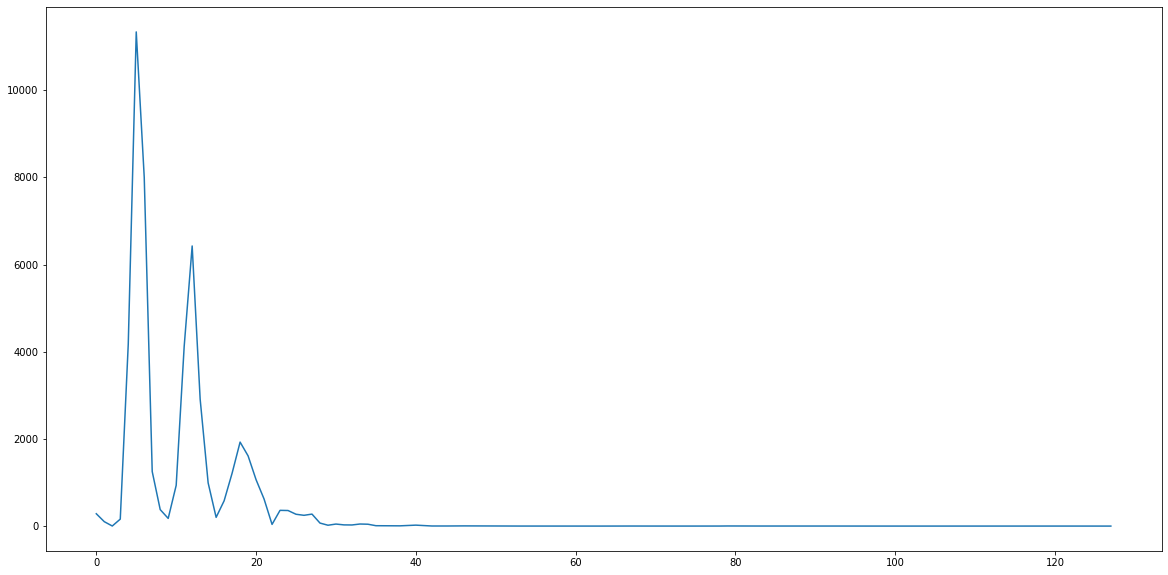

In [35]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(20,10))

idx1 = random.randint(0,len(x_train_ppg)-1)
idx2 = random.randint(0,15)


plt.plot(x_train_ecg[idx1][idx2])
print(idx1,idx2, 'NRS:', y_train[idx1])

11444 7 3


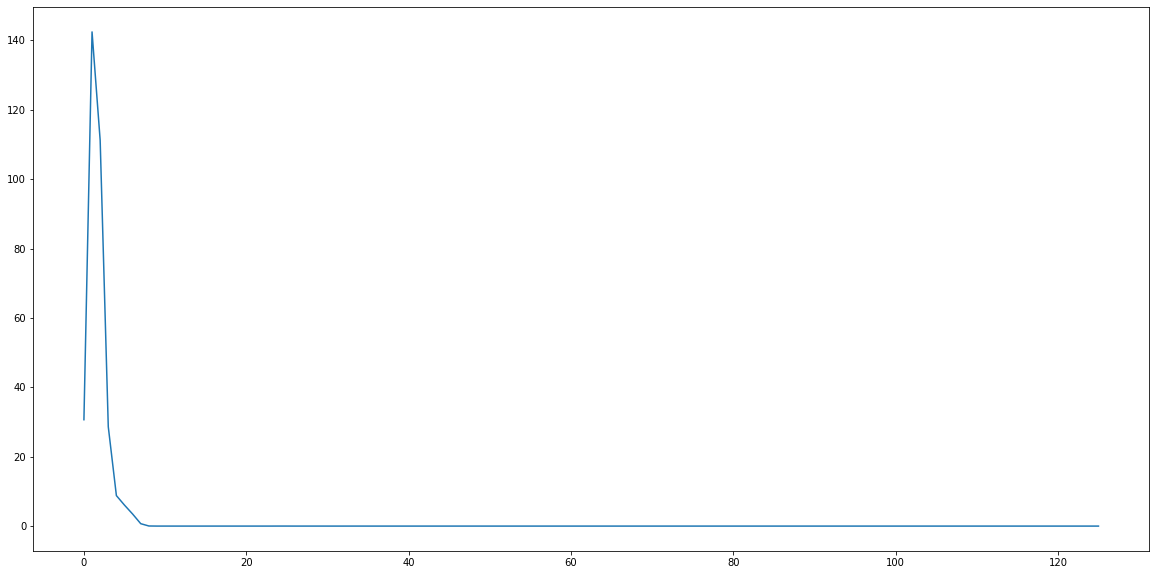

In [107]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(20,10))

idx1 = random.randint(0,len(x_train_ppg)-1)
idx2 = random.randint(0,19)


plt.plot(x_train_ppg[idx1][idx2])
print(idx1,idx2, y_train[idx1])

# Settings

## Loading input

In [26]:
import pandas as pd

print('loading train...', flush=True, end='')

# x를 loading해서 (batch_size, step, channel)
input_path = '../DL_model/dataset/preprocess4/welch/'
input_path = '../DL_model/dataset/preprocess3/input3-3/welch4/'
x_train = np.load(input_path+'x_train.npz', allow_pickle=True)['arr_0']
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
x_val = np.load(input_path+'x_val.npz', allow_pickle=True)['arr_0']

y_train = np.load(input_path+'y_train.npz')['arr_0']
y_test = np.load(input_path+'y_test.npz')['arr_0']
y_val = np.load(input_path+'y_val.npz')['arr_0']
print('done', flush=True)

print('x_train shape:', x_train.shape)
print('x_test.shape:', x_test.shape)
print('x_val.shape:', x_val.shape)

loading train...done
x_train shape: (77989, 16, 128, 2)
x_test.shape: (9218, 16, 128, 2)
x_val.shape: (8535, 16, 128, 2)


In [28]:
x_train_ppg = x_train[:,:,:,0]
x_val_ppg = x_val[:,:,:,0]
x_test_ppg = x_test[:,:,:,0]

x_train_ecg = x_train[:,:,:,1]
x_val_ecg = x_val[:,:,:,1]
x_test_ecg = x_test[:,:,:,1]

## Label

In [29]:
# binary classification
y_train_bin = y_train >= 4
y_test_bin = y_test >= 4
y_val_bin = y_val >= 4

y_train_bin2 = y_train >=7
y_val_bin2 = y_val>=7
y_test_bin2 = y_test>=7

print('y_train event: {:.2f}%,  y_val event: {:.2f}%,  y_test event: {:.2f}%'.format(np.mean(y_train_bin)*100, np.mean(y_val_bin)*100, np.mean(y_test_bin)*100))

y_train event: 61.62%,  y_val event: 62.75%,  y_test event: 58.54%


## GPU settings

In [5]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 4 Logical GPUs


## class weights

### 2 class

In [15]:
# 2 class에 대한 sample weight
train_w_samp2 = np.ones(shape=(len(y_train),))
train_w_samp2[y_train_bin==0]= len(y_train) / np.sum(y_train_bin)
train_w_samp2[y_train_bin!=0]= len(y_train) / np.sum(~y_train_bin)

train_w_samp2_2 = np.ones(shape=(len(y_train),))
train_w_samp2_2[y_train_bin==0]= len(y_train) / np.sum(y_train_bin2)
train_w_samp2_2[y_train_bin!=0]= len(y_train) / np.sum(~y_train_bin2)

print('train set')
print('sample weight for no pain: {:.2f}, moderate pain: {:.2f}'
      .format(len(y_train) / np.sum(y_train_bin), len(y_train) / np.sum(~y_train_bin)))
print('sample weight for no pain: {:.2f}, severe pain: {:.2f}\n'
      .format(len(y_train) / np.sum(y_train_bin2), len(y_train) / np.sum(~y_train_bin2)))

# 2 class에 대한 sample weight
val_w_samp2 = np.ones(shape=(len(y_val),))
val_w_samp2[y_val_bin==0]= len(y_val) / np.sum(y_val_bin)
val_w_samp2[y_val_bin!=0]= len(y_val) / np.sum(~y_val_bin)

val_w_samp2_2 = np.ones(shape=(len(y_val),))
val_w_samp2_2[y_val_bin==0]= len(y_val) / np.sum(y_val_bin2)
val_w_samp2_2[y_val_bin!=0]= len(y_val) / np.sum(~y_val_bin2)

print('val set')
print('sample weight for no pain: {:.2f}, moderate pain: {:.2f}'
      .format(len(y_val) / np.sum(y_val_bin), len(y_val) / np.sum(~y_val_bin)))
print('sample weight for no pain: {:.2f}, severe pain: {:.2f}\n'
      .format(len(y_val) / np.sum(y_val_bin2), len(y_val) / np.sum(~y_val_bin2)))

# 2 class에 대한 sample weight
test_w_samp2 = np.ones(shape=(len(y_test),))
test_w_samp2[y_test_bin==0]= len(y_test) / np.sum(y_test_bin)
test_w_samp2[y_test_bin!=0]= len(y_test) / np.sum(~y_test_bin)

test_w_samp2_2 = np.ones(shape=(len(y_test),))
test_w_samp2_2[y_test_bin==0]= len(y_test) / np.sum(y_test_bin2)
test_w_samp2_2[y_test_bin!=0]= len(y_test) / np.sum(~y_test_bin2)

print('test set')
print('sample weight for no pain: {:.2f}, moderate pain: {:.2f}'
      .format(len(y_test) / np.sum(y_test_bin), len(y_test) / np.sum(~y_test_bin)))
print('sample weight for no pain: {:.2f}, severe pain: {:.2f}'
      .format(len(y_test) / np.sum(y_test_bin2), len(y_test) / np.sum(~y_test_bin2)))

train set
sample weight for no pain: 1.63, moderate pain: 2.58
sample weight for no pain: 6.44, severe pain: 1.18

val set
sample weight for no pain: 1.59, moderate pain: 2.69
sample weight for no pain: 6.68, severe pain: 1.18

test set
sample weight for no pain: 1.62, moderate pain: 2.60
sample weight for no pain: 6.35, severe pain: 1.19


### 3 class

In [30]:
# 3 class에 대한 sample weight
train_w_samp3 = np.ones(shape=(len(y_train),))

train_w_samp3[y_train<4]= len(y_train)/np.sum(y_train<4)
train_w_samp3[(y_train>=4)&(y_train<7)]= len(y_train)/np.sum((4<=y_train)&(y_train<7))
train_w_samp3[y_train>=7]= len(y_train)/np.sum(y_train>=7)


print('sample weight for class 1: {:.2f}, class 2: {:.2f}, class 3: {:.2f}'
      .format(len(y_train)/np.sum(y_train<4),len(y_train)/np.sum((y_train>=4)&(y_train<7)),len(y_train)/np.sum(y_train>=7)))

# 3 class에 대한 sample weight
val_w_samp3 = np.ones(shape=(len(y_val),))

val_w_samp3[y_val<4]= len(y_val)/np.sum(y_val<4)
val_w_samp3[(y_val>=4)&(y_val<7)]= len(y_val)/np.sum((4<=y_val)&(y_val<7))
val_w_samp3[y_val>=7]= len(y_val)/np.sum(y_val>=7)


print('sample weight for class 1: {:.2f}, class 2: {:.2f}, class 3: {:.2f}'
      .format(len(y_val)/np.sum(y_val<4),len(y_val)/np.sum((y_val>=4)&(y_val<7)),len(y_val)/np.sum(y_val>=7)))

# 3 class에 대한 sample weight
test_w_samp3 = np.ones(shape=(len(y_test),))

test_w_samp3[y_test<4]= len(y_test)/np.sum(y_test<4)
test_w_samp3[(y_test>=4)&(y_test<7)]= len(y_test)/np.sum((4<=y_test)&(y_test<7))
test_w_samp3[y_test>=7]= len(y_test)/np.sum(y_test>=7)


print('sample weight for class 1: {:.2f}, class 2: {:.2f}, class 3: {:.2f}'
      .format(len(y_test)/np.sum(y_test<4),len(y_test)/np.sum((y_test>=4)&(y_test<7)),len(y_test)/np.sum(y_test>=7)))

sample weight for class 1: 2.61, class 2: 2.17, class 3: 6.39
sample weight for class 1: 2.68, class 2: 2.09, class 3: 6.73
sample weight for class 1: 2.41, class 2: 2.30, class 3: 6.67


# Training

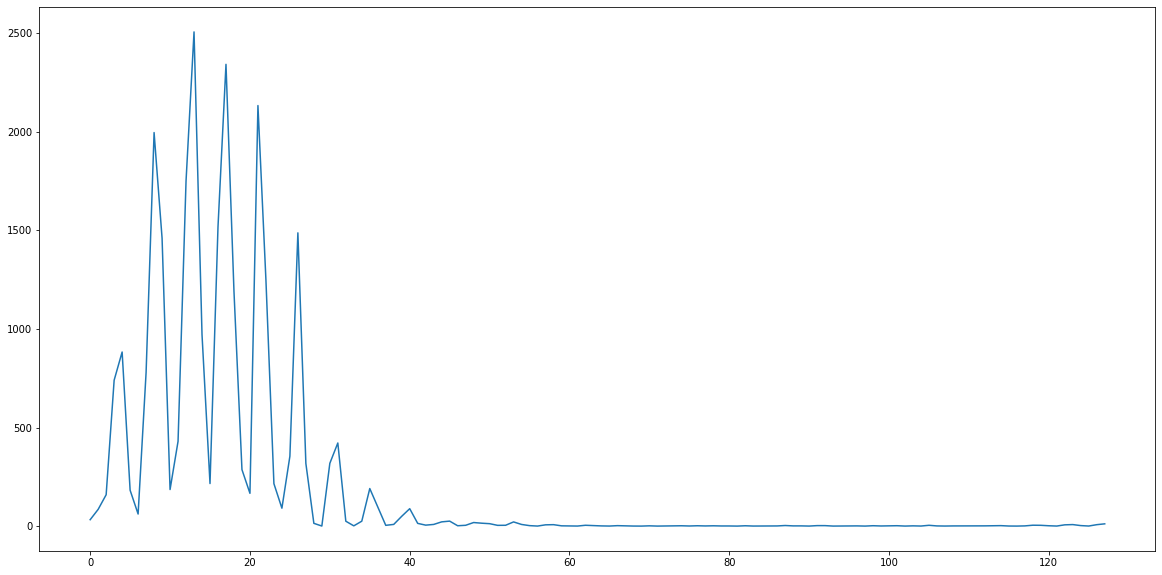

In [42]:
plt.figure(figsize=(20,10))
plt.plot(x_train_ecg[100,5])

## LSTM

In [7]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.optimizers import Adam as Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, LeakyReLU
from keras.layers import Input, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, pickle
from keras import backend as K
from keras import regularizers
from keras.initializers import he_normal, GlorotNormal
import tensorflow_addons as tfa

In [7]:
# hyperparamters
nlayer = 1
units = [16, 64,128]

BATCH_SIZE = 512
dense_node = 0
dropout1 = 0.5
dropout2 = 0.0
learning_rate = 0.001


# initializer & regularizer
k_init = he_normal(seed=None)
#k_init = GlorotNormal(seed=None) # Xavier normal initializer
#k_init = None
b_init = None
k_l2 = 0
#k_reg = regularizers.l2(l2=k_l2)
k_reg = None
b_reg = None


testname = '-'.join([str(unit) for unit in units])
print(testname)


# 출력 폴더를 생성
model_name = 'LSTM3_PPG__bin_sampleweight2_'
for unit in units:
    model_name += 'unit{}_'.format(unit)
model_name += 'nlayer{}_dropout{}_dense{}_dropout{}'.format(len(units), dropout1, dense_node, dropout2)

#model_name = 'model_reg_{}_{}_{}_size{}_relu_bn_maxpool{}_globalmaxpool_dense32_dropout{}_batch{}_learning_rate{}'.format(num_nodes[0], num_nodes[1], num_nodes[2], kernel_size, pool_size, dropout_rate, BATCH_SIZE, learning_rate)
save_path = "output/preprocess4/welch/"+model_name

if not os.path.exists(save_path):
    os.mkdir(save_path)
weight_path = save_path + "/weights.hdf5"


#K.clear_session()
# GPU 설정
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
with strategy.scope():
    '''
    # build a model - sequential
    model = Sequential()
    
    #model.add(LSTM(unit= 4, input_shape=(20,126)))
    for unit in units:
        model.add(LSTM(unit))
    

    #model.add(Dense(dense_node, activation='tanh', kernel_initializer=k_init, kernel_regularizer=k_reg))
    model.add(Dropout(dropout1))
    model.add(Dense(1, activation='sigmoid'))
    '''
    

    # build a model - function api
    inp = Input(shape=(x_train.shape[1], x_train.shape[2]))
    
    # lstm layer
    inp_lstm = inp
    for unit in units[:-1]:
        inp_lstm = LSTM(unit, return_sequences=True) (inp_lstm)
    out_lstm = LSTM(units[-1]) (inp_lstm)
    
    
    out_lstm = Dropout(dropout1) (out_lstm)
    
    if dense_node != 0:
        out_lstm = Dense(dense_node, activation='tanh') (out_lstm)
        out_lstm = Dropout(dropout2) (out_lstm)
    
    # output
    out = Dense(1, activation='sigmoid') (out_lstm)
    model = Model(inputs=[inp], outputs=[out])
    
    #print(abc)
    # model 학습 설정
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=["acc", tf.keras.metrics.AUC()])
    hist = model.fit(x_train_ppg, y_train_bin, validation_data = (x_val_ppg, y_val_bin, val_w_samp3), sample_weight=train_w_samp3, epochs=100, batch_size=BATCH_SIZE, #class_weight={0:1, 1:3}, 
                            callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                                        EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

    
model.load_weights(weight_path)
    
# 모델의 아키텍처 및 구조 저장
open(save_path + "/model.json", "wt").write(model.to_json())


# 전체 test 샘플을 한번에 예측
y_pred = model.predict(x_test_ppg).flatten() # binary는 flatten

# 결과를 저장
#np.savetxt(save_path+'/pred_y.txt', y_pred)


# 모델의 history log 저장 - binary classification
for key in hist.history.keys():
    if 'auc' in key and not 'val' in key:
        auc_key = key
#pickle.dump((hist.history['loss'], hist.history['val_loss'], hist.history['accuracy'], hist.history['val_accuracy'], hist.history[auc], hist.history['val_'+auc]), open(save_path+'/history', 'wb'))

# 모델의 history log 저장 - regression
pickle.dump((hist.history['loss'], hist.history['val_loss'], hist.history['acc'], hist.history['val_acc'], hist.history[auc_key], hist.history['val_'+auc_key]), open(save_path+'/history', 'wb'))


16-64-128
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/100
145/146 [============================>.] - ETA: 0s - loss: 1.9114 - acc: 0.6466 - auc_1: 0.5303
Epoch 00001: val_loss improved from inf to 1.89132, saving model to output/preprocess4/welch/LSTM3_PPG__bin_sampleweight2_unit16_unit64_unit128_nlayer3_dropout0.5_dense0_dropout0.0/weights.hdf5
146/146 [==============================] - 6s 44ms/step - loss: 1.9110 - acc: 0.6467 - auc_1: 0.5306 - val_loss: 1.8913 - val_acc: 0.6286 - val_auc_1: 0.5470
Epoch 2/100
144/146 [============================>.] - ETA: 0s - loss: 1.8994 - acc: 0.6473 - auc_1: 0.5455
Epoch 00002: val_loss improved from 1.89132 to 1.88911, saving model to output/preprocess4/welch/LSTM3_PPG__bin_sampleweight2_unit16_unit64_unit128_nlayer3_dropout0.5_dense0_dropout0.0/weights.hdf5
146/146 [==============================] - 3s 19ms/step - loss: 1.8991 - acc: 0.6473 - auc_1: 0.5454 - val_loss: 1.8891 - 

In [8]:
import os
from keras.models import model_from_json

def best_model_path(models_dir):
    roc_list = []
    model_list = os.listdir(models_dir)
    for f_model in model_list:
        if f_model[0:3]=='roc':
            roc_list.append(f_model[3:9])
        else:
            roc_list.append(0)


    roc_list = np.array(roc_list)
    return os.path.join(models_dir,model_list[np.argmax(roc_list)])

In [39]:
learning_rate = 0.001
BATCH_SIZE = 512

models_dir = 'LSTM_PPG/NRS>=4_welch/LSTM_3layers_sample-weighted_3class'

load_path = best_model_path(models_dir)
load_weight_path = load_path+'/weights.hdf5'


strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
with strategy.scope():
    print('loading model...', flush=True, end='')
    with open(load_path+"/model.json", 'r') as f_json:
        loaded_model_json = f_json.read()
    model_cnn = model_from_json(loaded_model_json)
    print('done')
    
    weight_cache = 'weights.hdf5'
    
    model_cnn.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=["acc", tf.keras.metrics.AUC()])
    hist = model_cnn.fit(x_train_ppg, y_train_bin, validation_data = (x_val_ppg, y_val_bin, val_w_samp3), sample_weight=train_w_samp3, epochs=100, batch_size=BATCH_SIZE, #class_weight={0:1, 1:3}, 
                            callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_cache, verbose=1, save_best_only=True),
                                        EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
loading model...done
Epoch 1/100
146/146 [==============================] - ETA: 0s - loss: 1.9195 - acc: 0.6451 - auc_5: 0.5182
Epoch 00001: val_loss improved from inf to 1.89823, saving model to weights.hdf5
146/146 [==============================] - 20s 138ms/step - loss: 1.9195 - acc: 0.6451 - auc_5: 0.5182 - val_loss: 1.8982 - val_acc: 0.6286 - val_auc_5: 0.5294
Epoch 2/100
146/146 [==============================] - ETA: 0s - loss: 1.9092 - acc: 0.6471 - auc_5: 0.5278
Epoch 00002: val_loss improved from 1.89823 to 1.89392, saving model to weights.hdf5
146/146 [==============================] - 17s 116ms/step - loss: 1.9092 - acc: 0.6471 - auc_5: 0.5278 - val_loss: 1.8939 - val_acc: 0.6286 - val_auc_5: 0.5494
Epoch 3/100
146/146 [==============================] - ETA: 0s - loss: 1.9047 - acc: 0.6471 - auc_5: 0.5344
Epoch 00003: val_loss improved from 1.89392 to 1.89053, saving mode

In [15]:
y_pred = model_cnn.predict(x_test_ppg)

In [34]:
models_dir = 'LSTM_PPG/NRS>=4_welch/LSTM_3layers_sample-weighted_3class'

load_path = best_model_path(models_dir)
print(load_path)
load_weight_path = load_path+'/weights.hdf5'

print('loading model...', flush=True, end='')
with open(load_path+"/model.json", 'r') as f_json:
    loaded_model_json = f_json.read()
model_cnn1 = model_from_json(loaded_model_json)
print('done')

print('loading weights...', flush=True, end='')
model_cnn1.load_weights(load_weight_path)
print('done')

#model_cnn1.summary()

y_pred = model_cnn1.predict(x_test_ppg).flatten()

LSTM_PPG/NRS>=4_welch/LSTM_3layers_sample-weighted_3class/roc0.7580_prc0.8281_gru_batch=512,unit16,unit64,unit128,dropout=0.5,dnodes=0,dropout=0,dnodes=0,dropout=0_acc0.78
loading model...done
loading weights...done


In [25]:
import os, time
filename = 'LSTM_PPG/NRS>=4_welch/LSTM_3layers_sample-weighted_3class/roc0.7537_prc0.8207_gru_batch=512,unit256,unit128,dropout=0.3,dnodes=0,dropout=0,dnodes=0,dropout=0_acc0.79/weights.hdf5'
print('last modified weights.hdf5:', time.ctime(os.path.getmtime(filename)))
print('first made weights.hdf5:   ', time.ctime(os.path.getctime(filename)))


filename = 'dataset/preprocess4/welch/x_test.npz'
print(time.ctime(os.path.getmtime(filename)))
print(time.ctime(os.path.getctime(filename)))

last modified weights.hdf5: Sat Dec 12 07:46:15 2020
first made weights.hdf5:    Sat Dec 12 07:46:15 2020
Sat Dec 12 11:08:55 2020
Sat Dec 12 11:08:55 2020


In [33]:
from keras.models import model_from_json

models_dir = 'LSTM_PPG/NRS>=4_welch/LSTM_3layers_sample-weighted_3class'
#load_path = best_model_path(models_dir)
#print(load_path)
load_path = 'LSTM_PPG/NRS>=4_welch/LSTM_3layers_sample-weighted_3class/roc0.7537_prc0.8207_gru_batch=512,unit256,unit128,dropout=0.3,dnodes=0,dropout=0,dnodes=0,dropout=0_acc0.79'
#load_path = 'LSTM_PPG/NRS>=4_welch/LSTM_3layers_sample-weighted_3class/roc0.7532_prc0.8207_gru_batch=512,unit128,unit128,dropout=0,dnodes=0,dropout=0,dnodes=0,dropout=0_acc0.79'
load_weight_path = load_path+'/weights.hdf5'

print('loading model...', flush=True, end='')
with open(load_path+"/model.json", 'r') as f_json:
    loaded_model_json = f_json.read()
model_lstm = model_from_json(loaded_model_json)
print('done')
print('loading weights...', flush=True, end='')
model_lstm.load_weights(load_weight_path)
print('done')

y_pred = model_lstm.predict(x_test_ppg).flatten()


loading model...done
loading weights...done


test set accuracy:0.81
test set AUROC: 0.7826245660811111
test set AUPRC: 0.8382649315282404


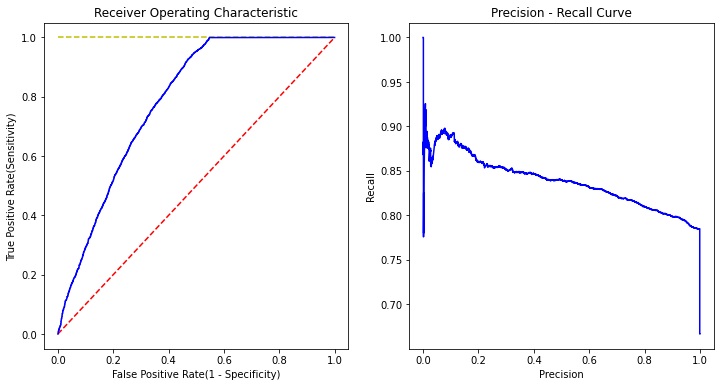

In [34]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt

### Classification
# Model Accuracy of test set
#model_y = y_pred>=0.5
#acc_val = np.mean(model_y==y_test_bin)
acc = metrics.Accuracy()
acc.update_state(y_pred>=0.5, y_test_bin, sample_weight=test_w_samp3)
acc_val = acc.result().numpy()
print('test set accuracy:{:.2f}'.format(acc_val))


# moderate pain
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_bin, y_pred, sample_weight = test_w_samp3)
precision, recall, _ = precision_recall_curve(y_test_bin, y_pred, sample_weight = test_w_samp3)
roc_auc = auc(false_positive_rate, true_positive_rate)
prc_auc = auc(recall, precision)
print('test set AUROC:', roc_auc)
print('test set AUPRC:', prc_auc)


# Adding evaluation results to file name
#test_path = 'output/preprocess4/welch/auroc{:.4f}_auprc{:.4f}_{}acc{:.2f}'.format(roc_auc,prc_auc,model_name,acc_val)
#os.rename(save_path, test_path)

# Plotting ROC, PRC
fig = plt.figure(figsize=(12,6))

# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
ax1.plot(false_positive_rate, true_positive_rate, 'b', label='moderate pain (AUC = %0.4f)'% roc_auc)

# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - Recall Curve')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')
ax2.plot(recall, precision, 'b', label='moderate pain (AUC = %0.4f)'% prc_auc)

#plt.savefig(test_path + '/roc_prc.png', bbox_inches="tight", pad_inches=0.5)


## CNN

In [51]:
x_train_ecg.shape

(78968, 16, 128)

In [64]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.optimizers import Adam as Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, LeakyReLU, ReLU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, pickle
from keras import backend as K


# hyperparamters
num_nodes = [64,64,64] #, 64, 64, 64]
kernel_size = 3
pool_size = 2
BATCH_SIZE = 1024
dense_node = 32
dropout_rate = 0.3
dropout_cnn = 0.3
dropout_fc = 0.3
learning_rate = 0.001


testname = '-'.join([str(num_node) for num_node in num_nodes])
print(testname)

# 출력 폴더를 생성
model_name = '1D_CNN_ECG_bin_sampleweight_2class_'
for num_node in num_nodes:
    model_name += 'conv{}_'.format(num_node)
model_name += 'filter{}_3_bn_maxpool{}_globalmaxpool_dropout{}_dense{}_dropout{}_batch{}_lr_{}'.format(kernel_size, pool_size, dropout_cnn, dense_node, dropout_fc, BATCH_SIZE, learning_rate)

#model_name = 'model_reg_{}_{}_{}_size{}_relu_bn_maxpool{}_globalmaxpool_dense32_dropout{}_batch{}_learning_rate{}'.format(num_nodes[0], num_nodes[1], num_nodes[2], kernel_size, pool_size, dropout_rate, BATCH_SIZE, learning_rate)
save_path = "output/preprocess4/welch/"+model_name

if not os.path.exists(save_path):
    os.mkdir(save_path)
weight_path = save_path + "/weights.hdf5"


# GPU 설정
strategy = tf.distribute.MirroredStrategy(devices=["gpu:0","/gpu:1"])
with strategy.scope():
    
    # build a model
    model = Sequential()
    
    for num_node in num_nodes:
        model.add(Conv1D(filters=num_node, kernel_size=kernel_size, padding='same'))
        model.add(Conv1D(filters=num_node, kernel_size=kernel_size, padding='same'))
        #model.add(LeakyReLU(alpha=0.1))
        model.add(ReLU())
        model.add(BatchNormalization())
        #model.add(MaxPooling1D(pool_size=pool_size))
    #model.add(BatchNormalization())    
    model.add(GlobalMaxPool1D())
    #model.add(Flatten())
    model.add(Dropout(dropout_cnn))
    #model.add(Activation('sigmoid'))
    #model.add(Dropout(dropout_rate))
    if dense_node != 0:
        model.add(Dense(dense_node, activation='tanh'))
        model.add(Dropout(dropout_fc))
    model.add(Dense(1, activation='sigmoid'))

    
    # model 학습 설정
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=["acc", tf.keras.metrics.AUC()])
    hist = model.fit(x_train_ecg, y_train_bin, sample_weight=train_w_samp2, validation_data = (x_val_ecg, y_val_bin, val_w_samp2), epochs=100, batch_size=BATCH_SIZE, #class_weight={0:1, 1:3}, 
                            callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                                        EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

    #tf.keras.backend.clear_session()

model.load_weights(weight_path)
    
# 모델의 아키텍처 및 구조 저장
open(save_path + "/model.json", "wt").write(model.to_json())

# 전체 test 샘플을 한번에 예측
y_pred = model.predict(x_test_ecg).flatten()

# 결과를 저장
#np.savetxt(save_path+'/pred_y.txt', y_pred)


# 모델의 history log 저장 - binary classification
for key in hist.history.keys():
    if 'auc' in key and not 'val' in key:
        auc_key = key
#pickle.dump((hist.history['loss'], hist.history['val_loss'], hist.history['accuracy'], hist.history['val_accuracy'], hist.history[auc], hist.history['val_'+auc]), open(save_path+'/history', 'wb'))

# 모델의 history log 저장 - regression
pickle.dump((hist.history['loss'], hist.history['val_loss'], hist.history['acc'], hist.history['val_acc'], hist.history[auc_key], hist.history['val_'+auc_key]), open(save_path+'/history', 'wb'))


64-64-64
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/100
INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = nccl, num_packs = 1
77/78 [============================>.] - ETA: 0s - loss: 1.3215 - acc: 0.6550 - auc_18: 0.6461
Epoch 00001: val_loss improved from inf to 1.36777, saving model to output/preprocess4/welch/1D_CNN_ECG_bin_sampleweight_2class_conv64_conv64_conv64_filter3_3_bn_maxpool2_globalmaxpool_dropout0.3_dense32_dropout0.3_batch1024_lr_0.001/weights.hdf5
78/78 [==============================] - 5s 62ms/step - loss: 1.3212 - acc: 0.6550 - auc_18: 0.6463 - val_loss: 1.3678 - val_acc: 0.6307 - val_auc_18: 0.5620
Epoch 2/100
77/78 [============================>.] - ETA: 0s - loss: 1.1853 - acc: 0.7035 - auc_18: 0.7118
Epoch 00002: val_loss improved from 1.36777 to 1.32

In [65]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_80 (Conv1D)           (None, 16, 64)            24640     
_________________________________________________________________
conv1d_81 (Conv1D)           (None, 16, 64)            12352     
_________________________________________________________________
re_lu_40 (ReLU)              (None, 16, 64)            0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 16, 64)            256       
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 16, 64)            12352     
_________________________________________________________________
conv1d_83 (Conv1D)           (None, 16, 64)            12352     
_________________________________________________________________
re_lu_41 (ReLU)              (None, 16, 64)          

## training history

model: 1D_CNN_ECG_bin_sampleweight_2class_conv64_conv64_conv128_filter3_3_bn_maxpool2_globalmaxpool_dropout0.3_dense32_dropout0.3_batch1024_lr_0.001


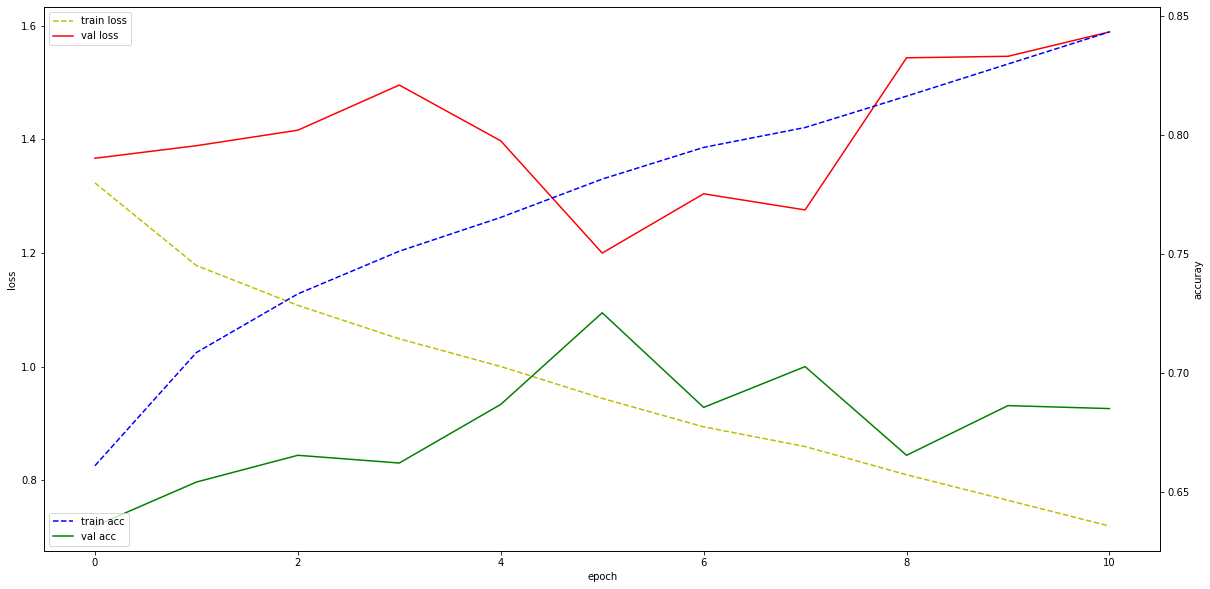

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt


print('model:', model_name)


fig, loss_ax = plt.subplots(figsize=(20,10))

#x-axis는 공유하지만 y-axis는 공유x
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', linestyle='dashed', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

#acc_ax.plot(hist.history['mean_absolute_error'], 'b', linestyle='dashed',label='train mae')
#acc_ax.plot(hist.history['val_mean_absolute_error'], 'g', label='val mae')
acc_ax.plot(hist.history['acc'], 'b', linestyle='dashed',label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
#acc_ax.set_ylim(0.2,1.0)
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# Evaluation

## AUROC, AUPRC

test set accuracy:0.78
test set AUROC: 0.6711623851243009
test set AUPRC: 0.7987104487287213


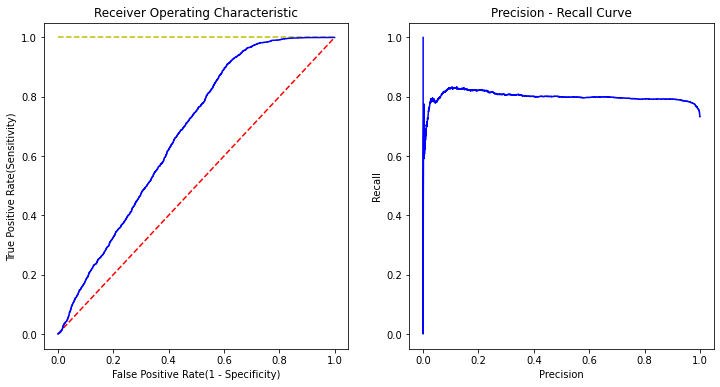

In [66]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt

### Classification
# Model Accuracy of test set
#model_y = y_pred>=0.5
#acc_val = np.mean(model_y==y_test_bin)
acc = metrics.Accuracy()
acc.update_state(y_pred>=0.5, y_test_bin, sample_weight=test_w_samp2)
acc_val = acc.result().numpy()
print('test set accuracy:{:.2f}'.format(acc_val))


# moderate pain
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_bin, y_pred, sample_weight = test_w_samp2)
precision, recall, _ = precision_recall_curve(y_test_bin, y_pred, sample_weight = test_w_samp2)
roc_auc = auc(false_positive_rate, true_positive_rate)
prc_auc = auc(recall, precision)
print('test set AUROC:', roc_auc)
print('test set AUPRC:', prc_auc)


# Adding evaluation results to file name
test_path = 'output/preprocess4/welch/auroc{:.4f}_auprc{:.4f}_{}acc{:.2f}'.format(roc_auc,prc_auc,model_name,acc_val)
os.rename(save_path, test_path)

# Plotting ROC, PRC
fig = plt.figure(figsize=(12,6))

# ax1: auroc
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Receiver Operating Characteristic')
ax1.set_xlabel("False Positive Rate(1 - Specificity)")
ax1.set_ylabel('True Positive Rate(Sensitivity)')
ax1.plot([0,1],[1,1],'y--')
ax1.plot([0,1],[0,1],'r--')
ax1.plot(false_positive_rate, true_positive_rate, 'b', label='moderate pain (AUC = %0.4f)'% roc_auc)

# ax2: auprc
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Precision - Recall Curve')
ax2.set_xlabel("Precision")
ax2.set_ylabel('Recall')
ax2.plot(recall, precision, 'b', label='moderate pain (AUC = %0.4f)'% prc_auc)

plt.savefig(test_path + '/roc_prc.png', bbox_inches="tight", pad_inches=0.5)


In [36]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal
from scipy.signal import windows
sys.path.append('../DL_model')


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수



input_path = 'dataset/preprocess4/welch/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])


if True:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_pacu_2min/'
    ecg_path = '../../cranberry2/Preprocessing/vital_data/ECG_250Hz_pacu_2min/ECG,'
    df_preprocess_pacu = pickle.load(open('cache/preprocess3/input3/df_preprocess_pacu_agender','rb'))

    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('caseid_test_new', 'rb'))
    caseid_train = pickle.load(open('caseid_train_new', 'rb'))
    caseid_val = pickle.load(open('caseid_val_new', 'rb'))
    
    non_case = []
    train_mask, val_mask, test_mask = [], [], []
    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []
    x_val_pacu, y_val_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        

        # vital data - ECG (250Hz)
        ecg_samp = pickle.load(open(ecg_path+row['file_path'][:-3]+'vital', 'rb')).reset_index()[['ECG']]
        ecg_samp = ecg_samp.fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]
        ecg_per_NRS = np.full(30000,np.nan)
        ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
   

        
        # 한 NRS에 대해 23개의 input 확인
        for i in range(30,51):
            # input이 전처리 통과한 경우
            if row[str(i+1)]:
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000
                
                
                # input의 normalization
                ppg_inp = ppg_per_NRS[start_idx:end_idx]
                ecg_inp = ecg_per_NRS[start_idx:end_idx]
                
                
                switch = False
                welch_ppg, welch_ecg = [], []
                
                # 1024/250 의 window size로 1초 간격으로 fft
                stride = 1 # 1초
                fft_window_size = 1024  # 약 4초
                n_window = int((LEN_INPUT-fft_window_size/SRATE)/stride) + 1
                for j in range(n_window):
                    
                    # welch 작업 - hann window를 씌워주고 fft 적용
                    ppg1 = ppg_inp[j*SRATE:j*SRATE + fft_window_size]
                    ecg1 = ecg_inp[j*SRATE:j*SRATE + fft_window_size]
                    if np.sum(np.isnan(ppg1))!=0 or np.sum(np.isnan(ecg1))!=0:
                        switch = True
                        continue
                        
                    #ppg1 = pd.DataFrame(ppg1).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.faltten()
                    ppg2 = ppg1 - np.mean(ppg1)
                    fft_p = np.fft.fft(ppg2 * windows.hann(fft_window_size))
                    fft_p = fft_p[:fft_window_size // 2]
                    fft_p = np.reshape(fft_p, (-1, 4)).sum(axis=-1)
                    fft_p *= fft_p.conj()

                    ecg2 = (ecg1 - np.mean(ecg1)) / np.std(ecg1)
                    fft_e = np.fft.fft(ecg2 * windows.hann(fft_window_size))
                    fft_e = fft_e[:fft_window_size // 2]
                    fft_e = np.reshape(fft_e, (-1, 4)).sum(axis=-1)
                    fft_e *= fft_e.conj()
                    print(Abc)
                    welch_ppg.append(fft_p)
                    welch_ecg.append(fft_e)

                
                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    if switch:
                        test_mask.append(False)
                        continue
                    test_mask.append(True)                    
                    x_test_pacu.append([welch_ppg, welch_ecg])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                elif row['caseids'] in caseid_val:
                    if switch:
                        val_mask.append(False)
                        continue
                    val_mask.append(True)                      
                    x_val_pacu.append([welch_ppg, welch_ecg])
                    y_val_pacu.append(int(float(row['NRS'])))
                    
                elif row['caseids'] in caseid_train:
                    if switch:
                        train_mask.append(False)
                        continue
                    train_mask.append(True)                      
                    x_train_pacu.append([welch_ppg, welch_ecg])
                    y_train_pacu.append(int(float(row['NRS'])))
                    
                else:
                    non_case.append(row['caseids'])
                    
        print('completed')

    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, int)
    y_test_pacu = np.array(y_test_pacu, int)
    x_val_pacu = np.array(x_val_pacu, np.float32)
    y_val_pacu = np.array(y_val_pacu, int)

    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_pacu.npz', x_train_pacu)
    np.savez_compressed(input_path+'x_test_pacu.npz', x_test_pacu)
    np.savez_compressed(input_path+'x_val_pacu.npz', x_val_pacu)
    np.savez_compressed(input_path+'y_train_pacu.npz', y_train_pacu)
    np.savez_compressed(input_path+'y_test_pacu.npz', y_test_pacu)
    np.savez_compressed(input_path+'y_val_pacu.npz', y_val_pacu)
    print('done', flush=True)

   
    
    
print('size of training set(pacu):', len(x_train_pacu))
print('size of validation set(pacu):', len(x_val_pacu))
print('size of test set(pacu):', len(x_test_pacu))


import pickle


pickle.dump(test_mask, open(input_path+'test_mask_pacu','wb'))
pickle.dump(train_mask, open(input_path+'train_mask_pacu','wb'))
pickle.dump(val_mask, open(input_path+'val_mask_pacu','wb'))

loading data 1/7253 ...

NameError: name 'Abc' is not defined

In [ ]:
ppg2 = ppg1 - np.mean(ppg1)
fft_p = np.fft.fft(ppg2 * windows.hann(fft_window_size))
fft_p = fft_p[:fft_window_size // 2]
fft_p = np.reshape(fft_p, (-1, 4)).sum(axis=-1)
fft_p *= fft_p.conj()

In [37]:
ppg2 = ppg1 - np.mean(ppg1)
fft_p = np.fft.fft(ppg2 * windows.hann(fft_window_size))

In [53]:
fft_p1 = np.fft.fft(ppg2 * windows.hann(fft_window_size), 512)
len(ppg2), len(fft_p1)

(1024, 512)

In [55]:
fft_p

array([-759.66794746  +0.j        ,  510.48035631+610.10165673j,
       -158.90799969-380.35587229j, ...,  259.91836865  -7.55411855j,
       -158.90799969+380.35587229j,  510.48035631-610.10165673j])

In [54]:
fft_p1

array([-1.21437569e+03+0.00000000e+00j, -4.53168255e+02-3.74491664e+02j,
       -8.94928473e+02-3.00584024e+02j,  2.35628324e+00-1.71242408e+03j,
        5.56609086e+02+4.17218931e+01j, -5.25944232e+00+6.05632679e+01j,
       -9.33360864e+01-5.19783121e+02j,  2.98480373e+02-1.01718025e+02j,
        1.11608881e+02-3.54568550e+01j,  1.03544295e+02-1.14218247e+02j,
        9.59688038e+01-3.80102633e+00j,  3.35524603e+01-9.16851032e+00j,
        5.02406362e+01-1.17455778e+02j,  1.12474565e+02-5.16278111e+00j,
        5.81023968e+01+4.97006857e+00j,  3.69841407e+01-9.55095965e+00j,
        4.36088750e+01-1.39757793e+01j,  3.82264247e+01+1.01377352e+00j,
        3.02644024e+01-1.91187420e-01j,  2.37499760e+01+3.53123606e+00j,
        1.93060081e+01-1.38781463e+00j,  1.86447612e+01-2.97212045e-01j,
        1.40573061e+01-3.30971778e+00j,  1.41193723e+01-1.66747786e+00j,
        1.45768586e+01-3.95698267e+00j,  1.00547701e+01-1.34528270e+00j,
        1.11845138e+01-5.17292649e+00j,  9.90989073

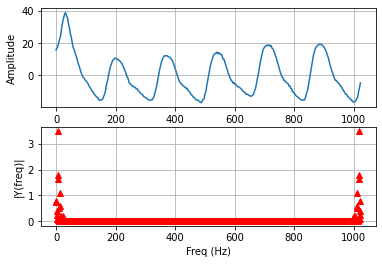

In [57]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1)
ax[0].plot(ppg2)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[0].grid(True)
ax[1].plot(abs(fft_p/1024), 'r', linestyle=' ', marker='^') 
#ax[1].set_xlim()
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')
#ax[1].vlines(freq, [0], abs(Y))
ax[1].grid(True)
plt.show()

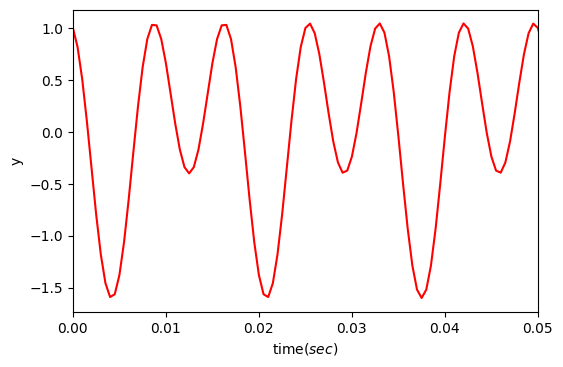

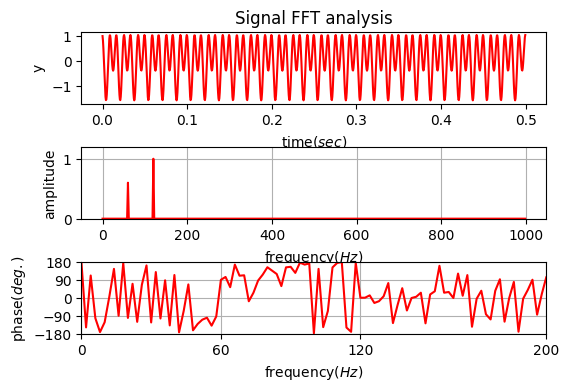

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import math

#St=0.0005

#Fs = 1/St                    # Sampling frequency
Fs = 2000                    # Sampling frequency
T = 1/Fs                     # Sample interval time
te= 0.5                     # End of time
t = np.arange(0, te, T)   # Time vector

# Sum of a 50 Hz sinusoid and a 120 Hz sinusoid
noise = np.random.normal(0,0.05,len(t))
x = 0.6*np.cos(2*np.pi*60*t+np.pi/2) + np.cos(2*np.pi*120*t)
y = x # + noise     # Sinusoids plus noise

# if energy was collapsed by forced code like belows...
#BB=range(math.trunc(len(t)/2), len(t))
#y[BB]=0

plt.figure(num=1,dpi=100,facecolor='white')
plt.plot(t,y,'r')
plt.xlim( 0, 0.05)
plt.xlabel('time($sec$)')
plt.ylabel('y')

plt.savefig("./test_figure1.png",dpi=300)


# Calculate FFT ....................
n=len(y)        # Length of signal
NFFT=n      # ?? NFFT=2^nextpow2(length(y))  ??
k=np.arange(NFFT)
f0=k*Fs/NFFT    # double sides frequency range
f0=f0[range(math.trunc(NFFT/2))]        # single sied frequency range

Y=np.fft.fft(y)/NFFT        # fft computing and normaliation
Y=Y[range(math.trunc(NFFT/2))]          # single sied frequency range
amplitude_Hz = 2*abs(Y)
phase_ang = np.angle(Y)*180/np.pi

# figure 1 ..................................
plt.figure(num=2,dpi=100,facecolor='white')
plt.subplots_adjust(hspace = 0.6, wspace = 0.3)
plt.subplot(3,1,1)

plt.plot(t,y,'r')
plt.title('Signal FFT analysis')
plt.xlabel('time($sec$)')
plt.ylabel('y')
#plt.xlim( 0, 0.1)

# Amplitude ....
#plt.figure(num=2,dpi=100,facecolor='white')
plt.subplot(3,1,2)

# Plot single-sided amplitude spectrum.

plt.plot(f0,amplitude_Hz,'r')   #  2* ???
#plt.xticks(np.arange(0,500,20))
#plt.xlim( 0, 200)
plt.ylim( 0, 1.2)
#plt.title('Single-Sided Amplitude Spectrum of y(t)')
plt.xlabel('frequency($Hz$)')
plt.ylabel('amplitude')
plt.grid()

# Phase ....
#plt.figure(num=2,dpi=100,facecolor='white')
plt.subplot(3,1,3)
plt.plot(f0,phase_ang,'r')   #  2* ???
plt.xlim( 0, 200)
plt.ylim( -180, 180)
#plt.title('Single-Sided Phase Spectrum of y(t)')
plt.xlabel('frequency($Hz$)')
plt.ylabel('phase($deg.$)')
plt.xticks([0, 60, 120, 200])
plt.yticks([-180, -90, 0, 90, 180])
plt.grid()

In [48]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal
from scipy.signal import windows
sys.path.append('../DL_model')


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수



input_path = 'dataset/preprocess4/welch/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])


if True:
    false_row_list_preop = []
    
    preop_ecg_path = "../../cranberry2/Preprocessing/vital_data/ECG_250Hz_preop_2min/"
    vital_path = '../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_preop_2min/'
    df_preprocess_preop = pickle.load(open('cache/preprocess3/input3/df_preprocess_preop_agender','rb'))

    

    ### test set에 해당하는 file_path
    caseid_test_new = pickle.load(open('caseid_test_new', 'rb'))
    caseid_train_new = pickle.load(open('caseid_train_new', 'rb'))
    caseid_val_new = pickle.load(open('caseid_val_new', 'rb'))
    
    caseid_test = pickle.load(open('caseid_test', 'rb'))
    caseid_train = pickle.load(open('caseid_train', 'rb'))
    caseid_val = pickle.load(open('caseid_val', 'rb'))
    
    
    
    non_case = []
    train_mask, val_mask, test_mask = [], [], []
    caseid_train_old, caseid_train_new1 = [], []
    caseid_test_old, caseid_test_new1 = [], []
    caseid_val_old, caseid_val_new1 = [], []

    cnt = 0
    for _, row in df_preprocess_preop.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_preop)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        

        # vital data - ECG (250Hz)
        ecg_samp = pickle.load(open(preop_ecg_path+row['file_path'].split(',')[2], 'rb'))
        ecg_samp = pd.DataFrame(ecg_samp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]
        ecg_per_NRS = np.full(30000,np.nan)
        ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
   

        
        # 한 NRS에 대해 23개의 input 확인
        for i in range(30,51):
            # input이 전처리 통과한 경우
            if row[str(i+1)]:
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000
                
                
                # input의 normalization
                ppg_inp = ppg_per_NRS[start_idx:end_idx]
                ecg_inp = ecg_per_NRS[start_idx:end_idx]
                
                
                switch = False
                welch_ppg, welch_ecg = [], []
                
                # 1024/250 의 window size로 1초 간격으로 fft
                stride = 1 # 1초
                fft_window_size = 1024  # 약 4초
                n_window = int((LEN_INPUT-fft_window_size/SRATE)/stride) + 1
                for j in range(n_window):
                    
                    # welch 작업 - hann window를 씌워주고 fft 적용
                    ppg1 = ppg_inp[j*SRATE:j*SRATE + fft_window_size]
                    ecg1 = ecg_inp[j*SRATE:j*SRATE + fft_window_size]
                    if np.sum(np.isnan(ppg1))!=0 or np.sum(np.isnan(ecg1))!=0:
                        switch = True
                        continue

                
                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    if switch:
                        test_mask.append(False)
                        continue
                    test_mask.append(True)                    
                    caseid_test_old.append(row['caseids'])

                # 해당 caseid가 train set에 해당하는 경우
                elif row['caseids'] in caseid_val:
                    if switch:
                        val_mask.append(False)
                        continue
                    val_mask.append(True)                      
                    caseid_val_old.append(row['caseids'])
                    
                elif row['caseids'] in caseid_train:
                    if switch:
                        train_mask.append(False)
                        continue
                    train_mask.append(True)                      
                    caseid_train_old.append(row['caseids'])
                else:
                    0
                    
                    
                if row['caseids'] in caseid_test_new:
                    if switch:
                        test_mask.append(False)
                        continue
                    test_mask.append(True)                    
                    caseid_test_new1.append(row['caseids'])

                # 해당 caseid가 train set에 해당하는 경우
                elif row['caseids'] in caseid_val_new:
                    if switch:
                        val_mask.append(False)
                        continue
                    val_mask.append(True)                      
                    caseid_val_new1.append(row['caseids'])
                    
                elif row['caseids'] in caseid_train_new:
                    if switch:
                        train_mask.append(False)
                        continue
                    train_mask.append(True)                      
                    caseid_train_new1.append(row['caseids'])
                    
        print('completed')


loading data 1/7253 ...completed
loading data 2/7253 ...completed
loading data 3/7253 ...completed
loading data 4/7253 ...completed
loading data 5/7253 ...completed
loading data 6/7253 ...completed
loading data 7/7253 ...completed
loading data 8/7253 ...completed
loading data 9/7253 ...completed
loading data 10/7253 ...completed
loading data 11/7253 ...completed
loading data 12/7253 ...completed
loading data 13/7253 ...completed
loading data 14/7253 ...completed
loading data 15/7253 ...completed
loading data 16/7253 ...completed
loading data 17/7253 ...completed
loading data 18/7253 ...completed
loading data 19/7253 ...completed
loading data 20/7253 ...completed
loading data 21/7253 ...completed
loading data 22/7253 ...completed
loading data 23/7253 ...completed
loading data 24/7253 ...completed
loading data 25/7253 ...completed
loading data 26/7253 ...completed
loading data 27/7253 ...completed
loading data 28/7253 ...completed
loading data 29/7253 ...completed
loading data 30/7253 ..

loading data 258/7253 ...completed
loading data 259/7253 ...completed
loading data 260/7253 ...completed
loading data 261/7253 ...completed
loading data 262/7253 ...completed
loading data 263/7253 ...completed
loading data 264/7253 ...completed
loading data 265/7253 ...completed
loading data 266/7253 ...completed
loading data 267/7253 ...completed
loading data 268/7253 ...completed
loading data 269/7253 ...completed
loading data 270/7253 ...completed
loading data 271/7253 ...completed
loading data 272/7253 ...completed
loading data 273/7253 ...completed
loading data 274/7253 ...completed
loading data 275/7253 ...completed
loading data 276/7253 ...completed
loading data 277/7253 ...completed
loading data 278/7253 ...completed
loading data 279/7253 ...completed
loading data 280/7253 ...completed
loading data 281/7253 ...completed
loading data 282/7253 ...completed
loading data 283/7253 ...completed
loading data 284/7253 ...completed
loading data 285/7253 ...completed
loading data 286/725

loading data 514/7253 ...completed
loading data 515/7253 ...completed
loading data 516/7253 ...completed
loading data 517/7253 ...completed
loading data 518/7253 ...completed
loading data 519/7253 ...completed
loading data 520/7253 ...completed
loading data 521/7253 ...completed
loading data 522/7253 ...completed
loading data 523/7253 ...completed
loading data 524/7253 ...completed
loading data 525/7253 ...completed
loading data 526/7253 ...completed
loading data 527/7253 ...completed
loading data 528/7253 ...completed
loading data 529/7253 ...completed
loading data 530/7253 ...completed
loading data 531/7253 ...completed
loading data 532/7253 ...completed
loading data 533/7253 ...completed
loading data 534/7253 ...completed
loading data 535/7253 ...completed
loading data 536/7253 ...completed
loading data 537/7253 ...completed
loading data 538/7253 ...completed
loading data 539/7253 ...completed
loading data 540/7253 ...completed
loading data 541/7253 ...completed
loading data 542/725

loading data 759/7253 ...completed
loading data 760/7253 ...completed
loading data 761/7253 ...completed
loading data 762/7253 ...completed
loading data 763/7253 ...completed
loading data 764/7253 ...completed
loading data 765/7253 ...completed
loading data 766/7253 ...completed
loading data 767/7253 ...completed
loading data 768/7253 ...completed
loading data 769/7253 ...completed
loading data 770/7253 ...completed
loading data 771/7253 ...completed
loading data 772/7253 ...completed
loading data 773/7253 ...completed
loading data 774/7253 ...completed
loading data 775/7253 ...completed
loading data 776/7253 ...completed
loading data 777/7253 ...completed
loading data 778/7253 ...completed
loading data 779/7253 ...completed
loading data 780/7253 ...completed
loading data 781/7253 ...completed
loading data 782/7253 ...completed
loading data 783/7253 ...completed
loading data 784/7253 ...completed
loading data 785/7253 ...completed
loading data 786/7253 ...completed
loading data 787/725

loading data 997/7253 ...completed
loading data 998/7253 ...completed
loading data 999/7253 ...completed
loading data 1000/7253 ...completed
loading data 1001/7253 ...completed
loading data 1002/7253 ...completed
loading data 1003/7253 ...completed
loading data 1004/7253 ...completed
loading data 1005/7253 ...completed
loading data 1006/7253 ...completed
loading data 1007/7253 ...completed
loading data 1008/7253 ...completed
loading data 1009/7253 ...completed
loading data 1010/7253 ...completed
loading data 1011/7253 ...completed
loading data 1012/7253 ...completed
loading data 1013/7253 ...completed
loading data 1014/7253 ...completed
loading data 1015/7253 ...completed
loading data 1016/7253 ...completed
loading data 1017/7253 ...completed
loading data 1018/7253 ...completed
loading data 1019/7253 ...completed
loading data 1020/7253 ...completed
loading data 1021/7253 ...completed
loading data 1022/7253 ...completed
loading data 1023/7253 ...completed
loading data 1024/7253 ...compl

loading data 1226/7253 ...completed
loading data 1227/7253 ...completed
loading data 1228/7253 ...completed
loading data 1229/7253 ...completed
loading data 1230/7253 ...completed
loading data 1231/7253 ...completed
loading data 1232/7253 ...completed
loading data 1233/7253 ...completed
loading data 1234/7253 ...completed
loading data 1235/7253 ...completed
loading data 1236/7253 ...completed
loading data 1237/7253 ...completed
loading data 1238/7253 ...completed
loading data 1239/7253 ...completed
loading data 1240/7253 ...completed
loading data 1241/7253 ...completed
loading data 1242/7253 ...completed
loading data 1243/7253 ...completed
loading data 1244/7253 ...completed
loading data 1245/7253 ...completed
loading data 1246/7253 ...completed
loading data 1247/7253 ...completed
loading data 1248/7253 ...completed
loading data 1249/7253 ...completed
loading data 1250/7253 ...completed
loading data 1251/7253 ...completed
loading data 1252/7253 ...completed
loading data 1253/7253 ...co

loading data 1475/7253 ...completed
loading data 1476/7253 ...completed
loading data 1477/7253 ...completed
loading data 1478/7253 ...completed
loading data 1479/7253 ...completed
loading data 1480/7253 ...completed
loading data 1481/7253 ...completed
loading data 1482/7253 ...completed
loading data 1483/7253 ...completed
loading data 1484/7253 ...completed
loading data 1485/7253 ...completed
loading data 1486/7253 ...completed
loading data 1487/7253 ...completed
loading data 1488/7253 ...completed
loading data 1489/7253 ...completed
loading data 1490/7253 ...completed
loading data 1491/7253 ...completed
loading data 1492/7253 ...completed
loading data 1493/7253 ...completed
loading data 1494/7253 ...completed
loading data 1495/7253 ...completed
loading data 1496/7253 ...completed
loading data 1497/7253 ...completed
loading data 1498/7253 ...completed
loading data 1499/7253 ...completed
loading data 1500/7253 ...completed
loading data 1501/7253 ...completed
loading data 1502/7253 ...co

loading data 1718/7253 ...completed
loading data 1719/7253 ...completed
loading data 1720/7253 ...completed
loading data 1721/7253 ...completed
loading data 1722/7253 ...completed
loading data 1723/7253 ...completed
loading data 1724/7253 ...completed
loading data 1725/7253 ...completed
loading data 1726/7253 ...completed
loading data 1727/7253 ...completed
loading data 1728/7253 ...completed
loading data 1729/7253 ...completed
loading data 1730/7253 ...completed
loading data 1731/7253 ...completed
loading data 1732/7253 ...completed
loading data 1733/7253 ...completed
loading data 1734/7253 ...completed
loading data 1735/7253 ...completed
loading data 1736/7253 ...completed
loading data 1737/7253 ...completed
loading data 1738/7253 ...completed
loading data 1739/7253 ...completed
loading data 1740/7253 ...completed
loading data 1741/7253 ...completed
loading data 1742/7253 ...completed
loading data 1743/7253 ...completed
loading data 1744/7253 ...completed
loading data 1745/7253 ...co

loading data 1965/7253 ...completed
loading data 1966/7253 ...completed
loading data 1967/7253 ...completed
loading data 1968/7253 ...completed
loading data 1969/7253 ...completed
loading data 1970/7253 ...completed
loading data 1971/7253 ...completed
loading data 1972/7253 ...completed
loading data 1973/7253 ...completed
loading data 1974/7253 ...completed
loading data 1975/7253 ...completed
loading data 1976/7253 ...completed
loading data 1977/7253 ...completed
loading data 1978/7253 ...completed
loading data 1979/7253 ...completed
loading data 1980/7253 ...completed
loading data 1981/7253 ...completed
loading data 1982/7253 ...completed
loading data 1983/7253 ...completed
loading data 1984/7253 ...completed
loading data 1985/7253 ...completed
loading data 1986/7253 ...completed
loading data 1987/7253 ...completed
loading data 1988/7253 ...completed
loading data 1989/7253 ...completed
loading data 1990/7253 ...completed
loading data 1991/7253 ...completed
loading data 1992/7253 ...co

loading data 2210/7253 ...completed
loading data 2211/7253 ...completed
loading data 2212/7253 ...completed
loading data 2213/7253 ...completed
loading data 2214/7253 ...completed
loading data 2215/7253 ...completed
loading data 2216/7253 ...completed
loading data 2217/7253 ...completed
loading data 2218/7253 ...completed
loading data 2219/7253 ...completed
loading data 2220/7253 ...completed
loading data 2221/7253 ...completed
loading data 2222/7253 ...completed
loading data 2223/7253 ...completed
loading data 2224/7253 ...completed
loading data 2225/7253 ...completed
loading data 2226/7253 ...completed
loading data 2227/7253 ...completed
loading data 2228/7253 ...completed
loading data 2229/7253 ...completed
loading data 2230/7253 ...completed
loading data 2231/7253 ...completed
loading data 2232/7253 ...completed
loading data 2233/7253 ...completed
loading data 2234/7253 ...completed
loading data 2235/7253 ...completed
loading data 2236/7253 ...completed
loading data 2237/7253 ...co

loading data 2458/7253 ...completed
loading data 2459/7253 ...completed
loading data 2460/7253 ...completed
loading data 2461/7253 ...completed
loading data 2462/7253 ...completed
loading data 2463/7253 ...completed
loading data 2464/7253 ...completed
loading data 2465/7253 ...completed
loading data 2466/7253 ...completed
loading data 2467/7253 ...completed
loading data 2468/7253 ...completed
loading data 2469/7253 ...completed
loading data 2470/7253 ...completed
loading data 2471/7253 ...completed
loading data 2472/7253 ...completed
loading data 2473/7253 ...completed
loading data 2474/7253 ...completed
loading data 2475/7253 ...completed
loading data 2476/7253 ...completed
loading data 2477/7253 ...completed
loading data 2478/7253 ...completed
loading data 2479/7253 ...completed
loading data 2480/7253 ...completed
loading data 2481/7253 ...completed
loading data 2482/7253 ...completed
loading data 2483/7253 ...completed
loading data 2484/7253 ...completed
loading data 2485/7253 ...co

loading data 2701/7253 ...completed
loading data 2702/7253 ...completed
loading data 2703/7253 ...completed
loading data 2704/7253 ...completed
loading data 2705/7253 ...completed
loading data 2706/7253 ...completed
loading data 2707/7253 ...completed
loading data 2708/7253 ...completed
loading data 2709/7253 ...completed
loading data 2710/7253 ...completed
loading data 2711/7253 ...completed
loading data 2712/7253 ...completed
loading data 2713/7253 ...completed
loading data 2714/7253 ...completed
loading data 2715/7253 ...completed
loading data 2716/7253 ...completed
loading data 2717/7253 ...completed
loading data 2718/7253 ...completed
loading data 2719/7253 ...completed
loading data 2720/7253 ...completed
loading data 2721/7253 ...completed
loading data 2722/7253 ...completed
loading data 2723/7253 ...completed
loading data 2724/7253 ...completed
loading data 2725/7253 ...completed
loading data 2726/7253 ...completed
loading data 2727/7253 ...completed
loading data 2728/7253 ...co

loading data 2943/7253 ...completed
loading data 2944/7253 ...completed
loading data 2945/7253 ...completed
loading data 2946/7253 ...completed
loading data 2947/7253 ...completed
loading data 2948/7253 ...completed
loading data 2949/7253 ...completed
loading data 2950/7253 ...completed
loading data 2951/7253 ...completed
loading data 2952/7253 ...completed
loading data 2953/7253 ...completed
loading data 2954/7253 ...completed
loading data 2955/7253 ...completed
loading data 2956/7253 ...completed
loading data 2957/7253 ...completed
loading data 2958/7253 ...completed
loading data 2959/7253 ...completed
loading data 2960/7253 ...completed
loading data 2961/7253 ...completed
loading data 2962/7253 ...completed
loading data 2963/7253 ...completed
loading data 2964/7253 ...completed
loading data 2965/7253 ...completed
loading data 2966/7253 ...completed
loading data 2967/7253 ...completed
loading data 2968/7253 ...completed
loading data 2969/7253 ...completed
loading data 2970/7253 ...co

loading data 3185/7253 ...completed
loading data 3186/7253 ...completed
loading data 3187/7253 ...completed
loading data 3188/7253 ...completed
loading data 3189/7253 ...completed
loading data 3190/7253 ...completed
loading data 3191/7253 ...completed
loading data 3192/7253 ...completed
loading data 3193/7253 ...completed
loading data 3194/7253 ...completed
loading data 3195/7253 ...completed
loading data 3196/7253 ...completed
loading data 3197/7253 ...completed
loading data 3198/7253 ...completed
loading data 3199/7253 ...completed
loading data 3200/7253 ...completed
loading data 3201/7253 ...completed
loading data 3202/7253 ...completed
loading data 3203/7253 ...completed
loading data 3204/7253 ...completed
loading data 3205/7253 ...completed
loading data 3206/7253 ...completed
loading data 3207/7253 ...completed
loading data 3208/7253 ...completed
loading data 3209/7253 ...completed
loading data 3210/7253 ...completed
loading data 3211/7253 ...completed
loading data 3212/7253 ...co

loading data 3435/7253 ...completed
loading data 3436/7253 ...completed
loading data 3437/7253 ...completed
loading data 3438/7253 ...completed
loading data 3439/7253 ...completed
loading data 3440/7253 ...completed
loading data 3441/7253 ...completed
loading data 3442/7253 ...completed
loading data 3443/7253 ...completed
loading data 3444/7253 ...completed
loading data 3445/7253 ...completed
loading data 3446/7253 ...completed
loading data 3447/7253 ...completed
loading data 3448/7253 ...completed
loading data 3449/7253 ...completed
loading data 3450/7253 ...completed
loading data 3451/7253 ...completed
loading data 3452/7253 ...completed
loading data 3453/7253 ...completed
loading data 3454/7253 ...completed
loading data 3455/7253 ...completed
loading data 3456/7253 ...completed
loading data 3457/7253 ...completed
loading data 3458/7253 ...completed
loading data 3459/7253 ...completed
loading data 3460/7253 ...completed
loading data 3461/7253 ...completed
loading data 3462/7253 ...co

loading data 3671/7253 ...completed
loading data 3672/7253 ...completed
loading data 3673/7253 ...completed
loading data 3674/7253 ...completed
loading data 3675/7253 ...completed
loading data 3676/7253 ...completed
loading data 3677/7253 ...completed
loading data 3678/7253 ...completed
loading data 3679/7253 ...completed
loading data 3680/7253 ...completed
loading data 3681/7253 ...completed
loading data 3682/7253 ...completed
loading data 3683/7253 ...completed
loading data 3684/7253 ...completed
loading data 3685/7253 ...completed
loading data 3686/7253 ...completed
loading data 3687/7253 ...completed
loading data 3688/7253 ...completed
loading data 3689/7253 ...completed
loading data 3690/7253 ...completed
loading data 3691/7253 ...completed
loading data 3692/7253 ...completed
loading data 3693/7253 ...completed
loading data 3694/7253 ...completed
loading data 3695/7253 ...completed
loading data 3696/7253 ...completed
loading data 3697/7253 ...completed
loading data 3698/7253 ...co

In [49]:
len(np.unique(caseid_test_old)), len(np.unique(caseid_test_new1))

(142, 109)

In [50]:
len(caseid_test_old), len(caseid_test_new1)

(1727, 1298)

In [51]:
len(caseid_test), len(caseid_test_new)

(501, 387)

In [53]:
set(caseid_test_old)-set(caseid_test_new1)

{'PACU1_10_200205_145216.csv',
 'PACU1_11_190507_112917.csv',
 'PACU1_12_200616_152932.csv',
 'PACU1_1_190424_104547.csv',
 'PACU1_1_190425_110118.csv',
 'PACU1_1_200615_195658.csv',
 'PACU1_1_200720_141748.csv',
 'PACU1_1_200828_144451.csv',
 'PACU1_1_200928_203944.csv',
 'PACU1_3_190507_131442.csv',
 'PACU1_3_200320_163212.csv',
 'PACU1_3_200325_194331.csv',
 'PACU1_3_201029_175055.csv',
 'PACU1_4_190718_090635.csv',
 'PACU1_4_190723_164623.csv',
 'PACU1_4_200110_000846.csv',
 'PACU1_4_200617_163518.csv',
 'PACU1_5_190509_223112.csv',
 'PACU1_5_190717_082658.csv',
 'PACU1_5_201021_193843.csv',
 'PACU1_6_190709_121303.csv',
 'PACU1_6_190726_190319.csv',
 'PACU1_6_200514_123829.csv',
 'PACU1_6_200515_181108.csv',
 'PACU1_6_200928_160609.csv',
 'PACU1_7_200507_124641.csv',
 'PACU1_7_200513_172534.csv',
 'PACU1_7_201007_111324.csv',
 'PACU1_7_201008_110107.csv',
 'PACU1_7_201022_102105.csv',
 'PACU1_8_200318_101415.csv',
 'PACU1_9_190705_122129.csv',
 'PACU1_9_190710_155430.csv',
 'PACU1

In [ ]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수

non_preop_list = []


input_path = 'dataset/preprocess4/welch/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])


if True:
    false_row_list_preop = []
    
    preop_ecg_path = "../../cranberry2/Preprocessing/vital_data/ECG_250Hz_preop_2min/"
    vital_path = '../../cranberry2/Preprocessing/vital_data/PPG_100Hz_ECG_100Hz_preop_2min/'
    df_preprocess_preop = pickle.load(open('cache/preprocess3/input3/df_preprocess_preop_agender','rb'))
    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('caseid_test_new', 'rb'))
    caseid_train = pickle.load(open('caseid_train_new', 'rb'))
    caseid_val = pickle.load(open('caseid_val_new', 'rb'))
    

    train_mask, val_mask, test_mask = [], [], []
    x_train_preop, y_train_preop = [], []
    x_test_preop, y_test_preop = [], []
    x_val_preop,y_val_preop = [], []

    cnt = 0
    for _, row in df_preprocess_preop.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_preop)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        
        # vital data - ECG (250Hz)       
        try:
            ecg_samp = pickle.load(open(preop_ecg_path+row['file_path'].split(',')[2], 'rb'))
            
        except:
            non_preop_list.append(row['file_path'])
            print('no preop data')
            continue
        else:
            ecg_samp = pd.DataFrame(ecg_samp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]       
            ecg_per_NRS = np.full(30000,np.nan)
            ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
            
            # 한 NRS에 대해 23개의 input 확인
            for i in range(30,51):
                # input이 전처리 통과한 경우
                if row[str(i+1)]:
                    start_idx = i*OVERLAP*SRATE # 500i
                    end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000


                    # input의 normalization
                    ppg_inp = ppg_per_NRS[start_idx:end_idx]
                    #if np.sum(np.isnan(pleth_inp)) != 0:
                        #pleth_inp = (pd.DataFrame(pleth_inp)).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
                    
                    #pleth_inp = pleth_inp - np.nanmean(pleth_inp)

                    ecg_inp = ecg_per_NRS[start_idx:end_idx]
                    #ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)


                    switch = False
                    welch_ppg, welch_ecg = [], []
                    # 1024/250 의 window size로 1초 간격으로 fft
                    stride = 1 # 1초
                    fft_window_size = 1024  # 약 4초
                    n_window = int((LEN_INPUT-fft_window_size/SRATE)/stride) + 1
                    for j in range(n_window):
                        
                        # welch 작업 - hann window를 씌워주고 fft 적용
                        ppg1 = ppg_inp[j*SRATE:j*SRATE + fft_window_size]
                        ecg1 = ecg_inp[j*SRATE:j*SRATE + fft_window_size]
                        if np.sum(np.isnan(ppg1))!=0 or np.sum(np.isnan(ecg1))!=0:
                            switch = True
                            continue

                        #ppg1 = pd.DataFrame(ppg1).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.faltten()
                        ppg2 = ppg1 - np.mean(ppg1)
                        fft_p = np.fft.fft(ppg2 * windows.hann(fft_window_size))
                        fft_p = fft_p[:fft_window_size // 2]
                        fft_p = np.reshape(fft_p, (-1, 4)).sum(axis=-1)
                        fft_p *= fft_p.conj()

                        ecg2 = (ecg1 - np.mean(ecg1)) / np.std(ecg1)
                        fft_e = np.fft.fft(ecg2 * windows.hann(fft_window_size))
                        fft_e = fft_e[:fft_window_size // 2]
                        fft_e = np.reshape(fft_e, (-1, 4)).sum(axis=-1)
                        fft_e *= fft_e.conj()

                        welch_ppg.append(fft_p)
                        welch_ecg.append(fft_e)


                    # 해당 caseid가 test set에 속하는 경우
                    if row['caseids'] in caseid_test:
                        if switch:
                            test_mask.append(False)
                            continue
                        test_mask.append(True)                    
                        x_test_preop.append([welch_ppg, welch_ecg])
                        y_test_preop.append(int(float(row['NRS'])))

                    # 해당 caseid가 train set에 해당하는 경우
                    elif row['caseids'] in caseid_val:
                        if switch:
                            val_mask.append(False)
                            continue
                        val_mask.append(True)                      
                        x_val_preop.append([welch_ppg, welch_ecg])
                        y_val_preop.append(int(float(row['NRS'])))

                    elif row['caseids'] in caseid_train:
                        if switch:
                            train_mask.append(False)
                            continue
                        train_mask.append(True)                      
                        x_train_preop.append([welch_ppg, welch_ecg])
                        y_train_preop.append(int(float(row['NRS'])))
                    
        print('completed')

    x_train_preop = np.array(x_train_preop, np.float32)
    x_test_preop = np.array(x_test_preop, np.float32)
    x_val_preop = np.array(x_val_preop, np.float32)
    y_train_preop = np.array(y_train_preop, int)
    y_test_preop = np.array(y_test_preop, int)
    y_val_preop = np.array(y_val_preop, int)

    
        
    # 저장하기
    print('saving...', end='', flush=True)
    np.savez_compressed(input_path+'x_train_preop.npz', x_train_preop)
    np.savez_compressed(input_path+'x_test_preop.npz', x_test_preop)
    np.savez_compressed(input_path+'x_val_preop.npz', x_val_preop)
    np.savez_compressed(input_path+'y_train_preop.npz', y_train_preop)
    np.savez_compressed(input_path+'y_test_preop.npz', y_test_preop)
    np.savez_compressed(input_path+'y_val_preop.npz', y_val_preop)
    print('done', flush=True)

    
    
    
print('size of training set(preop):', len(x_train_preop))
print('size of validation set(preop):', len(x_val_preop))
print('size of test set(preop):', len(x_test_preop))


import pickle


pickle.dump(test_mask, open(input_path+'test_mask_preop','wb'))
pickle.dump(train_mask, open(input_path+'train_mask_preop','wb'))
pickle.dump(val_mask, open(input_path+'val_mask_preop','wb'))